## Problem Statement

### Business Context

Renewable energy sources play an increasingly important role in the global energy mix, as the effort to reduce the environmental impact of energy production increases.

Out of all the renewable energy alternatives, wind energy is one of the most developed technologies worldwide. The U.S Department of Energy has put together a guide to achieving operational efficiency using predictive maintenance practices.

Predictive maintenance uses sensor information and analysis methods to measure and predict degradation and future component capability. The idea behind predictive maintenance is that failure patterns are predictable and if component failure can be predicted accurately and the component is replaced before it fails, the costs of operation and maintenance will be much lower.

The sensors fitted across different machines involved in the process of energy generation collect data related to various environmental factors (temperature, humidity, wind speed, etc.) and additional features related to various parts of the wind turbine (gearbox, tower, blades, break, etc.).



## Objective
“ReneWind” is a company working on improving the machinery/processes involved in the production of wind energy using machine learning and has collected data of generator failure of wind turbines using sensors. They have shared a ciphered version of the data, as the data collected through sensors is confidential (the type of data collected varies with companies). Data has 40 predictors, 20000 observations in the training set and 5000 in the test set.

The objective is to build various classification models, tune them, and find the best one that will help identify failures so that the generators could be repaired before failing/breaking to reduce the overall maintenance cost.
The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model. These will result in repairing costs.
- False negatives (FN) are real failures where there is no detection by the model. These will result in replacement costs.
- False positives (FP) are detections where there is no failure. These will result in inspection costs.

It is given that the cost of repairing a generator is much less than the cost of replacing it, and the cost of inspection is less than the cost of repair.

“1” in the target variables should be considered as “failure” and “0” represents “No failure”.

## Data Description
- The data provided is a transformed version of original data which was collected using sensors.
- Train.csv - To be used for training and tuning of models.
- Test.csv - To be used only for testing the performance of the final best model.
- Both the datasets consist of 40 predictor variables and 1 target variable

## Importing necessary libraries

In [ ]:
# Installing the libraries with the specified version.
!pip install pandas==1.5.3 numpy==1.25.2 matplotlib==3.7.1 seaborn==0.13.1 scikit-learn==1.2.2 imbalanced-learn==0.10.1 xgboost==2.0.3 threadpoolctl==3.3.0 -q --user

**Note:** After running the above cell, kindly restart the notebook kernel and run all cells sequentially from the start again.

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer # Import SimpleImputer from sklearn.impute
from sklearn.pipeline import Pipeline
from sklearn.metrics import recall_score, confusion_matrix, classification_report, make_scorer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

## Loading the dataset

In [1]:
# Import necessary libraries
import pandas as pd
from google.colab import files

# Upload the datasets
uploaded = files.upload()

# Load the datasets into pandas DataFrames
train_df = pd.read_csv('Train.csv.csv')
test_df = pd.read_csv('Test.csv.csv')



Saving Test.csv.csv to Test.csv.csv
Saving Train.csv.csv to Train.csv.csv


## Data Overview

- Observations
- Sanity checks

**Display the first few rows of the training dataset**

In [ ]:
# Display the first few rows of the training dataset

print("\nFirst few rows of Training Dataset:")
display(train_df.head())


First few rows of Training Dataset:


V1        V2        V3        V4        V5        V6        V7  \
0 -4.464606 -4.679129  3.101546  0.506130 -0.221083 -2.032511 -2.910870   
1  3.365912  3.653381  0.909671 -1.367528  0.332016  2.358938  0.732600   
2 -3.831843 -5.824444  0.634031 -2.418815 -1.773827  1.016824 -2.098941   
3  1.618098  1.888342  7.046143 -1.147285  0.083080 -1.529780  0.207309   
4 -0.111440  3.872488 -3.758361 -2.982897  3.792714  0.544960  0.205433   

         V8        V9       V10  ...       V32       V33        V34       V35  \
0  0.050714 -1.522351  3.761892  ...  3.059700 -1.690440   2.846296  2.235198   
1 -4.332135  0.565695 -0.101080  ... -1.795474  3.032780  -2.467514  1.894599   
2 -3.173204 -2.081860  5.392621  ... -0.257101  0.803550   4.086219  2.292138   
3 -2.493629  0.344926  2.118578  ... -3.584425 -2.577474   1.363769  0.622714   
4  4.848994 -1.854920 -6.220023  ...  8.265896  6.629213 -10.068689  1.222987   

        V36       V37       V38       V39       V40  Target  
0  6.667486  0.443809 -2.369169  2.950578 -3.480324       0  
1 -2.297780 -1.731048  5.908837 -0.386345  0.616242       0  
2  5.360850  0.351993  2.940021  3.839160 -4.309402       0  
3  5.550100 -1.526796  0.138853  3.101430 -1.277378       0  
4 -3.229763  1.686909 -2.163896 -3.644622  6.510338       0  

[5 rows x 41 columns]

**Display basic information of the Training Dataset**

In [ ]:
print("Training Dataset Info:")
display(train_df.info())

Training Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      19982 non-null  float64
 1   V2      19982 non-null  float64
 2   V3      20000 non-null  float64
 3   V4      20000 non-null  float64
 4   V5      20000 non-null  float64
 5   V6      20000 non-null  float64
 6   V7      20000 non-null  float64
 7   V8      20000 non-null  float64
 8   V9      20000 non-null  float64
 9   V10     20000 non-null  float64
 10  V11     20000 non-null  float64
 11  V12     20000 non-null  float64
 12  V13     20000 non-null  float64
 13  V14     20000 non-null  float64
 14  V15     20000 non-null  float64
 15  V16     20000 non-null  float64
 16  V17     20000 non-null  float64
 17  V18     20000 non-null  float64
 18  V19     20000 non-null  float64
 19  V20     20000 non-null  float64
 20  V21     20000 non-null  float64
 21  V22     2000

None

### **Observation:**

1. **Number of Entries**:
   - The dataset contains 20,000 entries (rows), indicating a substantial amount of data for model training.

2. **Number of Columns**:
   - There are 41 columns (features), including 40 features (`V1` to `V40`) and 1 target variable (`Target`).

3. **Data Types**:
   - 40 columns are of type `float64`, which are numerical features, suggesting that all these features represent continuous or real-valued data.
   - The `Target` column is of type `int64`, indicating that it is a categorical variable, likely representing the classes for classification.

4. **Non-Null Values**:
   - Most columns have 20,000 non-null entries, except for `V1` and `V2`, which have 19,982 non-null entries. This means that `V1` and `V2` have 18 missing values each.
   
5. **Memory Usage**:
   - The dataset consumes approximately 6.3 MB of memory, which is relatively small and should be easy to handle in most computing environments.

### Interpretation:

- **Missing Data**:
  - The presence of missing values in `V1` and `V2` requires attention. Missing data needs to be handled before feeding the data into a machine learning model. Common strategies include imputing missing values (e.g., using the mean, median, or mode) or removing rows with missing data.
  
- **Feature Analysis**:
  - All features are numerical, which simplifies preprocessing as no categorical encoding is necessary. However, it is essential to explore the distribution of these features, scale them appropriately, and potentially perform feature engineering to improve model performance.

- **Target Variable**:
  - The `Target` variable is an integer, likely representing binary classes (e.g., `0` for non-failure and `1` for failure in the context of the ReneWind project). Understanding the class distribution is crucial, especially if the classes are imbalanced

**Display the first few rows of the testing dataset**

In [ ]:
# Display the first few rows of the testing dataset
print("\nFirst few rows of Testing Dataset:")
display(test_df.head())


First few rows of Testing Dataset:


V1        V2        V3        V4        V5        V6        V7  \
0 -0.613489 -3.819640  2.202302  1.300420 -1.184929 -4.495964 -1.835817   
1  0.389608 -0.512341  0.527053 -2.576776 -1.016766  2.235112 -0.441301   
2 -0.874861 -0.640632  4.084202 -1.590454  0.525855 -1.957592 -0.695367   
3  0.238384  1.458607  4.014528  2.534478  1.196987 -3.117330 -0.924035   
4  5.828225  2.768260 -1.234530  2.809264 -1.641648 -1.406698  0.568643   

         V8        V9       V10  ...       V32       V33       V34       V35  \
0  4.722989  1.206140 -0.341909  ...  2.291204 -5.411388  0.870073  0.574479   
1 -4.405744 -0.332869  1.966794  ... -2.474936  2.493582  0.315165  2.059288   
2  1.347309 -1.732348  0.466500  ... -1.318888 -2.997464  0.459664  0.619774   
3  0.269493  1.322436  0.702345  ...  3.517918 -3.074085 -0.284220  0.954576   
4  0.965043  1.918379 -2.774855  ...  1.773841 -1.501573 -2.226702  4.776830   

        V36       V37        V38       V39       V40  Target  
0  4.157191  1.428093 -10.511342  0.454664 -1.448363       0  
1  0.683859 -0.485452   5.128350  1.720744 -1.488235       0  
2  5.631504  1.323512  -1.752154  1.808302  1.675748       0  
3  3.029331 -1.367198  -3.412140  0.906000 -2.450889       0  
4 -6.559698 -0.805551  -0.276007 -3.858207 -0.537694       0  

[5 rows x 41 columns]

**Display basic information of the Testing Dataset**

In [ ]:
print("\nTesting Dataset Info:")
print(test_df.info())


Testing Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      4995 non-null   float64
 1   V2      4994 non-null   float64
 2   V3      5000 non-null   float64
 3   V4      5000 non-null   float64
 4   V5      5000 non-null   float64
 5   V6      5000 non-null   float64
 6   V7      5000 non-null   float64
 7   V8      5000 non-null   float64
 8   V9      5000 non-null   float64
 9   V10     5000 non-null   float64
 10  V11     5000 non-null   float64
 11  V12     5000 non-null   float64
 12  V13     5000 non-null   float64
 13  V14     5000 non-null   float64
 14  V15     5000 non-null   float64
 15  V16     5000 non-null   float64
 16  V17     5000 non-null   float64
 17  V18     5000 non-null   float64
 18  V19     5000 non-null   float64
 19  V20     5000 non-null   float64
 20  V21     5000 non-null   float64
 21  V22     5000 n

### **Observation:**

1. **Number of Entries**:
   - The testing dataset consists of 5,000 entries (rows), which is a smaller subset compared to the training dataset. This size is typical for a testing set, providing enough data to evaluate the model’s performance.

2. **Number of Columns**:
   - Similar to the training dataset, the testing dataset has 41 columns, with 40 features (`V1` to `V40`) and 1 target variable (`Target`).

3. **Data Types**:
   - All features are of type `float64`, indicating they are numerical.
   - The `Target` column is of type `int64`, representing the categorical target variable for classification.

4. **Non-Null Values**:
   - Columns `V1` and `V2` have slightly fewer non-null entries compared to other columns:
     - `V1` has 4,995 non-null entries, indicating 5 missing values.
     - `V2` has 4,994 non-null entries, indicating 6 missing values.
   - All other columns have 5,000 non-null entries, meaning there are no missing values in these columns.
   
5. **Memory Usage**:
   - The dataset uses approximately 1.6 MB of memory, which is manageable in most environments.

### Interpretation:

- **Missing Data**:
  - The presence of missing values in `V1` and `V2` needs to be addressed, just as in the training dataset. Consistency in handling missing data across both datasets is crucial for ensuring that the model performs well on unseen data.

- **Feature Analysis**:
  - Since all features are numerical, consistent preprocessing steps like scaling and imputing missing values should be applied to both training and testing datasets.

- **Target Variable**:
  - The `Target` variable is present in the testing set, which is essential for evaluating the model’s performance by comparing the predicted values to the actual target values.

- **Memory Considerations**:
  - The memory usage of 1.6 MB is low, making it easy to load and process the testing dataset alongside the training dataset.

### Comparison to Training Dataset:
- **Consistency**: The structure and type of the data in the testing set are consistent with the training set, ensuring that the model can generalize from the training data to the testing data.
- **Size**: The testing dataset is 25% the size of the training dataset, which is a common practice, allowing a sufficient amount of data for both model training and evaluation.
- **Missing Values**: The slight difference in missing values in `V1` and `V2` between the training and testing datasets highlights the need for robust data preprocessing pipelines that handle missing values consistently.

#**Sanity checks**

#**1. Check for Missing Values**

In [ ]:
# Check for missing values
missing_values = train_df.isnull().sum()
print("Missing Values in Training Dataset:")
print(missing_values[missing_values > 0])

missing_values_test = test_df.isnull().sum()
print("\nMissing Values in Testing Dataset:")
print(missing_values_test[missing_values_test > 0])


Missing Values in Training Dataset:
V1    18
V2    18
dtype: int64

Missing Values in Testing Dataset:
V1    5
V2    6
dtype: int64


**Observation:**

**Missing Values Analysis:**

- **Training Dataset:**
  - **V1:** 18 missing values
  - **V2:** 18 missing values

- **Testing Dataset:**
  - **V1:** 5 missing values
  - **V2:** 6 missing values



#**2. Check for Duplicates**

In [ ]:
# Check for duplicate rows
duplicates_train = train_df.duplicated().sum()
print(f"Number of duplicate rows in Training Dataset: {duplicates_train}")

duplicates_test = test_df.duplicated().sum()
print(f"Number of duplicate rows in Testing Dataset: {duplicates_test}")


Number of duplicate rows in Training Dataset: 0
Number of duplicate rows in Testing Dataset: 0


**Observation:**

The datasets have been checked for duplicate entries. The results are as follows:
- **Training Dataset:** 0 duplicate rows
- **Testing Dataset:** 0 duplicate rows



#**3. Check for Data Types**

In [ ]:
# Check data types of each column
print("Data Types in Training Dataset:")
print(train_df.dtypes)

print("\nData Types in Testing Dataset:")
print(test_df.dtypes)


Data Types in Training Dataset:
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
V29       float64
V30       float64
V31       float64
V32       float64
V33       float64
V34       float64
V35       float64
V36       float64
V37       float64
V38       float64
V39       float64
V40       float64
Target      int64
dtype: object

Data Types in Testing Dataset:
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11 

** Observation: Data Types in Training and Testing Datasets**

- **Training Dataset:**
  - All 40 predictor variables (`V1` to `V40`) are of type `float64`.
  - The target variable (`Target`) is of type `int64`.

- **Testing Dataset:**
  - Similar to the training dataset, all 40 predictor variables are of type `float64`.
  - The target variable (`Target`) is also of type `int64`.

**Interpretation:**

- **Consistency Across Datasets:** The data types are consistent across both the training and testing datasets, which is crucial for ensuring that the model training and evaluation processes are smooth and error-free.
  
- **Appropriate Data Types:**
  - The `float64` type for predictor variables is appropriate for continuous numerical data, which is common for sensor data like this.
  - The `int64` type for the target variable is appropriate since it represents a binary classification (0 or 1).

**Action:**

- **No Immediate Action Required:** Since the data types are correctly assigned and consistent across datasets, no changes are needed at this stage. However, keep in mind that before modeling, it's essential to ensure that the data is clean, well-preprocessed, and appropriately scaled if needed.

#**4. Check for Target Distribution**

In [ ]:
# Check distribution of the target variable
if 'Target' in train_df.columns:
    print("Target Variable Distribution in Training Dataset:")
    print(train_df['Target'].value_counts(normalize=True))


Target Variable Distribution in Training Dataset:
Target
0    0.9445
1    0.0555
Name: proportion, dtype: float64


**Observation: Target Variable Distribution in Training Dataset**

- **Distribution:**
  - **No Failure (0):** 94.45%
  - **Failure (1):** 5.55%

**Interpretation:**

- **Imbalanced Dataset:** The target variable distribution indicates a significant class imbalance, with the "No Failure" class (0) being much more prevalent than the "Failure" class (1). This means that the model might tend to predict the majority class (No Failure) more often, leading to poor performance on detecting the minority class (Failures).

**Action:**

- **Addressing Class Imbalance:**
  - **Resampling Techniques:** Consider applying resampling methods such as oversampling the minority class (Failure) or undersampling the majority class (No Failure) to balance the classes.
  - **Class Weights:** Alternatively, you can adjust the class weights in your classification models to give more importance to the minority class (Failure).
  - **Evaluation Metrics:** Use appropriate evaluation metrics such as the F1 score, precision, recall, and area under the precision-recall curve (AUC-PR) to better assess the model's performance on the imbalanced data.

Balancing the classes will help in building a model that can more accurately predict failures, which is critical for the predictive maintenance objective.

#**5. Basic Statistical Summary**

In [ ]:
# Generate summary statistics
print("Statistical Summary of Training Dataset:")
display(train_df.describe())

print("\nStatistical Summary of Testing Dataset:")
display(test_df.describe())


Statistical Summary of Training Dataset:


V1            V2            V3            V4            V5  \
count  19982.000000  19982.000000  20000.000000  20000.000000  20000.000000   
mean      -0.271996      0.440430      2.484699     -0.083152     -0.053752   
std        3.441625      3.150784      3.388963      3.431595      2.104801   
min      -11.876451    -12.319951    -10.708139    -15.082052     -8.603361   
25%       -2.737146     -1.640674      0.206860     -2.347660     -1.535607   
50%       -0.747917      0.471536      2.255786     -0.135241     -0.101952   
75%        1.840112      2.543967      4.566165      2.130615      1.340480   
max       15.493002     13.089269     17.090919     13.236381      8.133797   

                 V6            V7            V8            V9           V10  \
count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000   
mean      -0.995443     -0.879325     -0.548195     -0.016808     -0.012998   
std        2.040970      1.761626      3.295756      2.160568      2.193201   
min      -10.227147     -7.949681    -15.657561     -8.596313     -9.853957   
25%       -2.347238     -2.030926     -2.642665     -1.494973     -1.411212   
50%       -1.000515     -0.917179     -0.389085     -0.067597      0.100973   
75%        0.380330      0.223695      1.722965      1.409203      1.477045   
max        6.975847      8.006091     11.679495      8.137580      8.108472   

       ...           V32           V33           V34           V35  \
count  ...  20000.000000  20000.000000  20000.000000  20000.000000   
mean   ...      0.303799      0.049825     -0.462702      2.229620   
std    ...      5.500400      3.575285      3.183841      2.937102   
min    ...    -19.876502    -16.898353    -17.985094    -15.349803   
25%    ...     -3.420469     -2.242857     -2.136984      0.336191   
50%    ...      0.052073     -0.066249     -0.255008      2.098633   
75%    ...      3.761722      2.255134      1.436935      4.064358   
max    ...     23.633187     16.692486     14.358213     15.291065   

                V36           V37           V38           V39           V40  \
count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000   
mean       1.514809      0.011316     -0.344025      0.890653     -0.875630   
std        3.800860      1.788165      3.948147      1.753054      3.012155   
min      -14.833178     -5.478350    -17.375002     -6.438880    -11.023935   
25%       -0.943809     -1.255819     -2.987638     -0.272250     -2.940193   
50%        1.566526     -0.128435     -0.316849      0.919261     -0.920806   
75%        3.983939      1.175533      2.279399      2.057540      1.119897   
max       19.329576      7.467006     15.289923      7.759877     10.654265   

             Target  
count  20000.000000  
mean       0.055500  
std        0.228959  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000  

[8 rows x 41 columns]


Statistical Summary of Testing Dataset:


V1           V2           V3           V4           V5  \
count  4995.000000  4994.000000  5000.000000  5000.000000  5000.000000   
mean     -0.277622     0.397928     2.551787    -0.048943    -0.080120   
std       3.466280     3.139562     3.326607     3.413937     2.110870   
min     -12.381696   -10.716179    -9.237940   -14.682446    -7.711569   
25%      -2.743691    -1.649211     0.314931    -2.292694    -1.615238   
50%      -0.764767     0.427369     2.260428    -0.145753    -0.131890   
75%       1.831313     2.444486     4.587000     2.166468     1.341197   
max      13.504352    14.079073    15.314503    12.140157     7.672835   

                V6           V7           V8           V9          V10  ...  \
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000  ...   
mean     -1.042138    -0.907922    -0.574592     0.030121     0.018524  ...   
std       2.005444     1.769017     3.331911     2.174139     2.145437  ...   
min      -8.924196    -8.124230   -12.252731    -6.785495    -8.170956  ...   
25%      -2.368853    -2.054259    -2.642088    -1.455712    -1.353320  ...   
50%      -1.048571    -0.939695    -0.357943    -0.079891     0.166292  ...   
75%       0.307555     0.212228     1.712896     1.449548     1.511248  ...   
max       5.067685     7.616182    10.414722     8.850720     6.598728  ...   

               V32          V33          V34          V35          V36  \
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000   
mean      0.232567    -0.080115    -0.392663     2.211205     1.594845   
std       5.585628     3.538624     3.166101     2.948426     3.774970   
min     -17.244168   -14.903781   -14.699725   -12.260591   -12.735567   
25%      -3.556267    -2.348121    -2.009604     0.321818    -0.866066   
50%      -0.076694    -0.159713    -0.171745     2.111750     1.702964   
75%       3.751857     2.099160     1.465402     4.031639     4.104409   
max      26.539391    13.323517    12.146302    13.489237    17.116122   

               V37          V38          V39          V40       Target  
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000  
mean      0.022931    -0.405659     0.938800    -0.932406     0.056400  
std       1.785320     3.968936     1.716502     2.978193     0.230716  
min      -5.079070   -15.334533    -5.451050   -10.076234     0.000000  
25%      -1.240526    -2.984480    -0.208024    -2.986587     0.000000  
50%      -0.110415    -0.381162     0.959152    -1.002764     0.000000  
75%       1.237522     2.287998     2.130769     1.079738     0.000000  
max       6.809938    13.064950     7.182237     8.698460     1.000000  

[8 rows x 41 columns]

**Observations: Statistical Summary of the Training and Testing Datasets**

1. **Mean and Standard Deviation:**
   - **Training Dataset:**
     - The means of the features are generally close to zero, indicating that the data might be centered around the mean.
     - The standard deviations vary across features, suggesting that some features have more variability than others.
   - **Testing Dataset:**
     - Similar to the training dataset, the means are close to zero, and the standard deviations are comparable.

   **Observation:** The consistency in the mean and standard deviation between the training and testing datasets is a good sign, indicating that the data is similarly distributed.

2. **Range of Values (Min, Max):**
   - **Training Dataset:**
     - The ranges of values (difference between the minimum and maximum) are quite large for most features, indicating the presence of outliers or significant variability.
   - **Testing Dataset:**
     - The range of values is also large, and fairly consistent with the training data.

   **Observation:** The presence of a wide range of values could be an indicator of outliers or just natural variability in the data. It's important to assess whether these extremes are valid observations or noise.

3. **Quartile Distribution (25%, 50%, 75%):**
   - **Training and Testing Datasets:**
     - The interquartile ranges (IQRs) differ between features, with some features having a narrow range and others a wider range.

   **Observation:** Features with very narrow IQRs compared to their overall range may be concentrated around a specific set of values, which could indicate potential for feature scaling.

4. **Target Variable:**
   - The target variable is binary with values `0` (No Failure) and `1` (Failure).
   - **Mean of Target Variable (Training):** 0.0555
   - **Mean of Target Variable (Testing):** 0.0564

   **Observation:** The target variable has a low mean value in both datasets, indicating that the data is imbalanced with a majority of observations being "No Failure." This imbalance needs to be considered during model development, potentially by using techniques such as oversampling, undersampling, or adjusting class weights.

**General Conclusion:**

- **Consistency:** The training and testing datasets appear to be consistent in terms of their statistical properties, which is crucial for reliable model performance.
- **Data Preparation Needs:** Given the wide range of values, feature scaling might be necessary before feeding the data into machine learning models. The class imbalance in the target variable will also need to be addressed to avoid biased predictions.



#**6. Check for Constant Columns**

In [ ]:
# Check for columns with constant values
constant_columns_train = [col for col in train_df.columns if train_df[col].nunique() == 1]
print(f"Columns with constant values in Training Dataset: {constant_columns_train}")

constant_columns_test = [col for col in test_df.columns if test_df[col].nunique() == 1]
print(f"Columns with constant values in Testing Dataset: {constant_columns_test}")


Columns with constant values in Training Dataset: []
Columns with constant values in Testing Dataset: []


O**bservation: Constant Columns Check**

- **Columns with constant values in Training Dataset**: `[]`
- **Columns with constant values in Testing Dataset**: `[]`

**Interpretation:**

- **No Constant Columns**: The result shows that there are no columns in either the training or testing dataset that have constant values across all observations. This is a positive outcome because constant columns do not contribute any meaningful information to the model, and their absence means that all columns in the datasets have some degree of variability.
  
**Action:**

- **No Action Required**: Since there are no constant columns, you don't need to remove any columns based on this check. All features in the datasets are potentially useful for model training and prediction.

## Exploratory Data Analysis (EDA)

### Plotting histograms and boxplots for all the variables

Plotting for V1


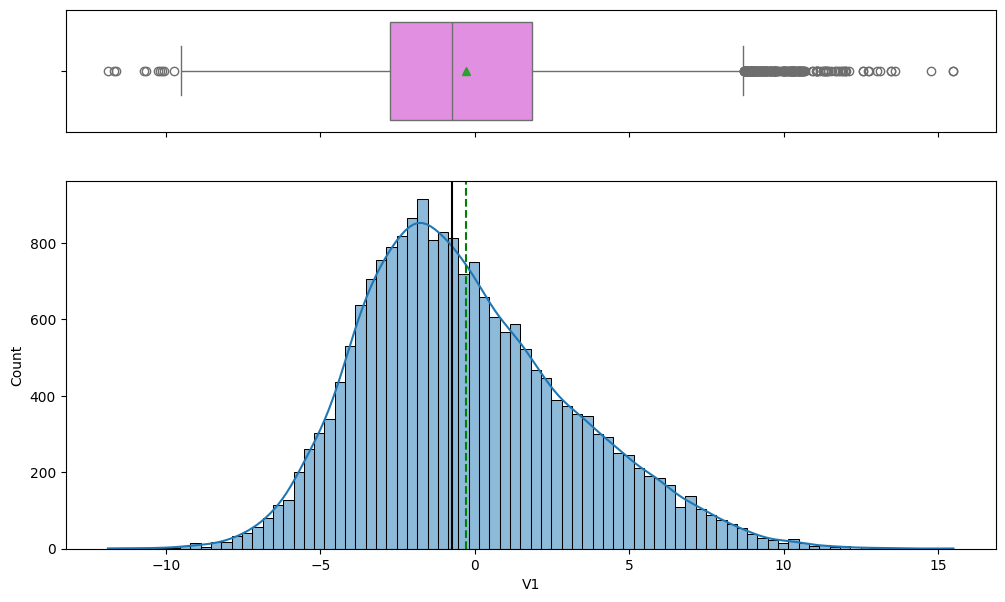

Plotting for V2


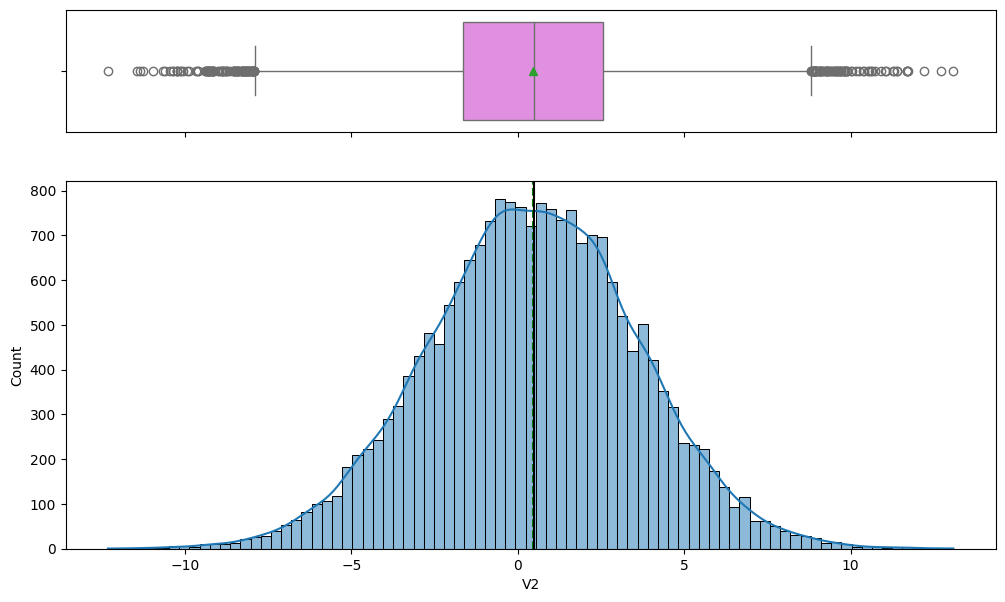

Plotting for V3


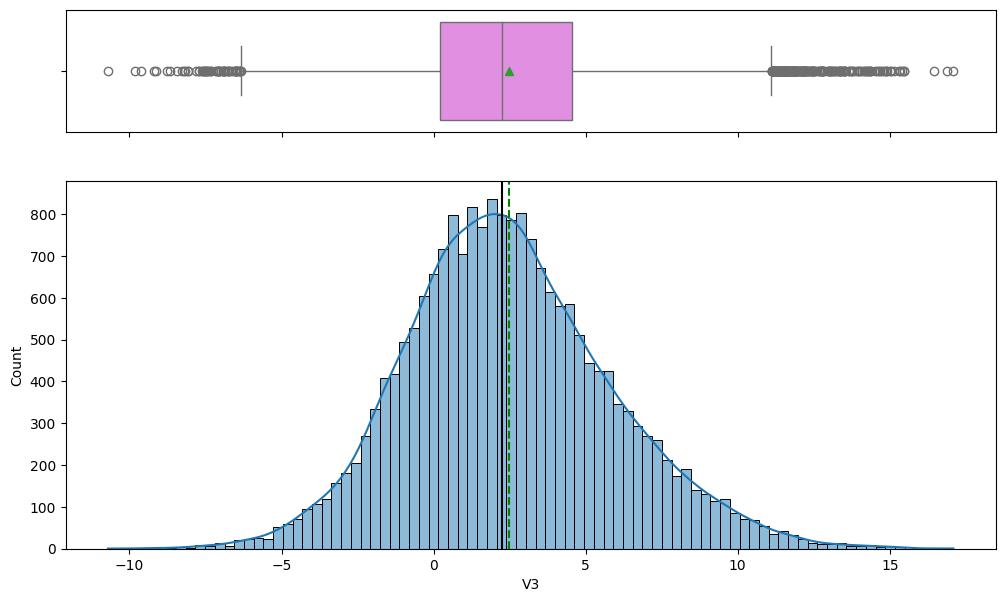

Plotting for V4


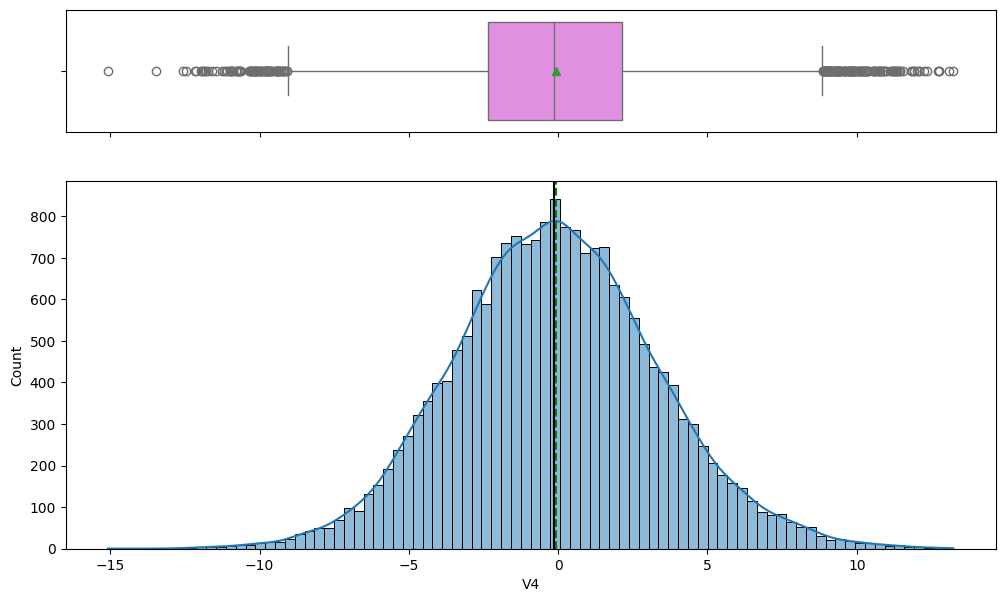

Plotting for V5


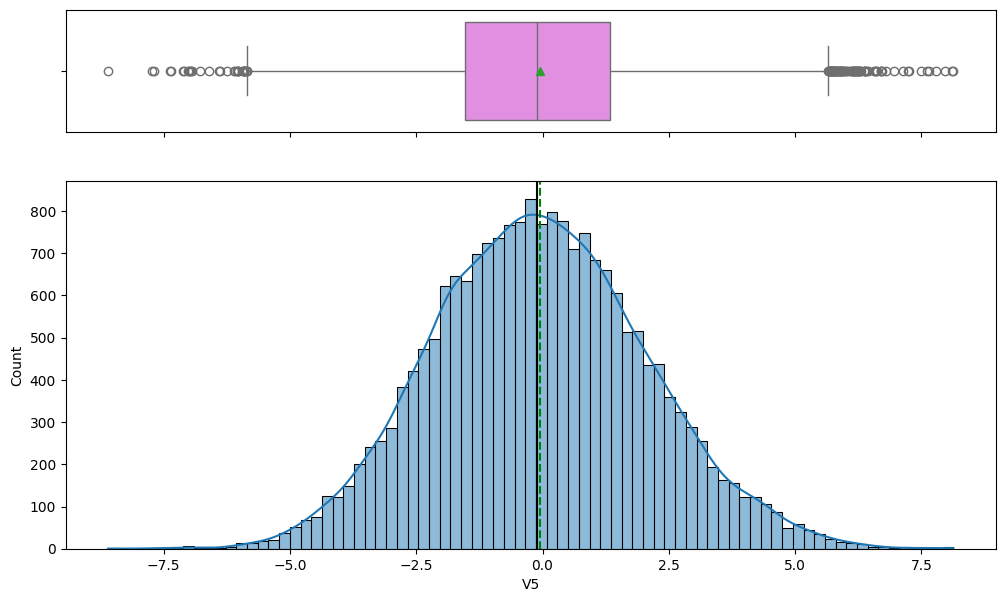

Plotting for V6


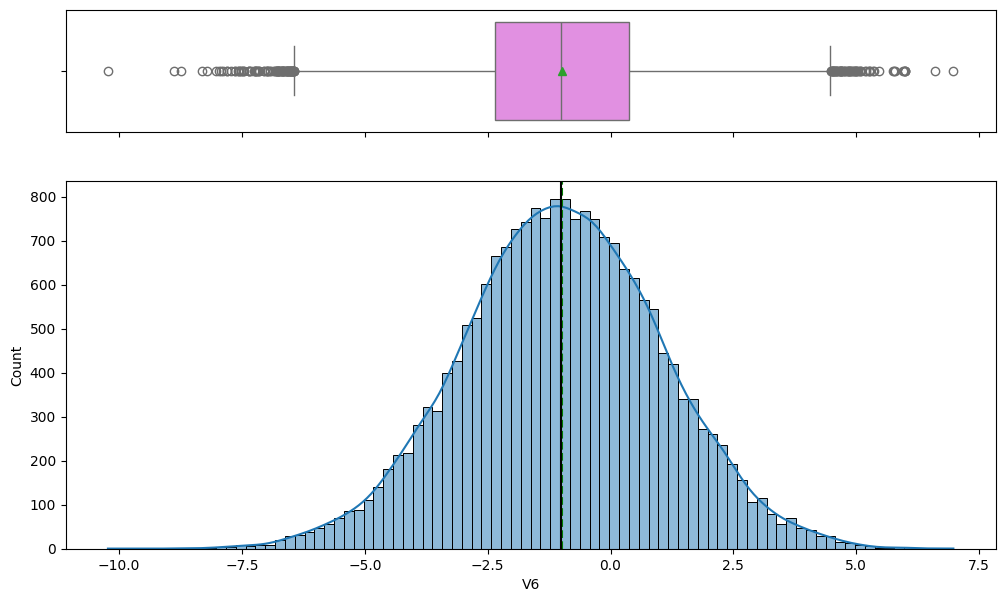

Plotting for V7


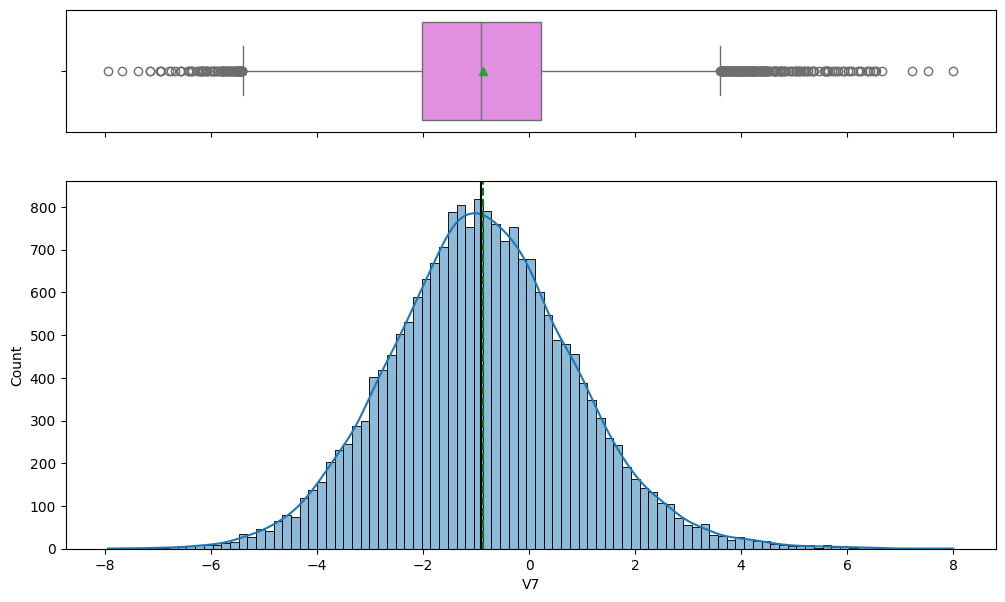

Plotting for V8


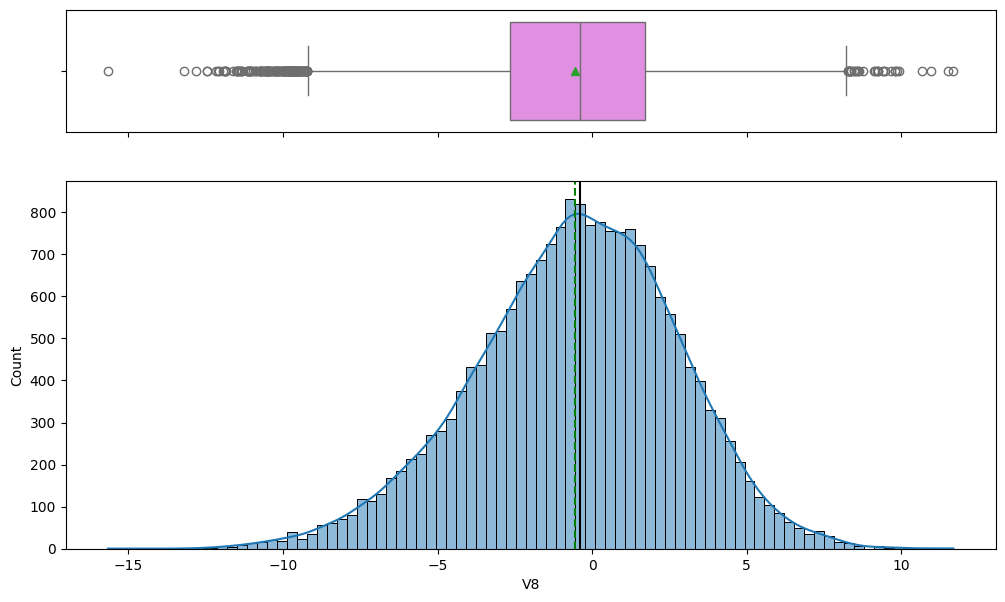

Plotting for V9


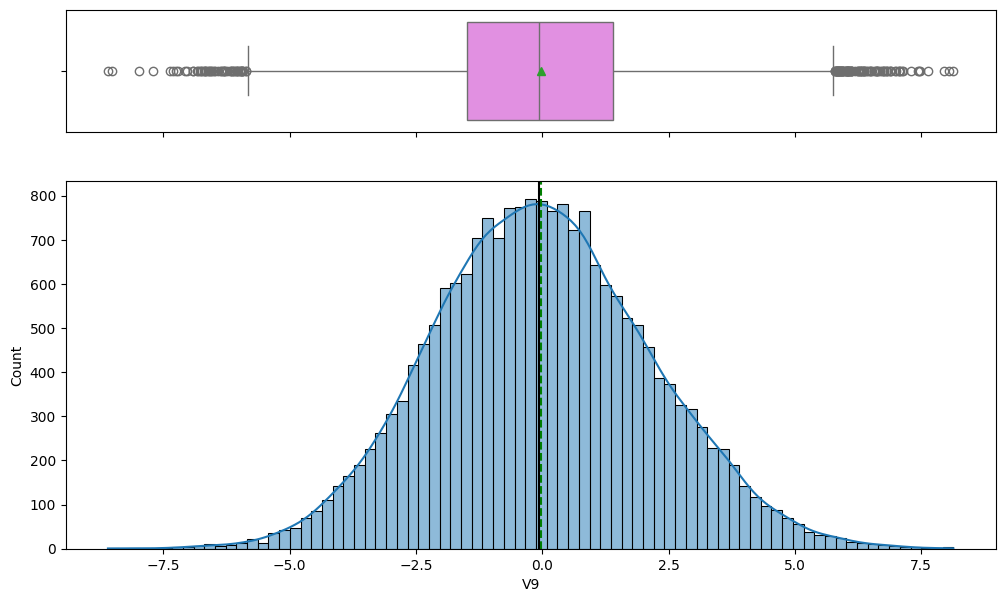

Plotting for V10


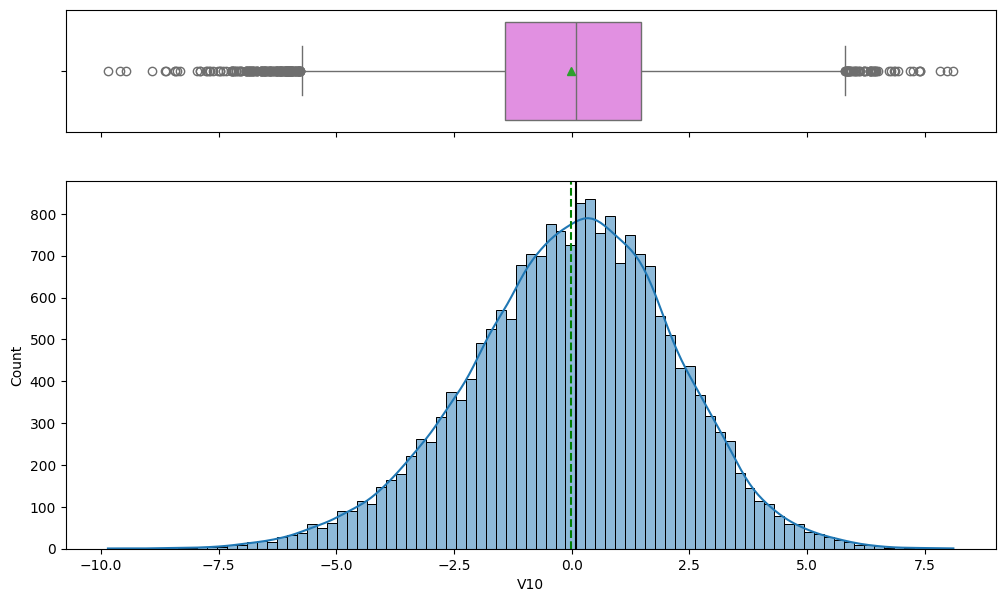

Plotting for V11


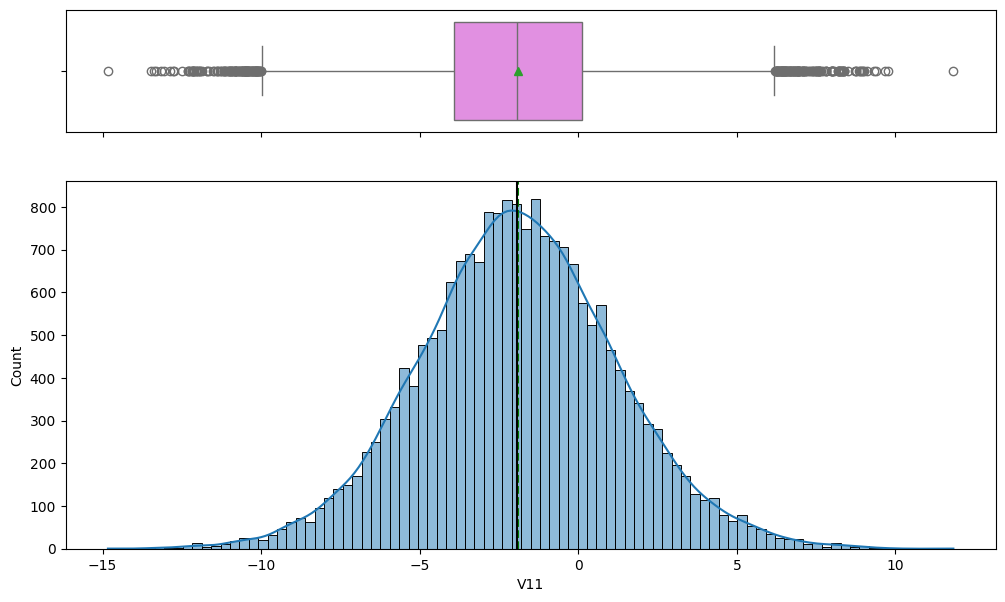

Plotting for V12


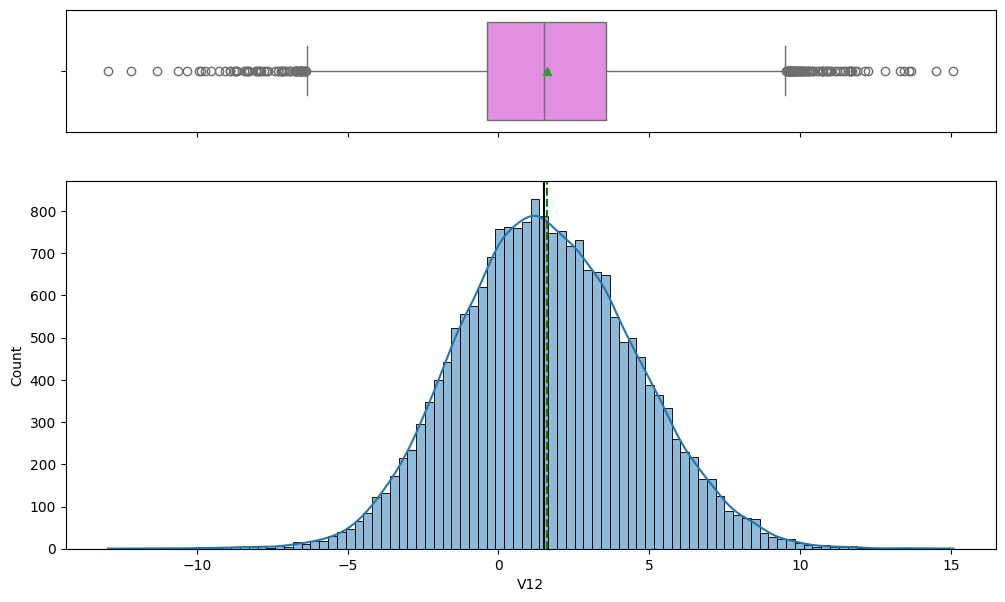

Plotting for V13


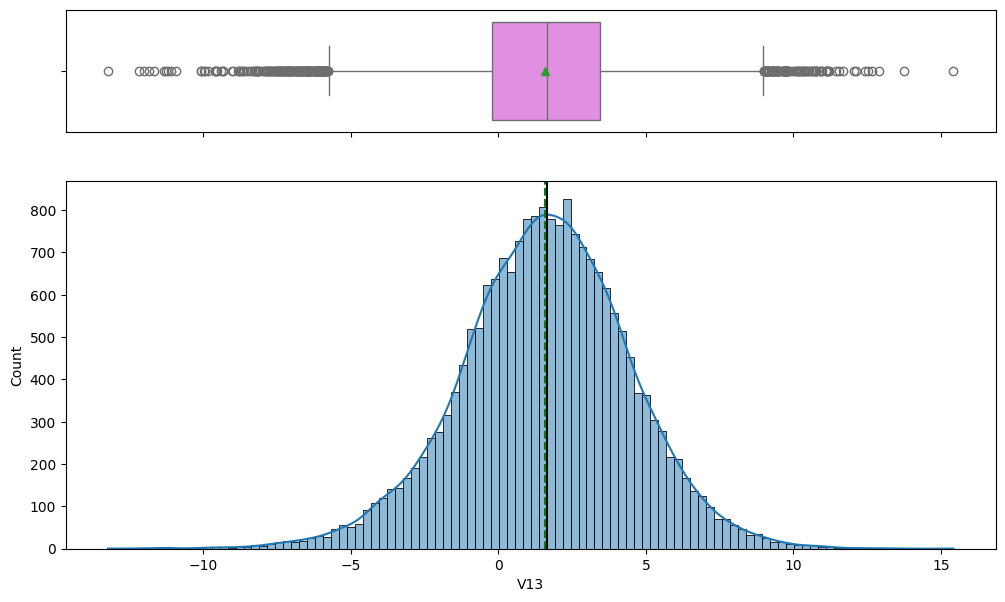

Plotting for V14


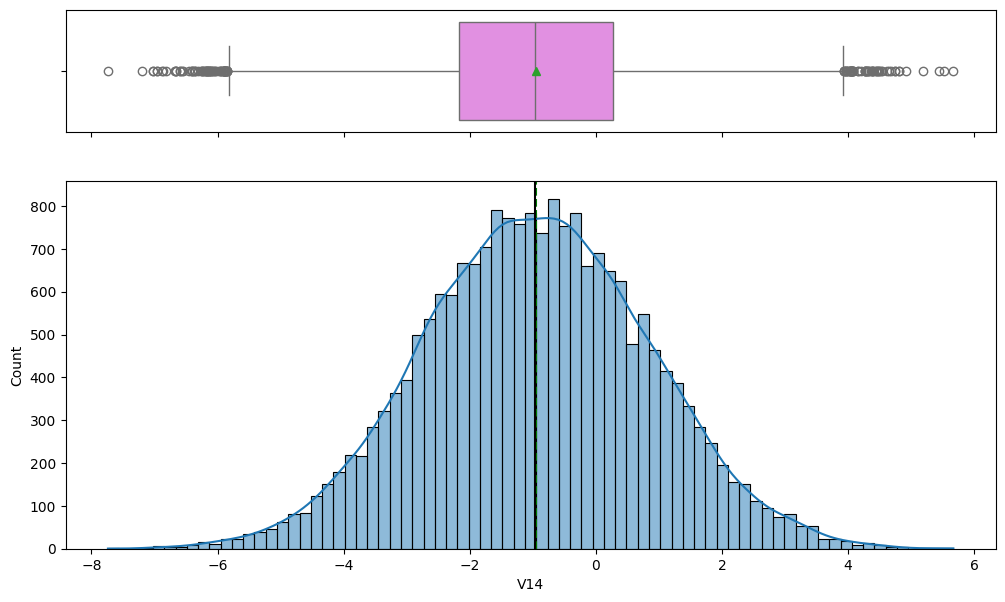

Plotting for V15


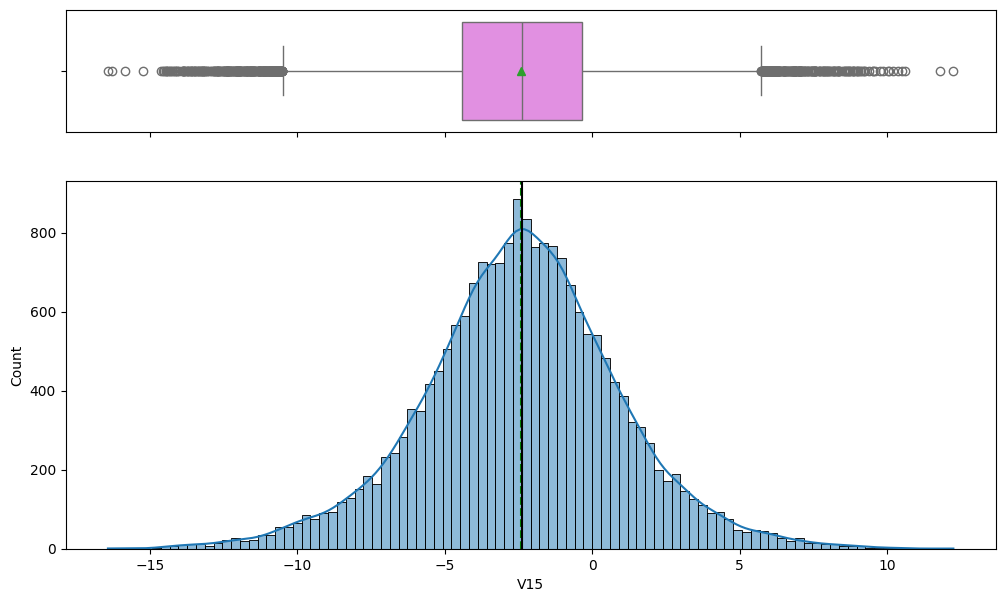

Plotting for V16


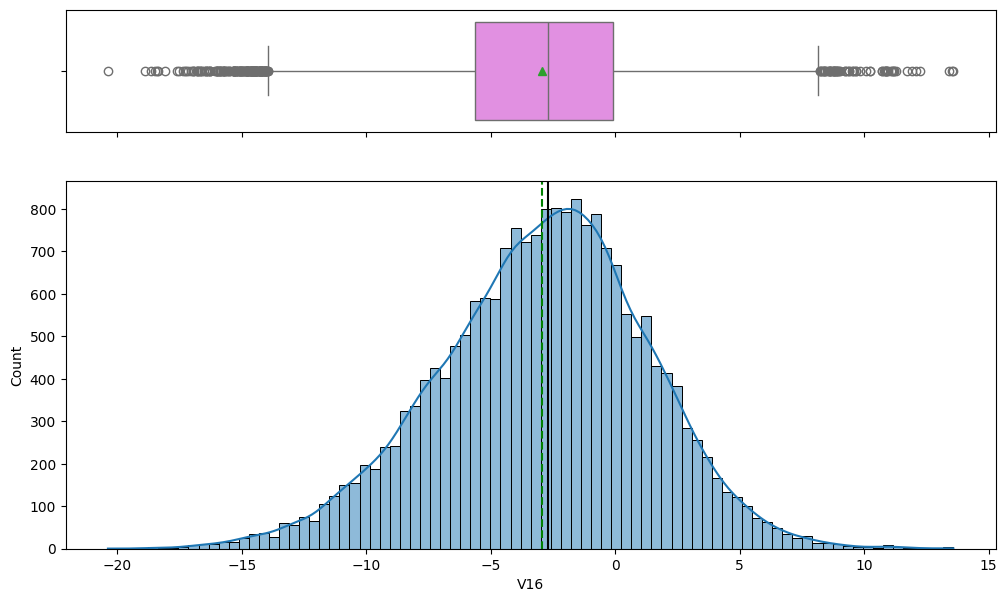

Plotting for V17


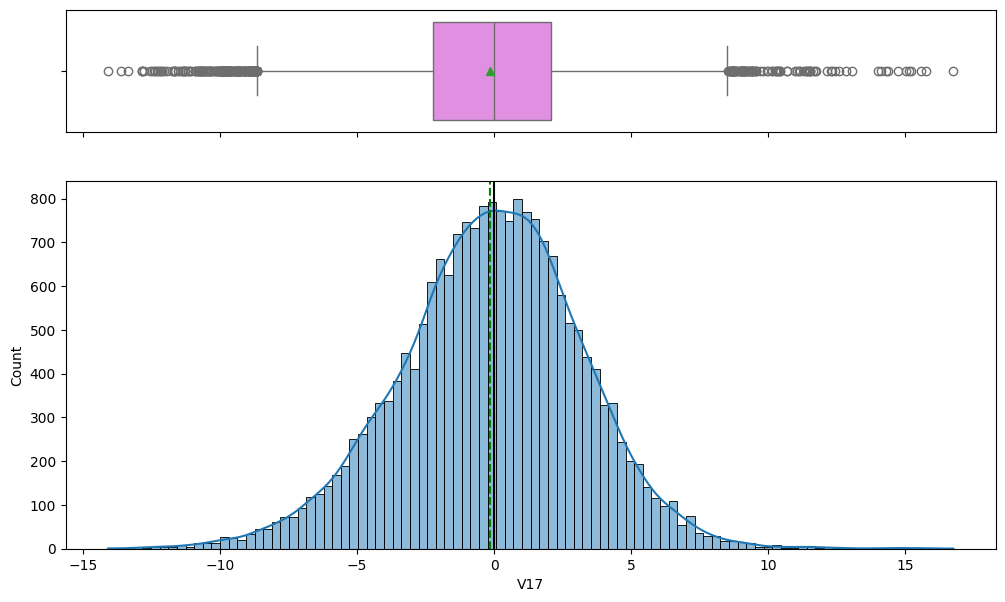

Plotting for V18


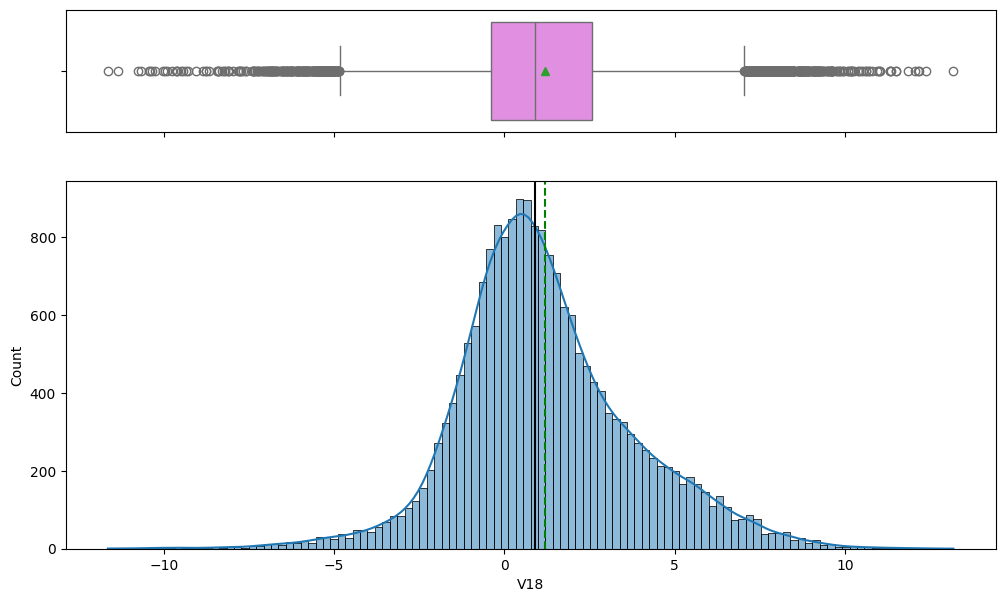

Plotting for V19


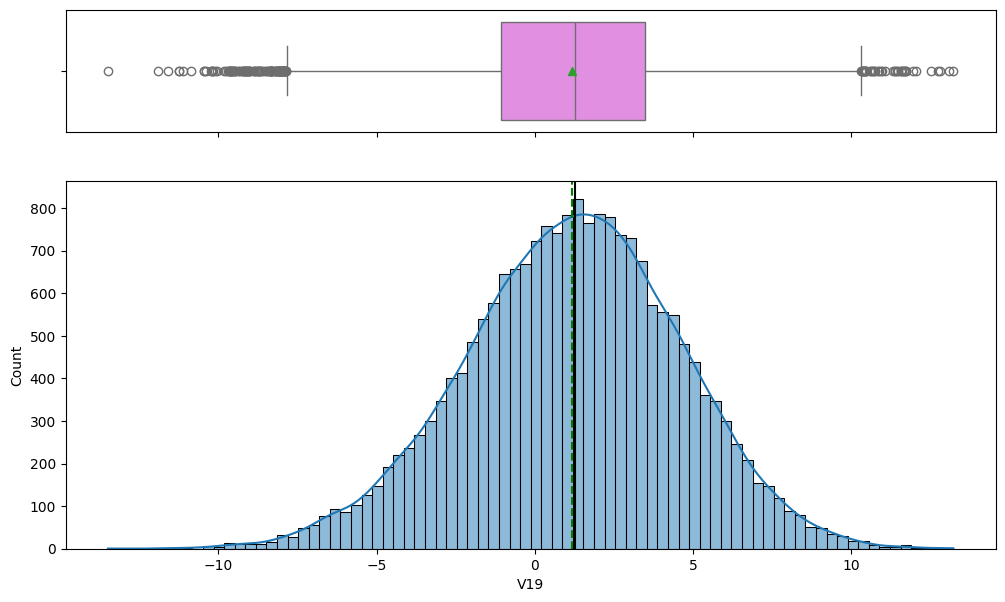

Plotting for V20


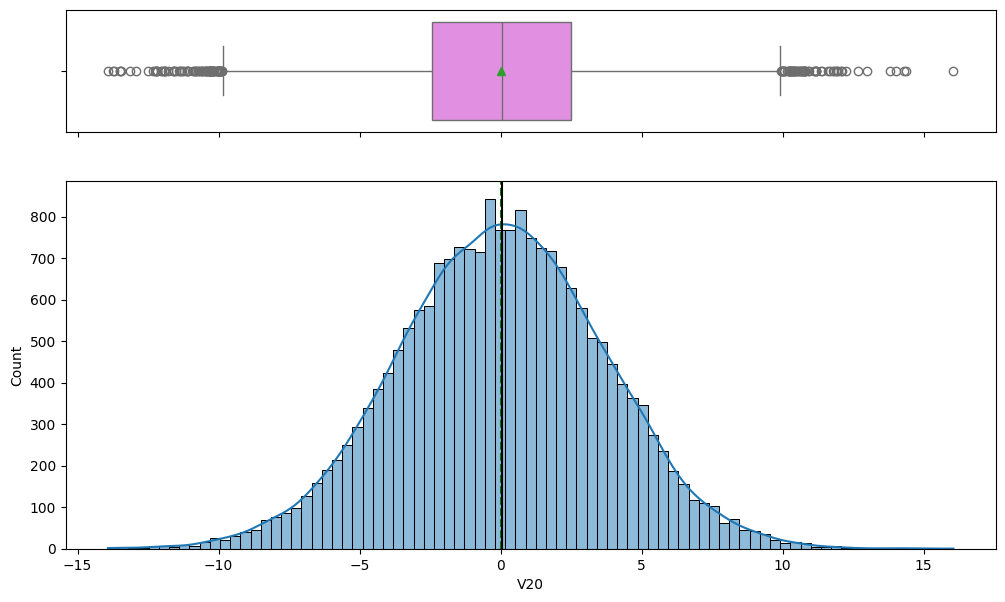

Plotting for V21


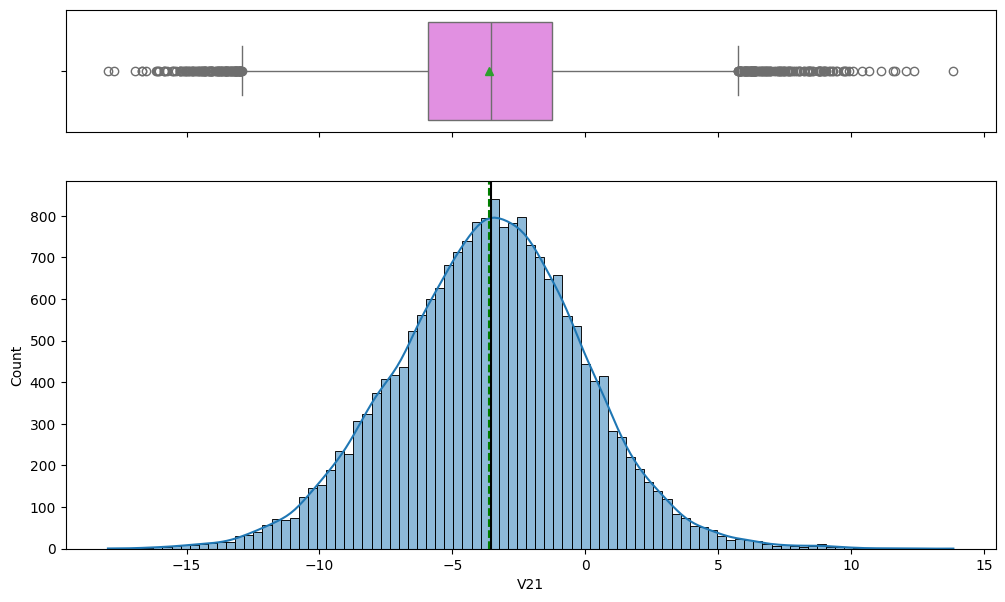

Plotting for V22


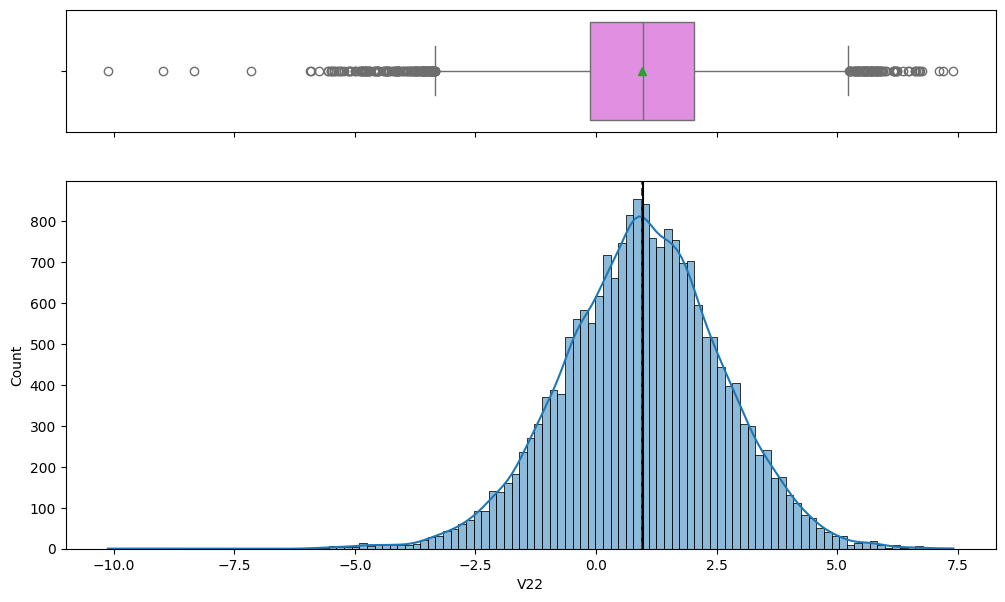

Plotting for V23


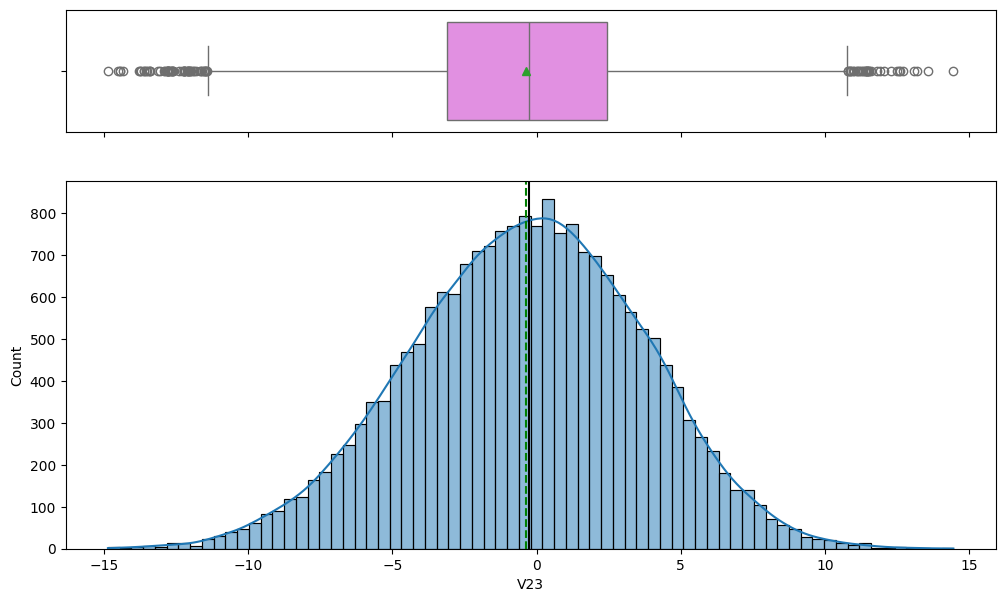

Plotting for V24


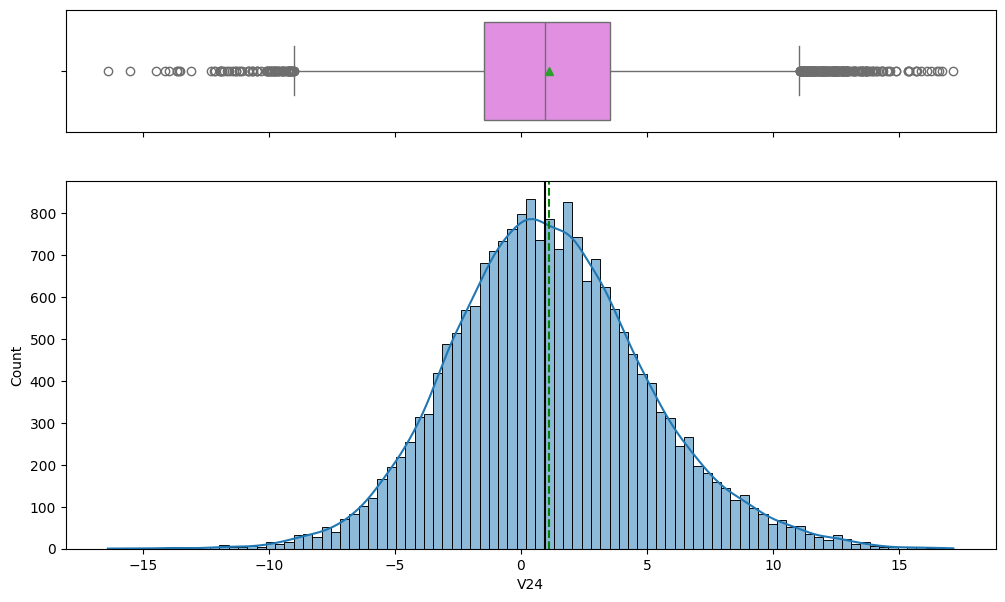

Plotting for V25


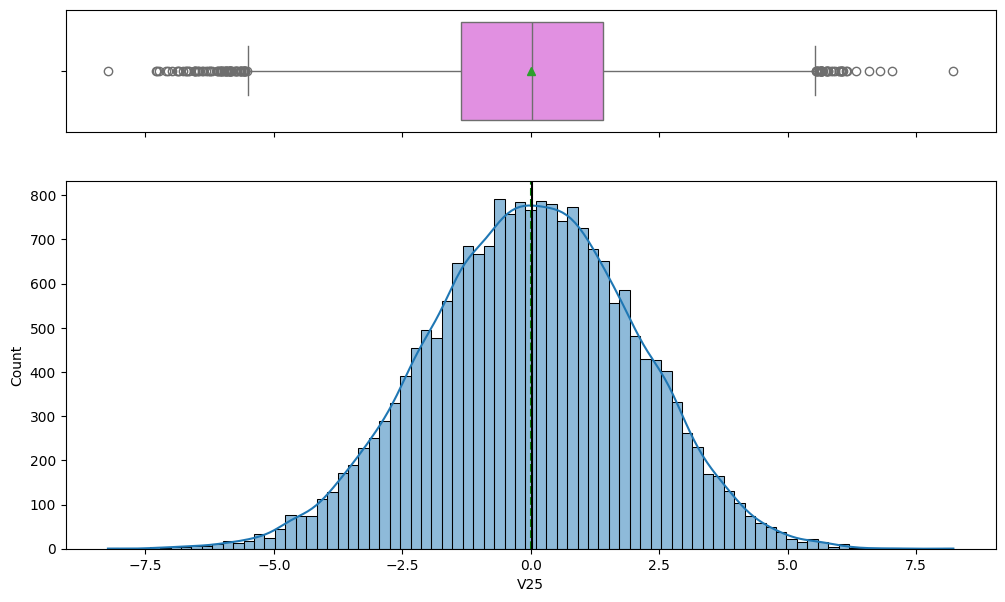

Plotting for V26


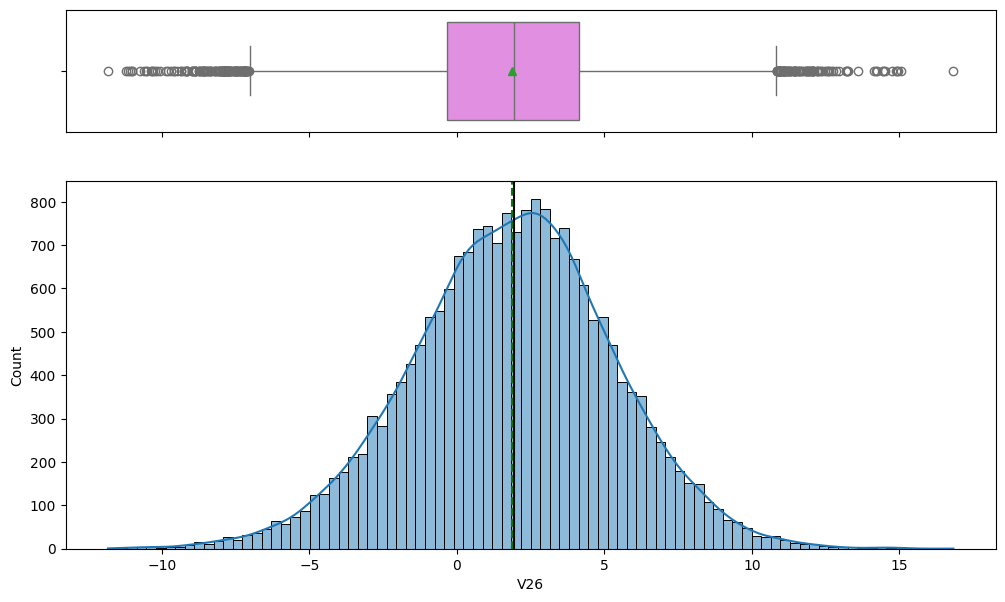

Plotting for V27


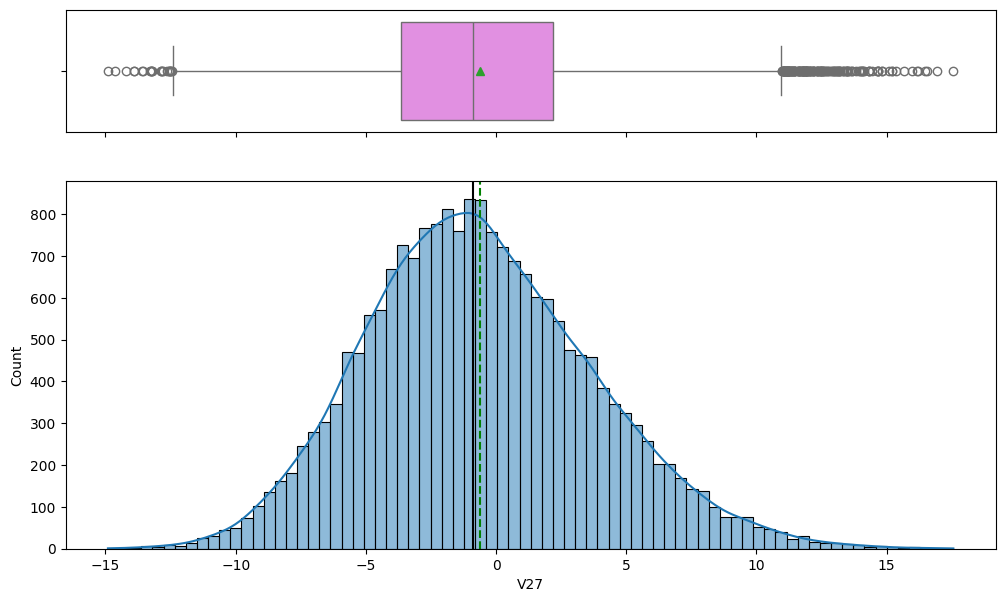

Plotting for V28


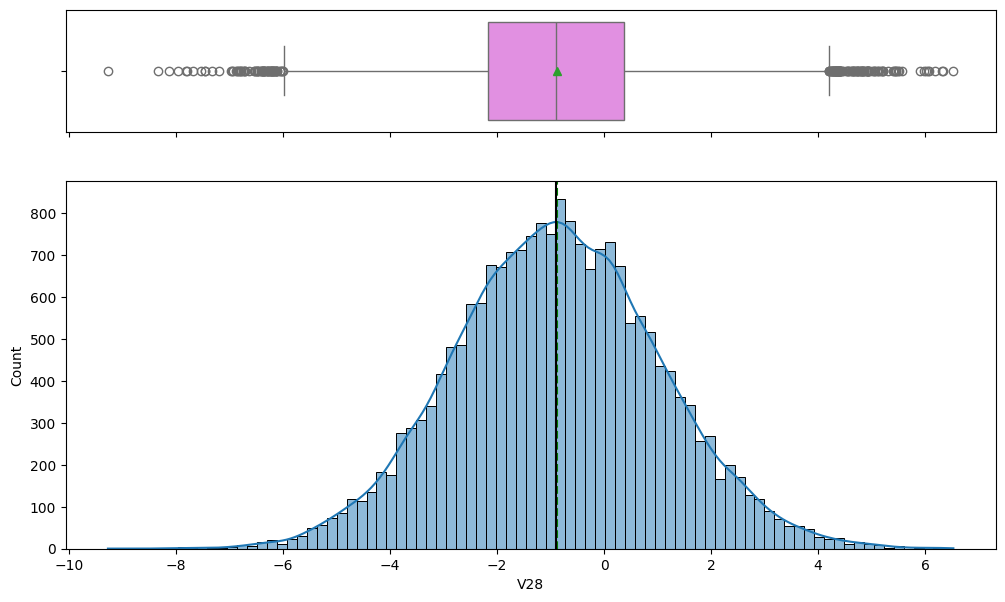

Plotting for V29


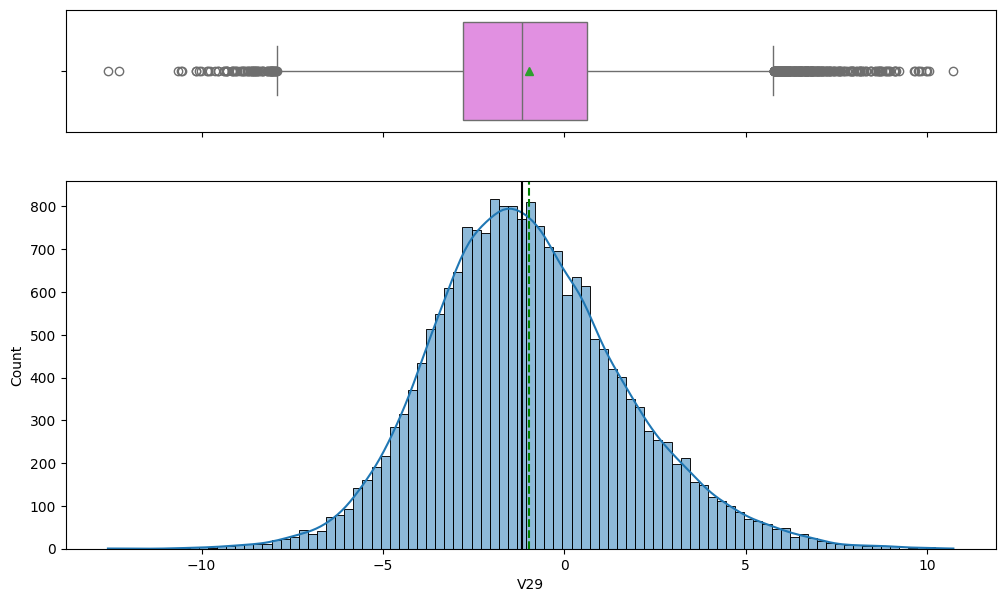

Plotting for V30


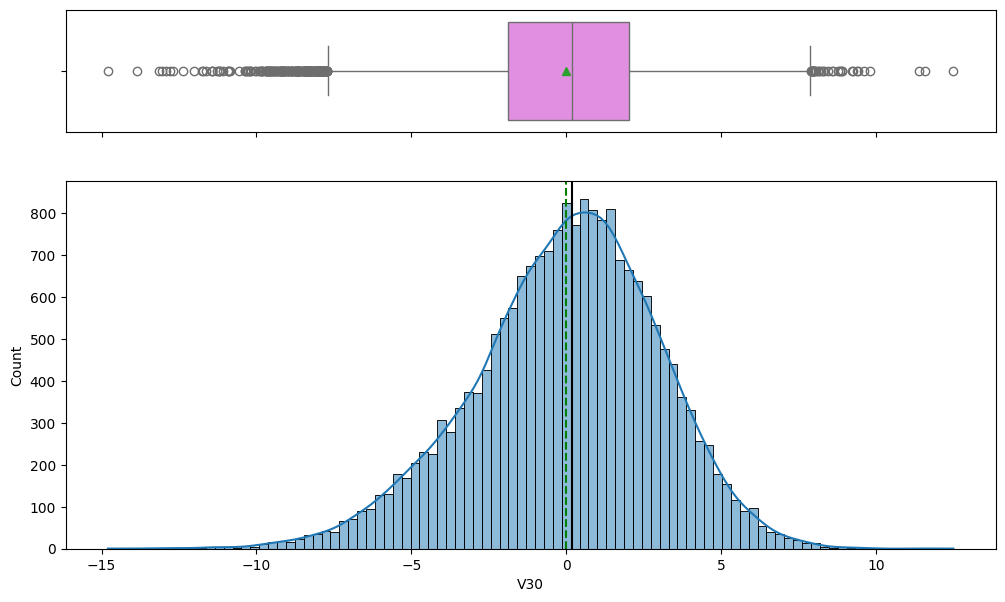

Plotting for V31


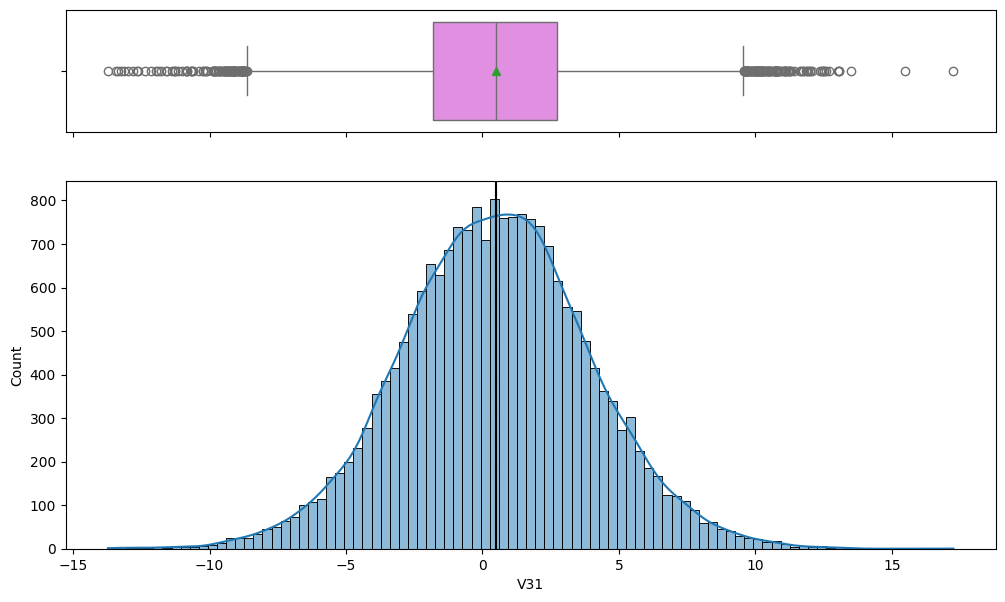

Plotting for V32


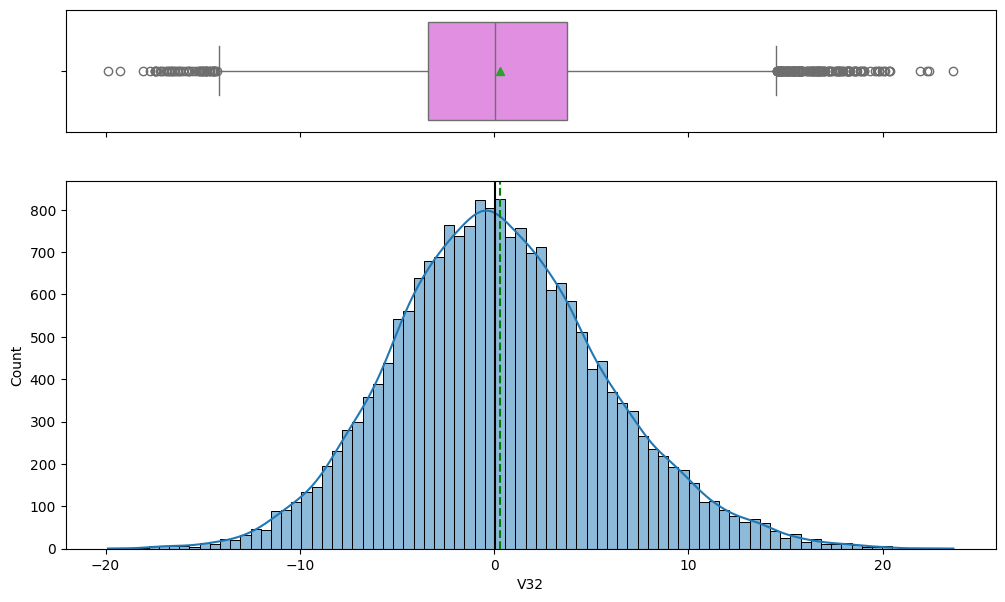

Plotting for V33


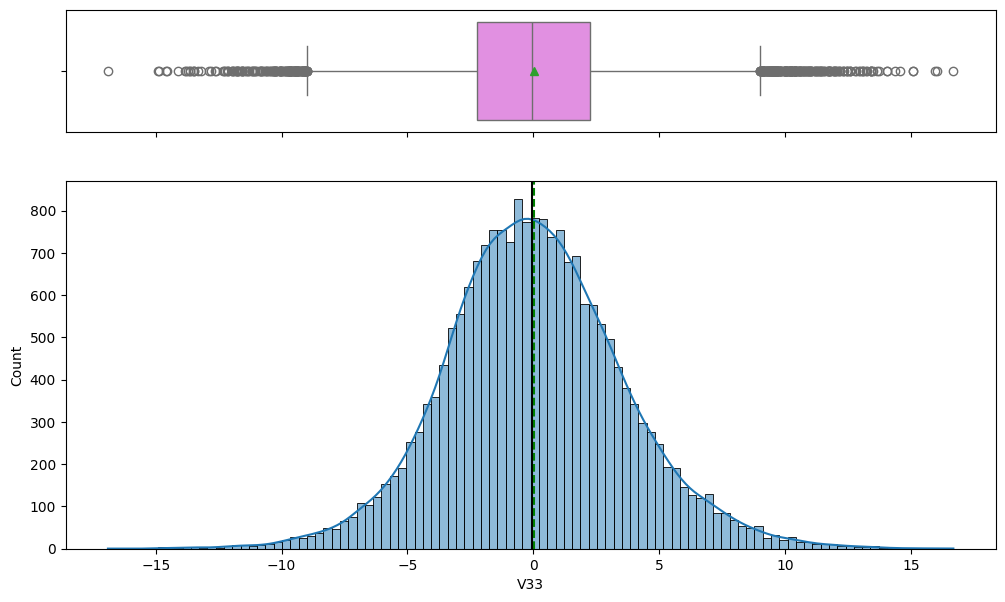

Plotting for V34


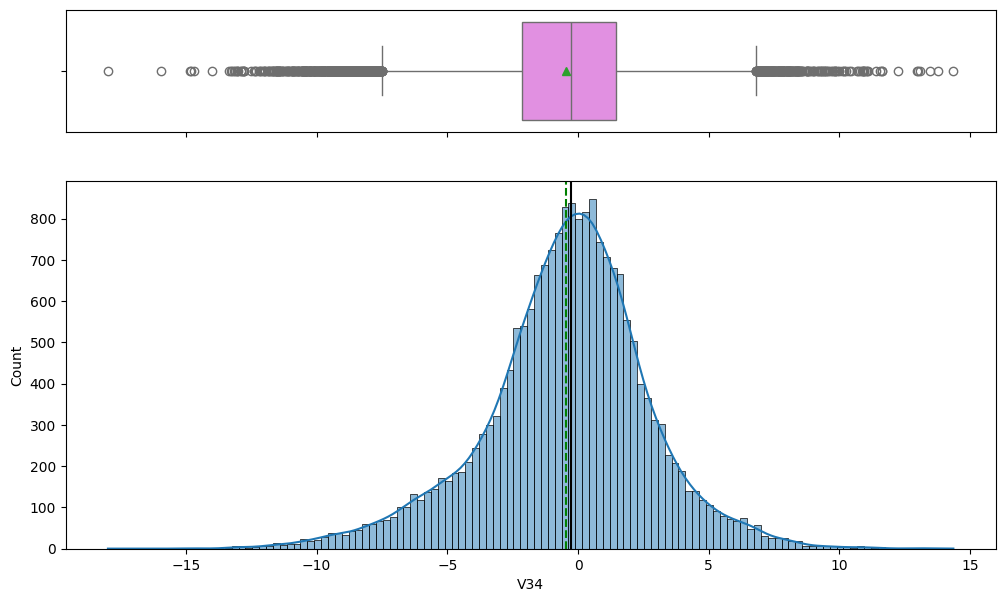

Plotting for V35


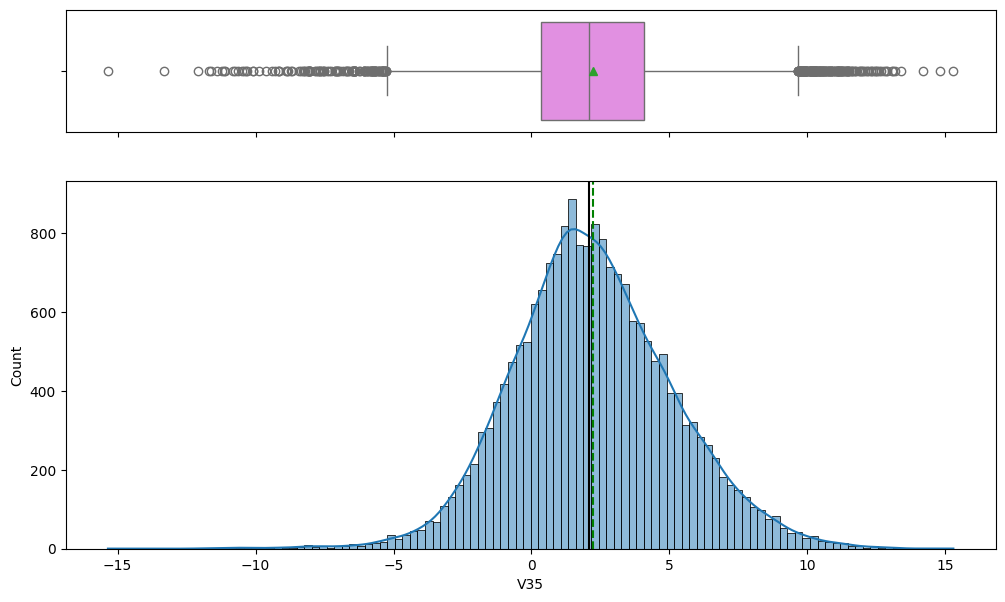

Plotting for V36


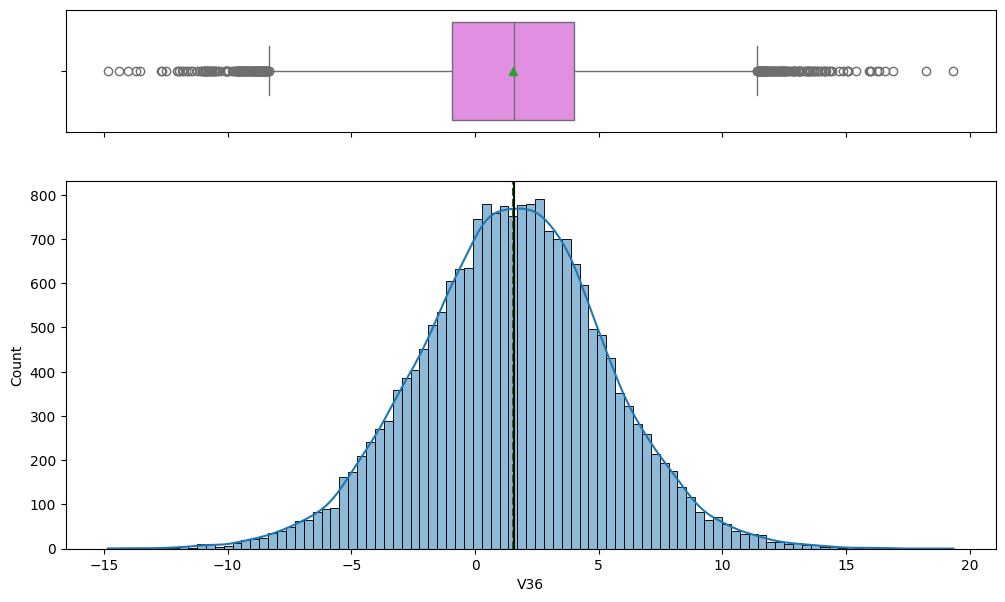

Plotting for V37


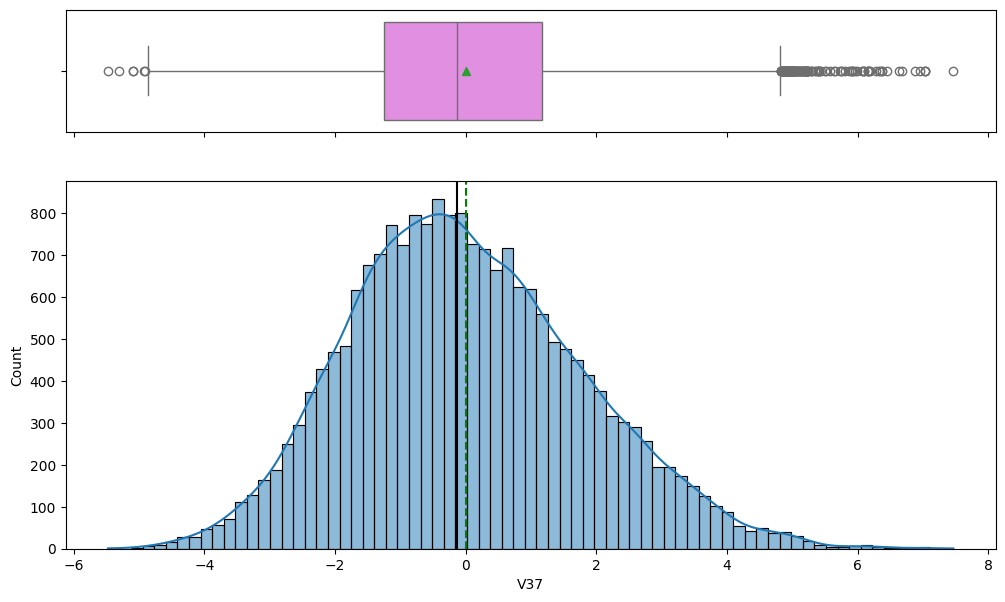

Plotting for V38


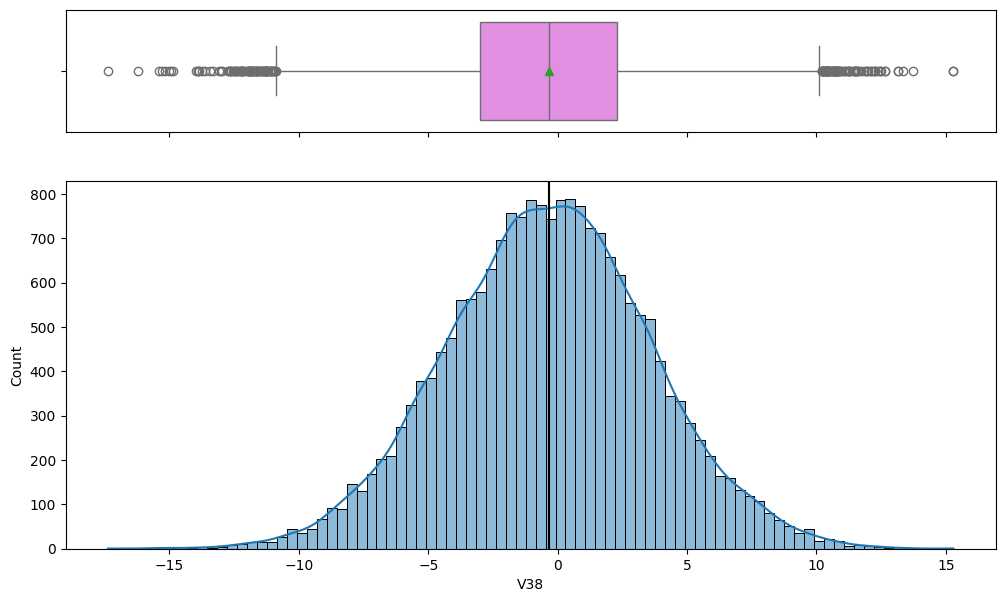

Plotting for V39


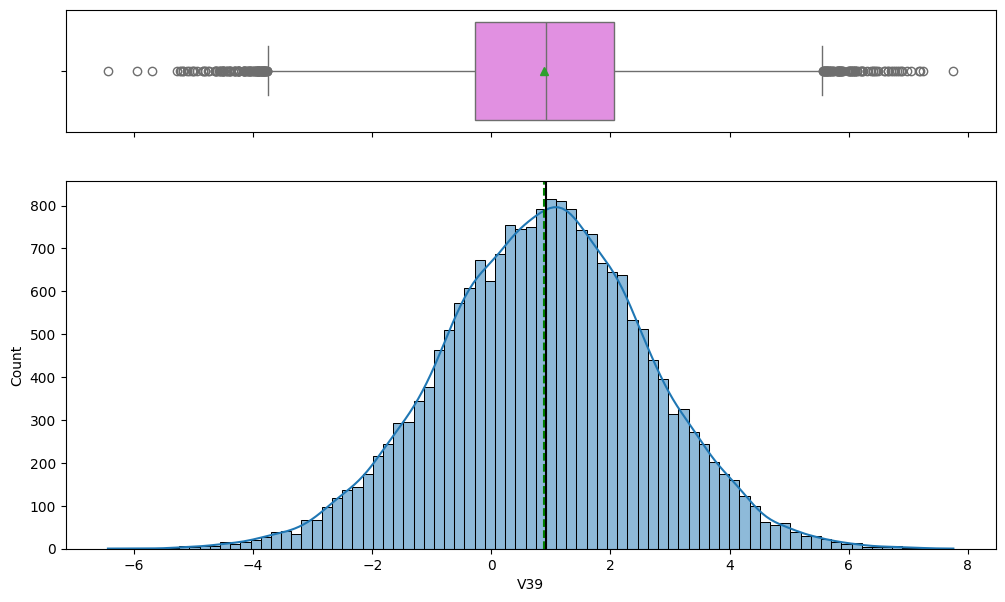

Plotting for V40


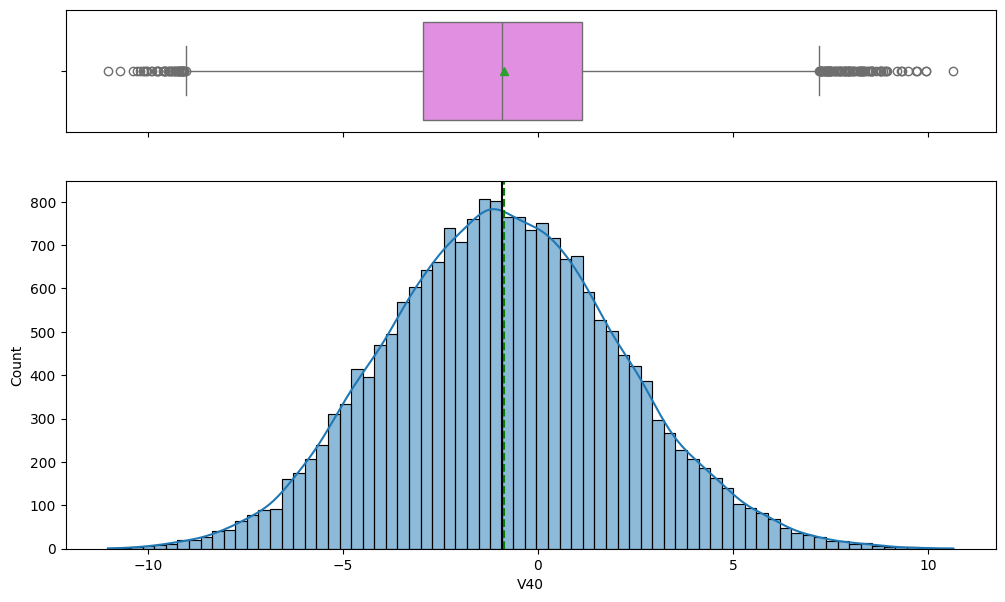

Plotting for V1


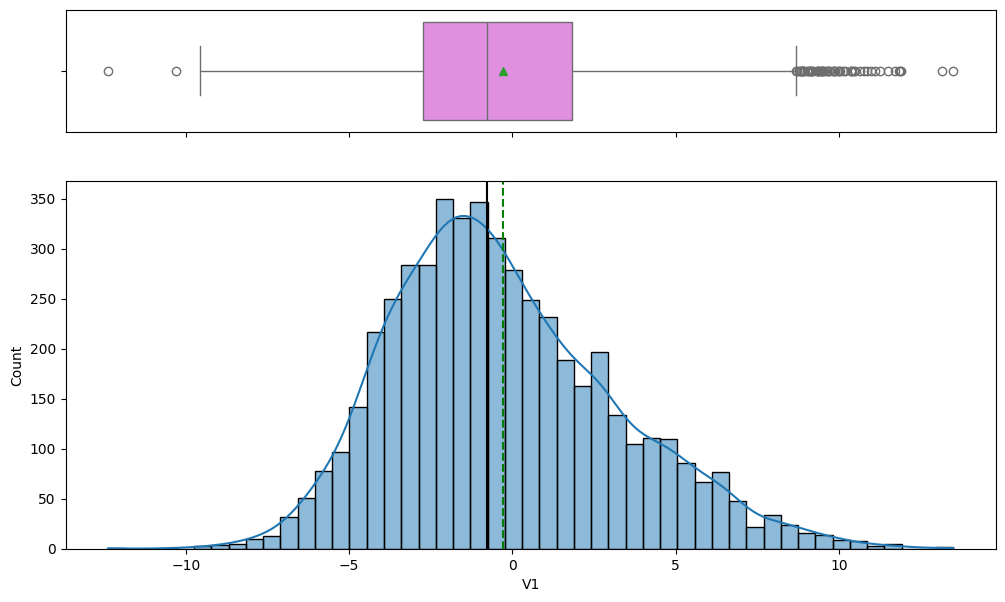

Plotting for V2


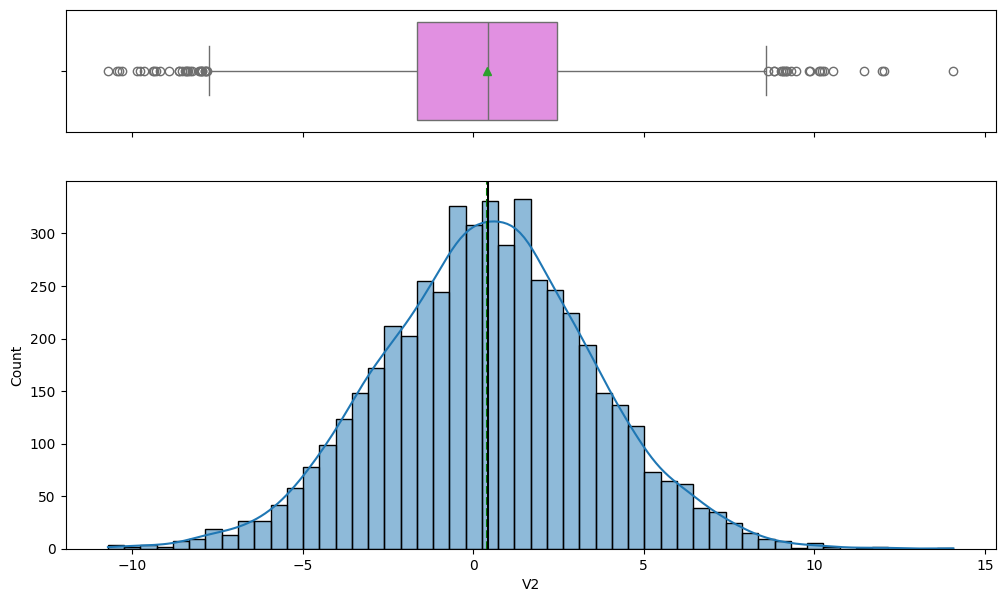

Plotting for V3


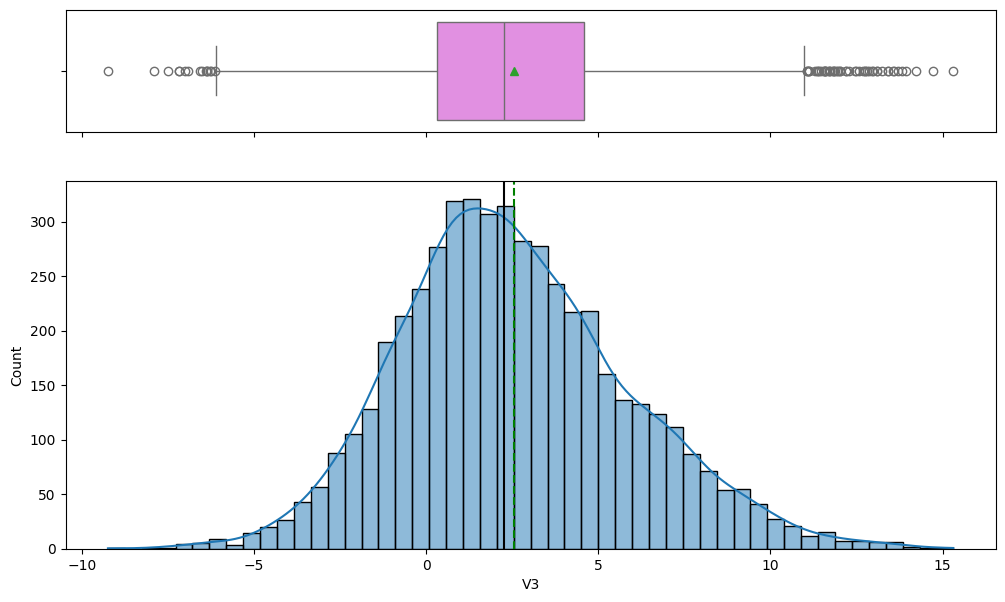

Plotting for V4


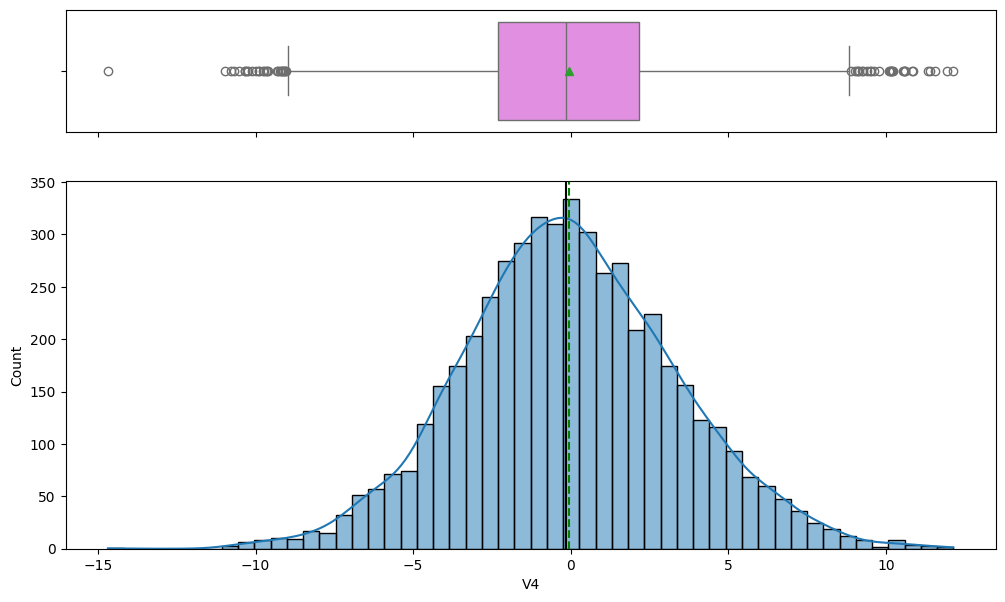

Plotting for V5


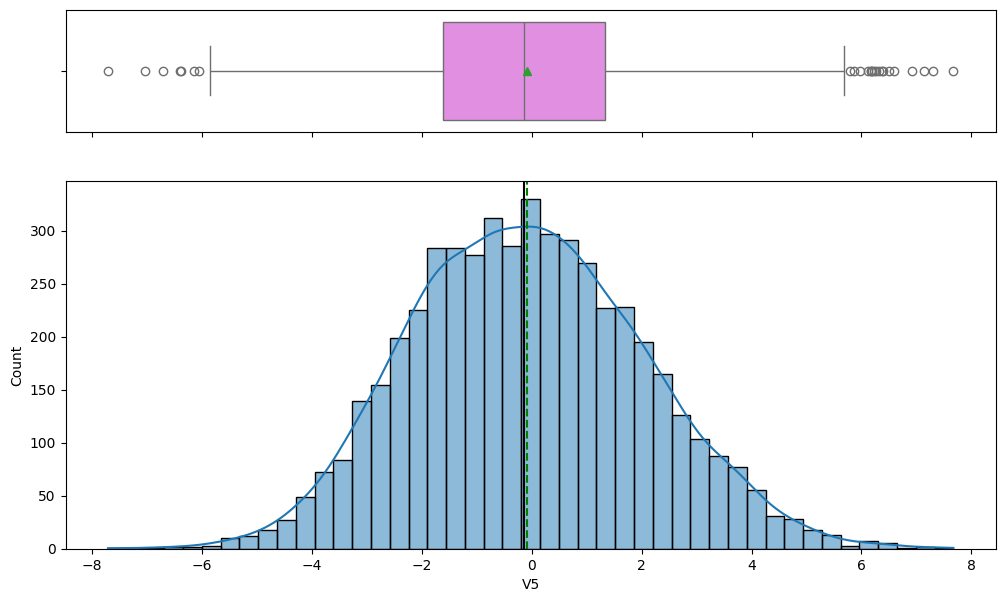

Plotting for V6


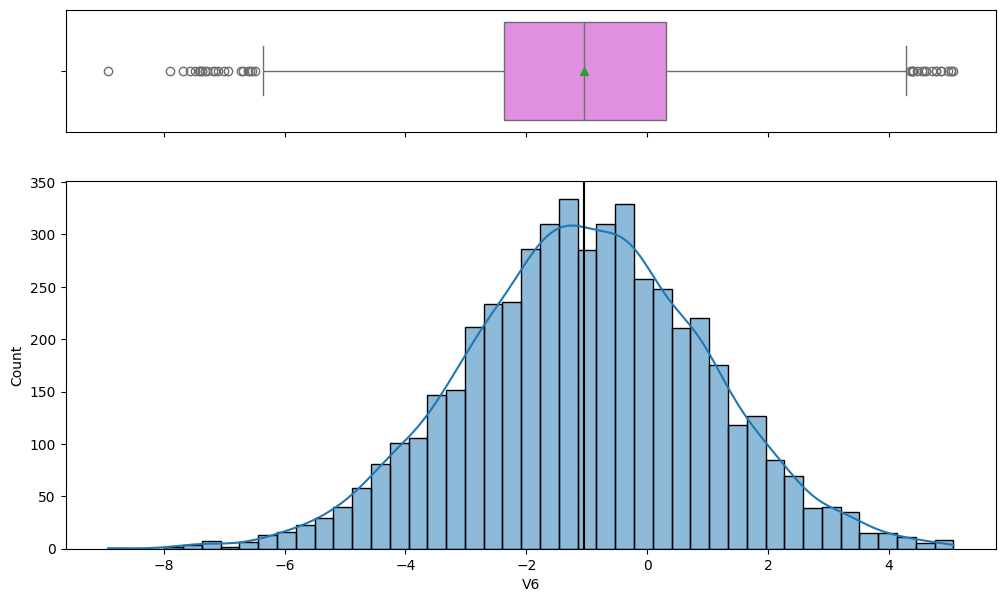

Plotting for V7


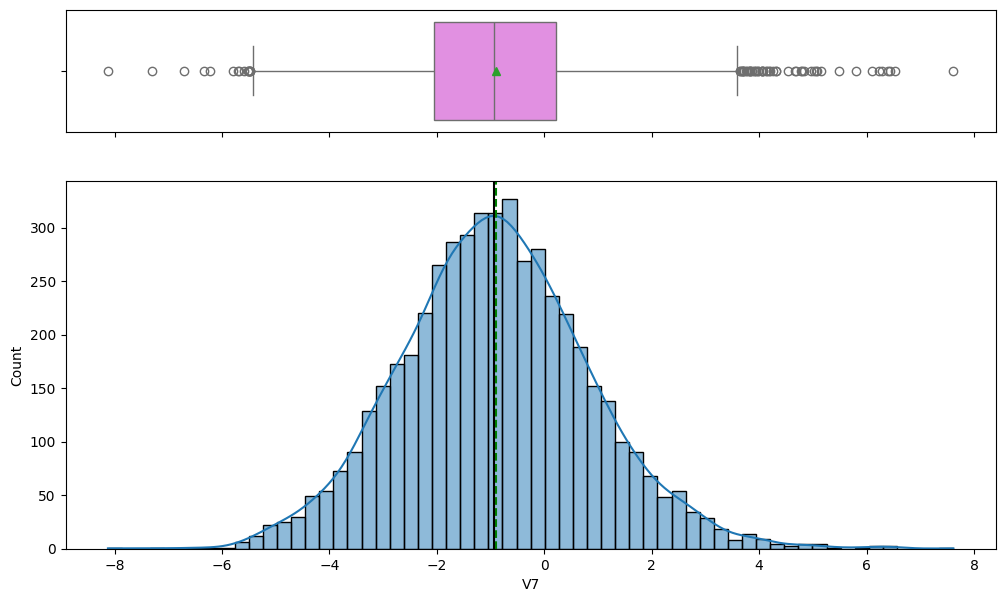

Plotting for V8


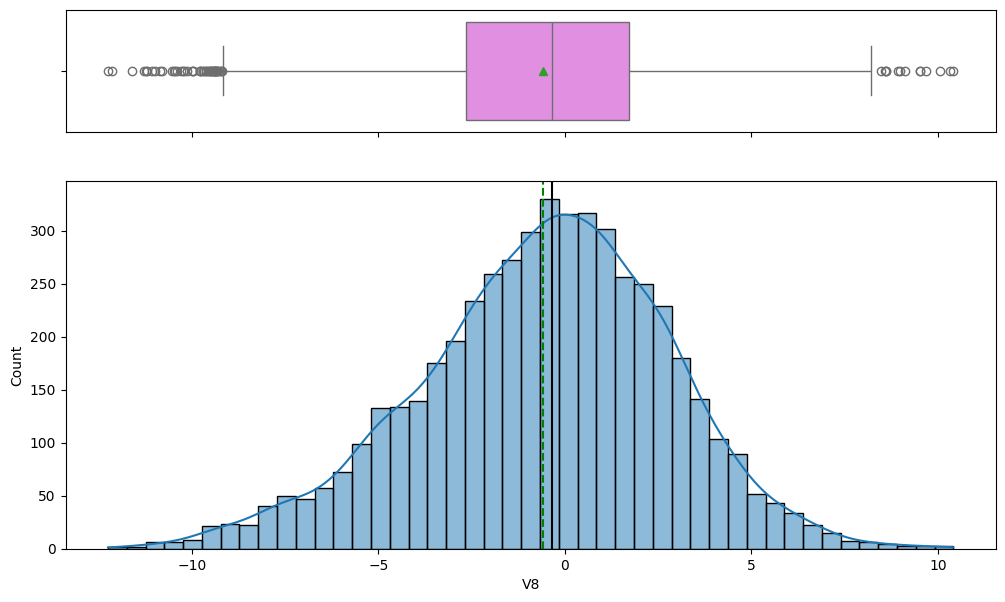

Plotting for V9


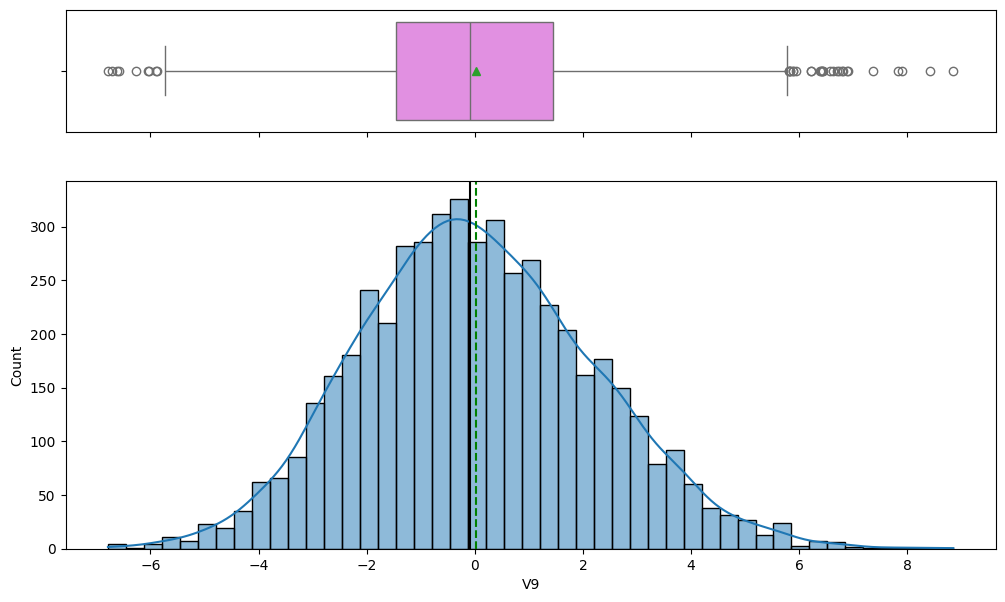

Plotting for V10


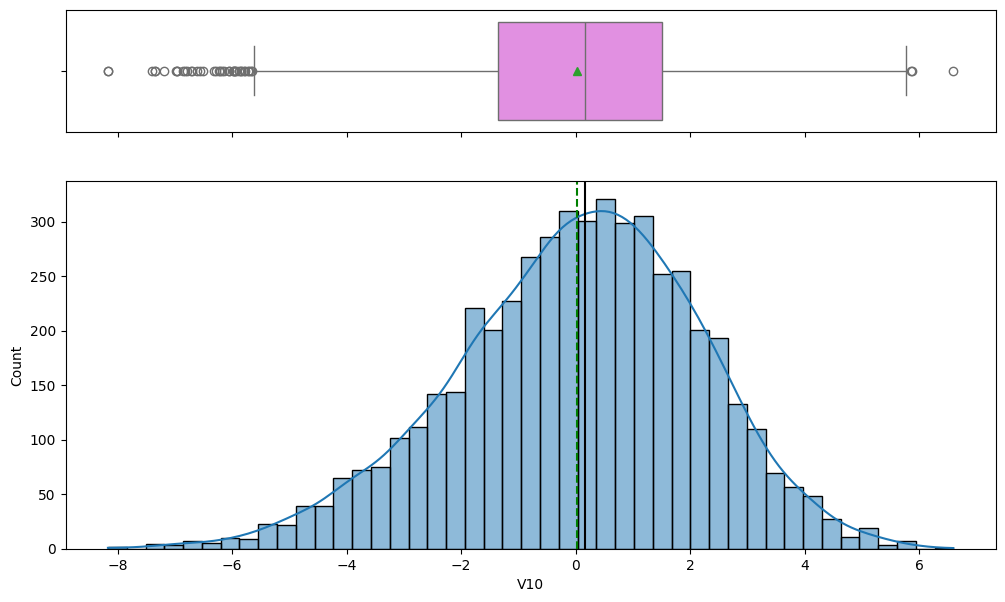

Plotting for V11


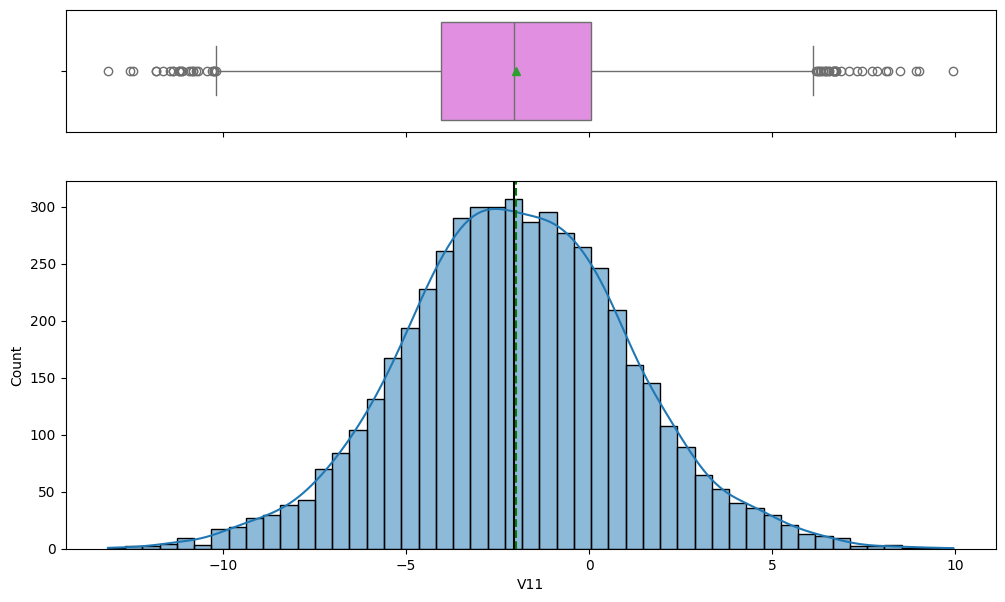

Plotting for V12


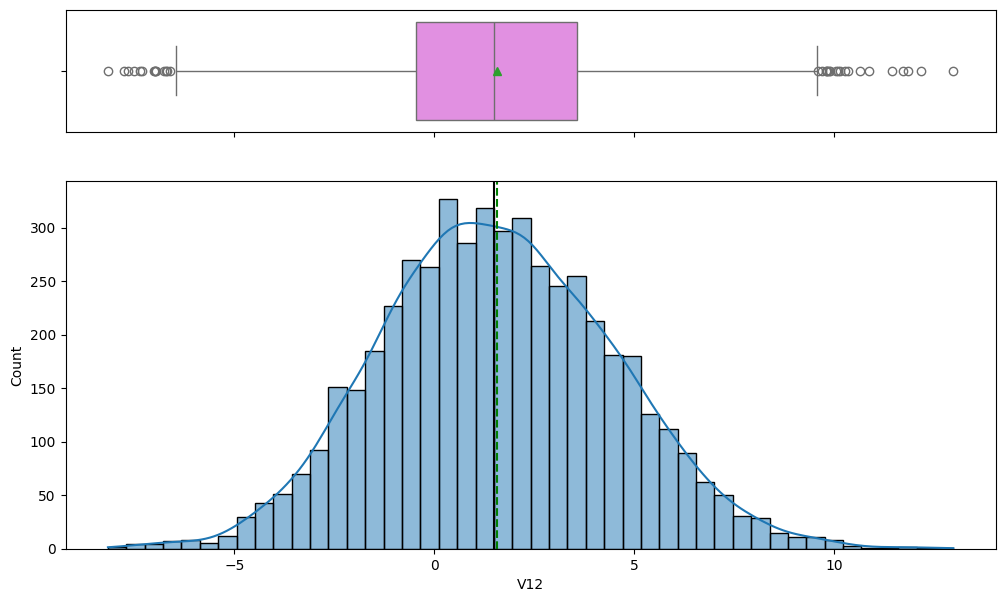

Plotting for V13


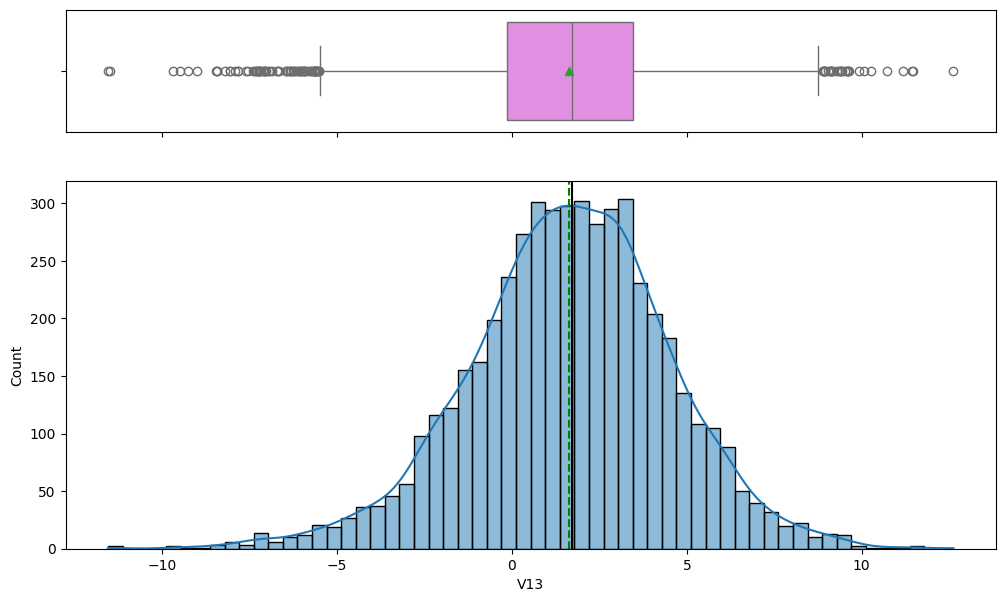

Plotting for V14


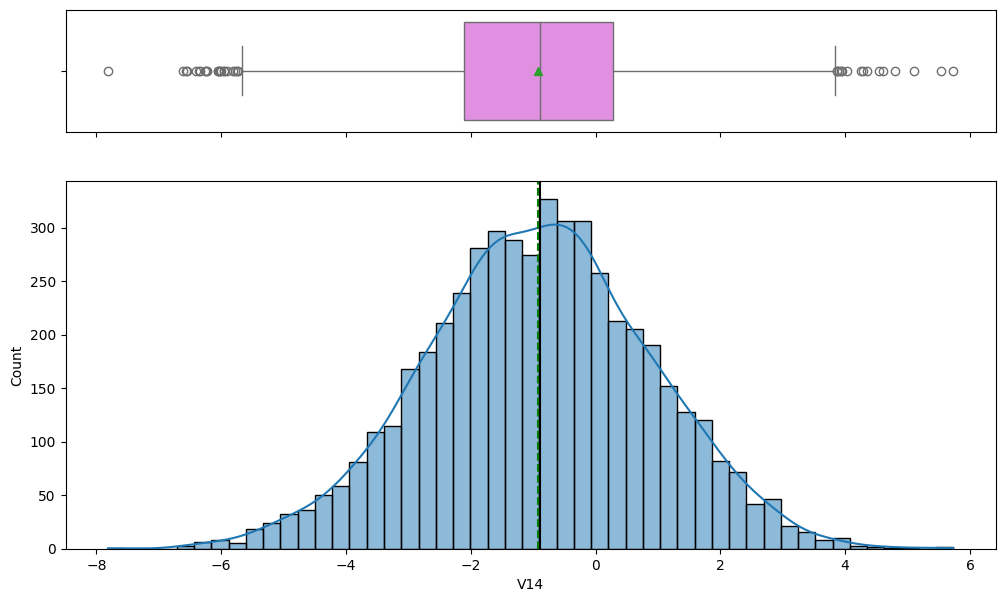

Plotting for V15


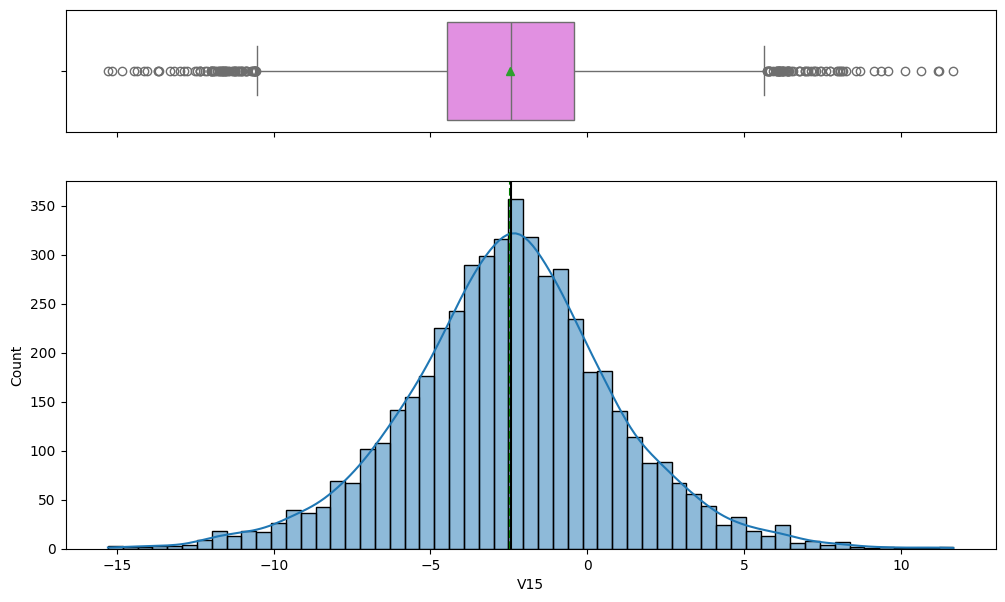

Plotting for V16


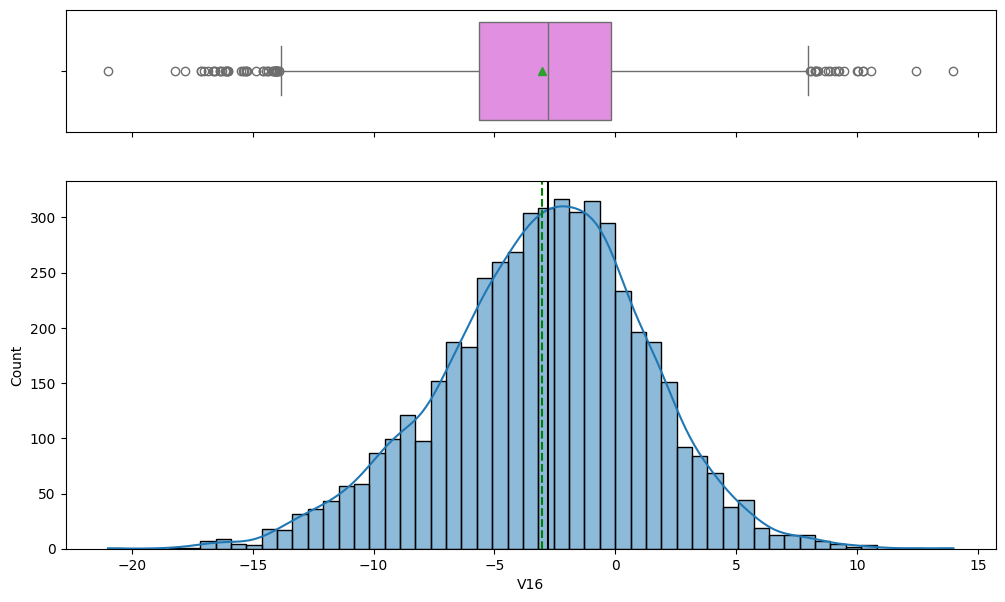

Plotting for V17


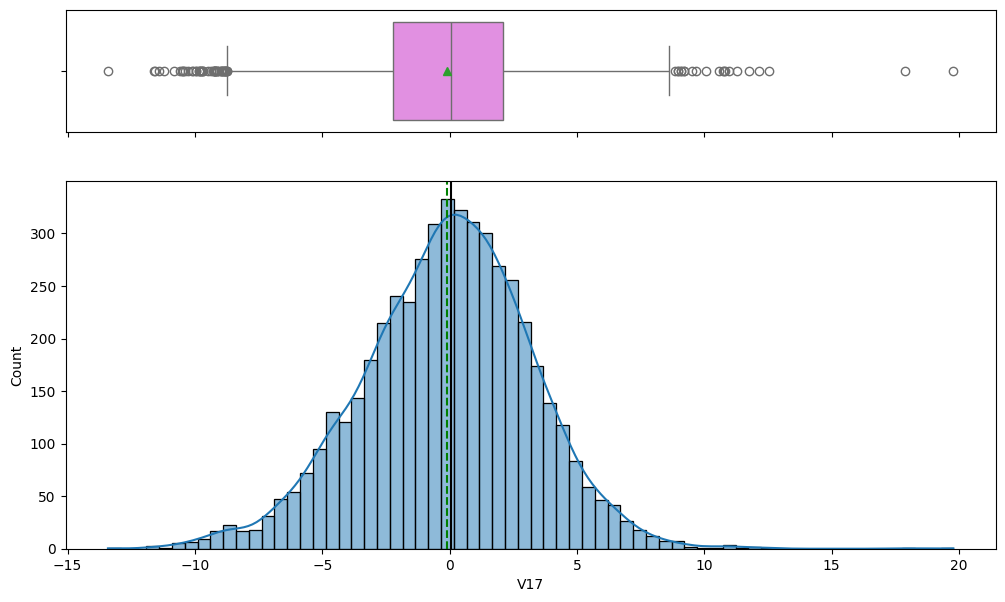

Plotting for V18


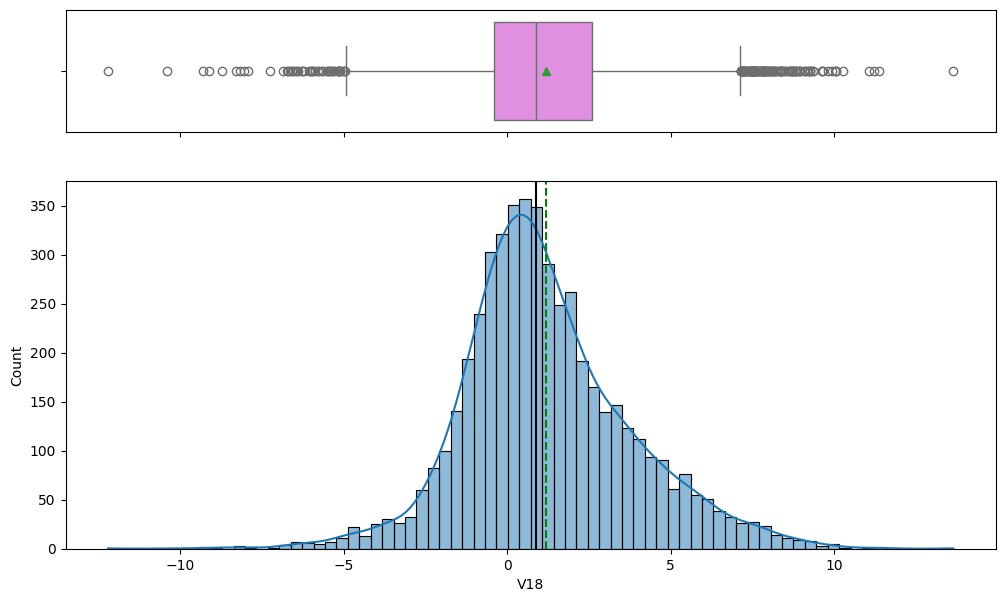

Plotting for V19


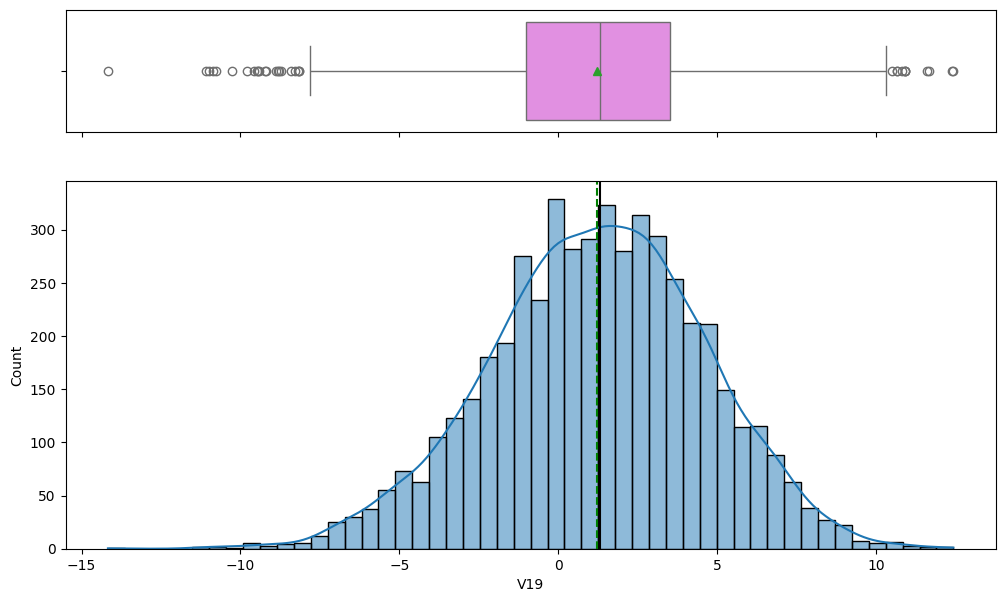

Plotting for V20


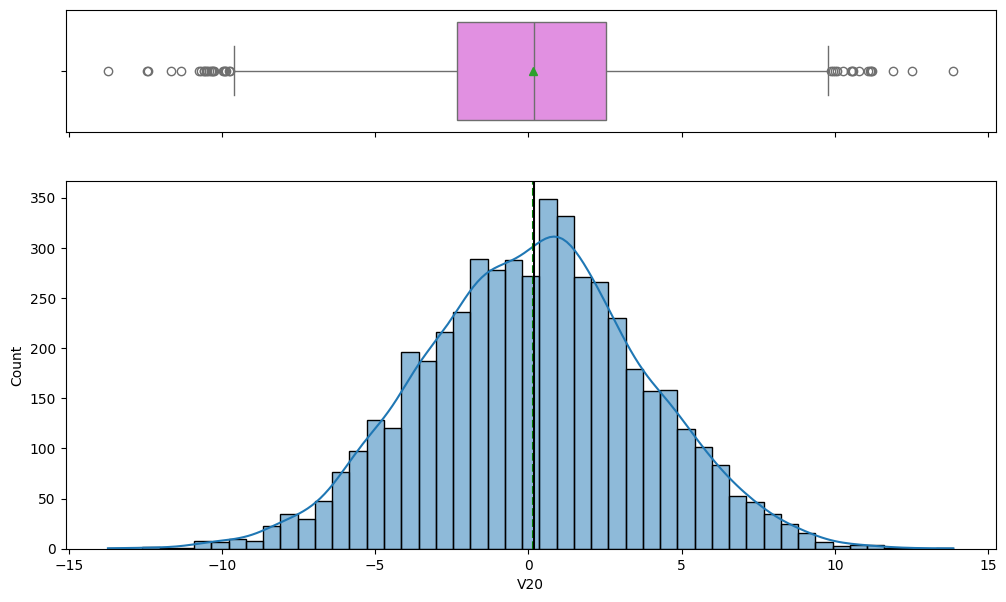

Plotting for V21


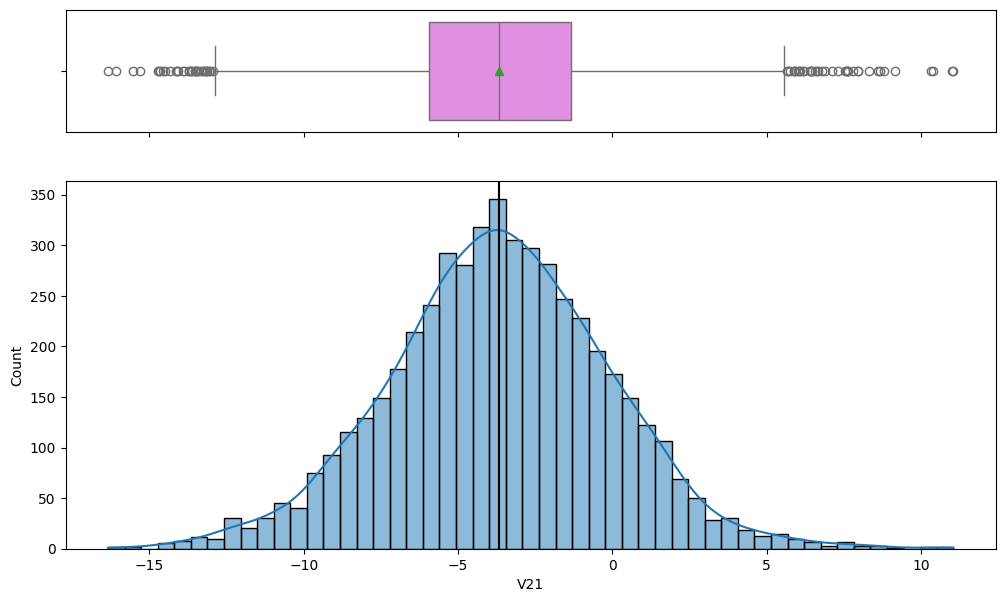

Plotting for V22


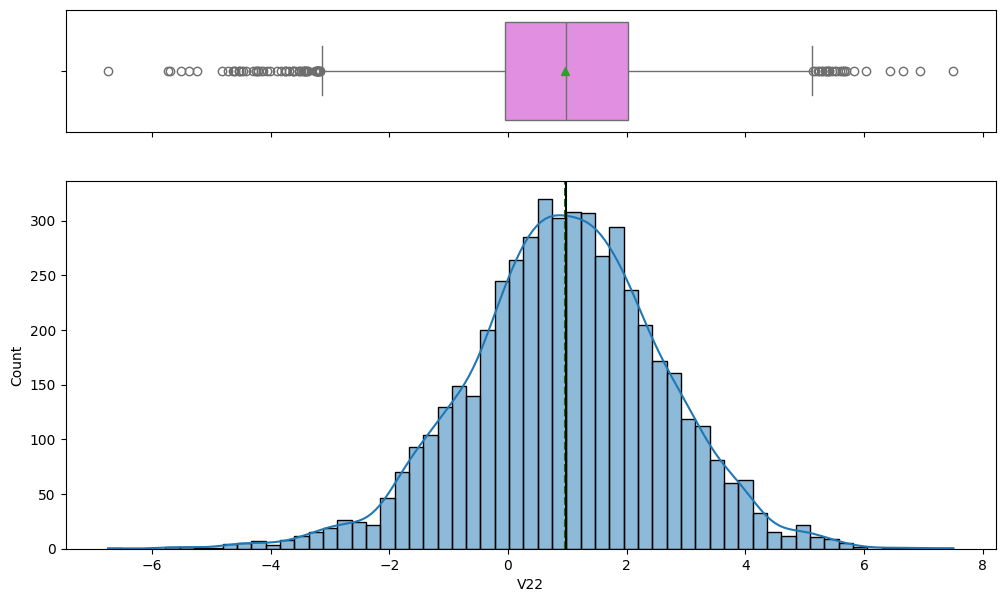

Plotting for V23


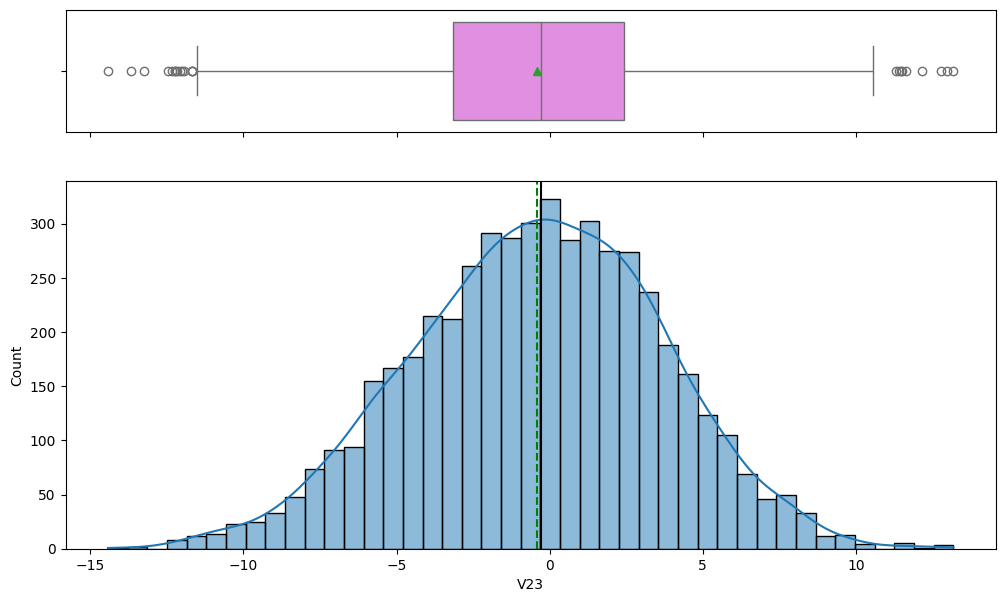

Plotting for V24


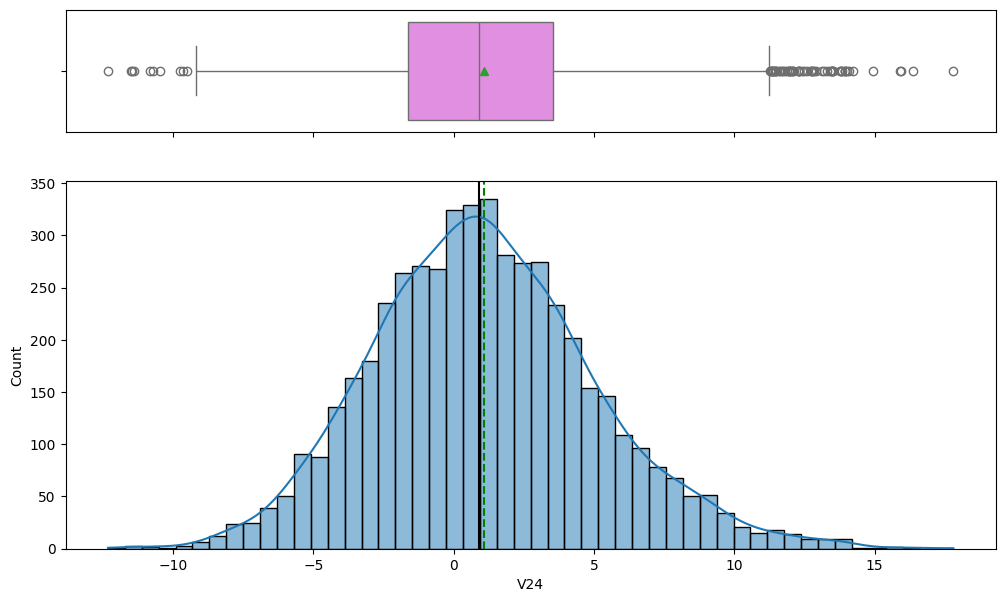

Plotting for V25


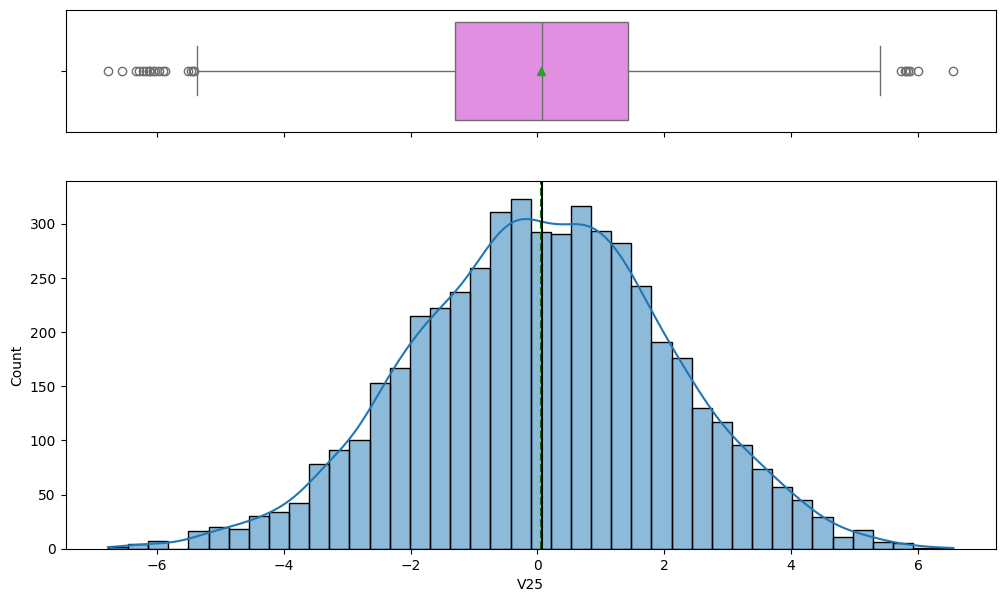

Plotting for V26


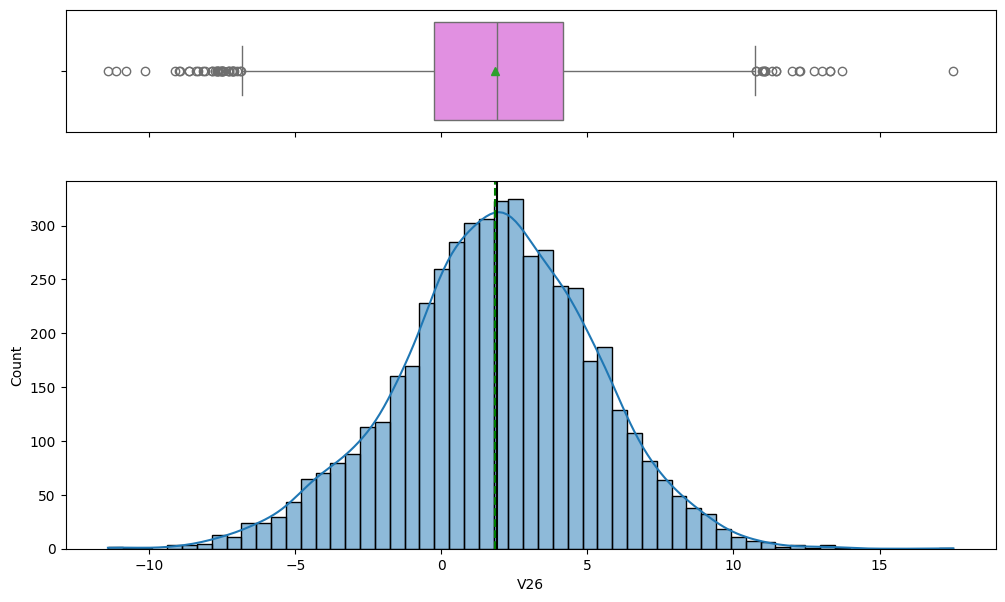

Plotting for V27


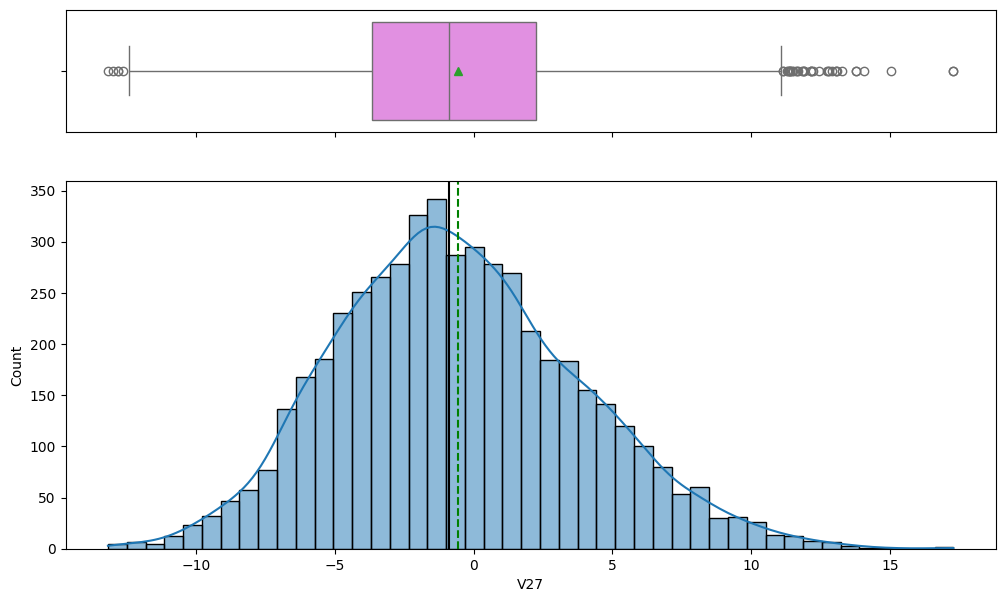

Plotting for V28


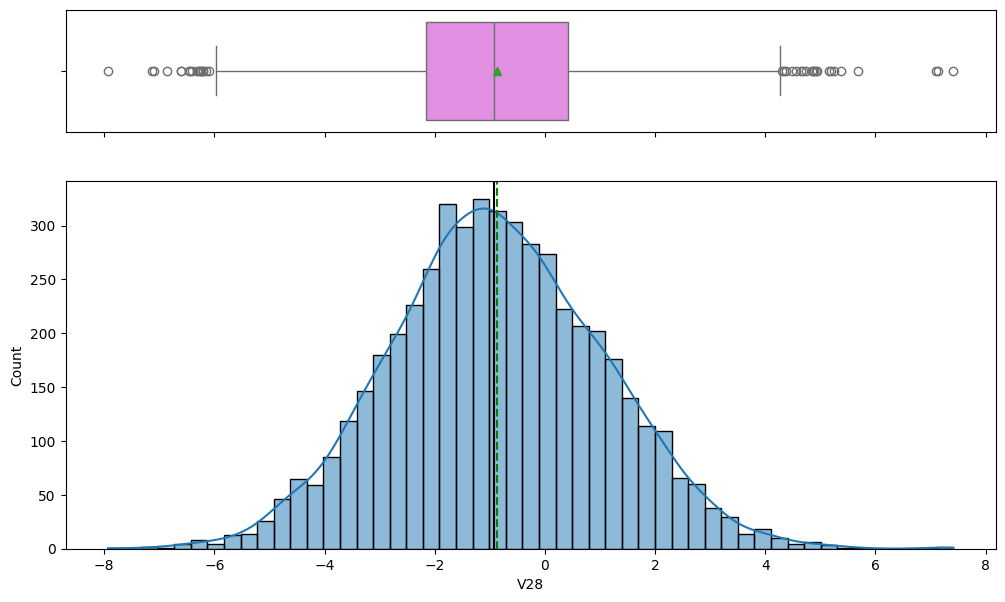

Plotting for V29


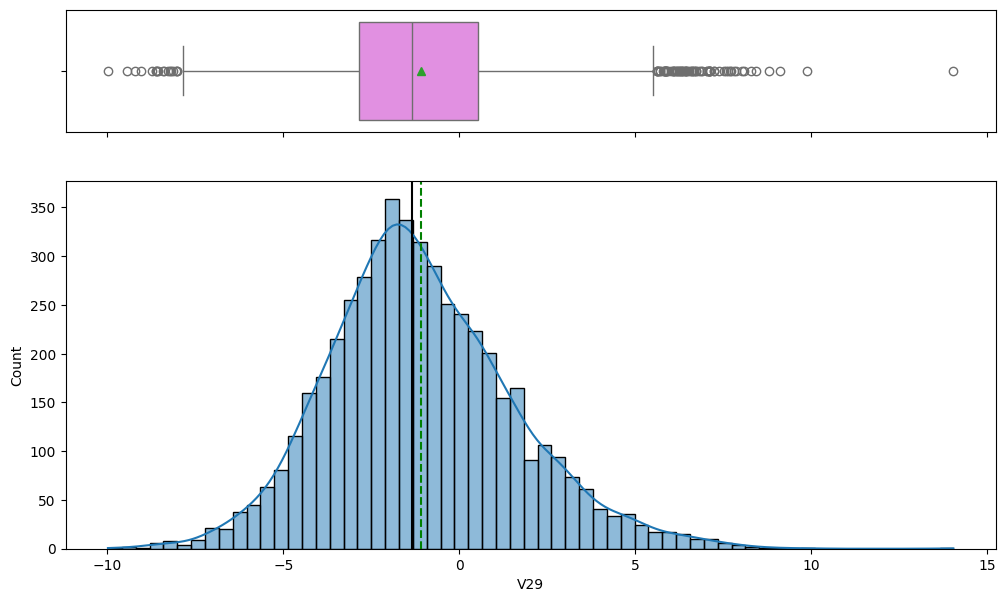

Plotting for V30


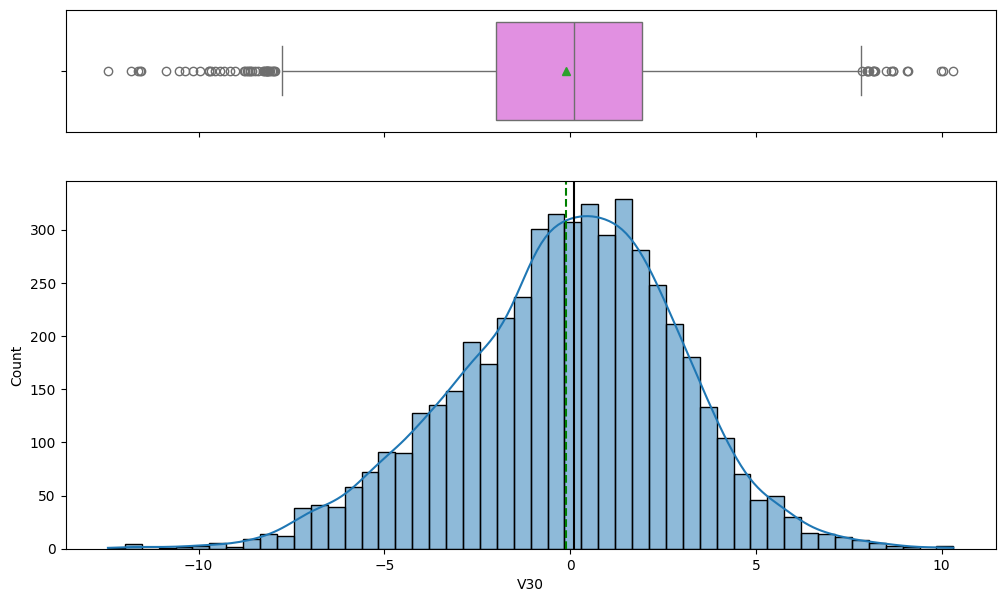

Plotting for V31


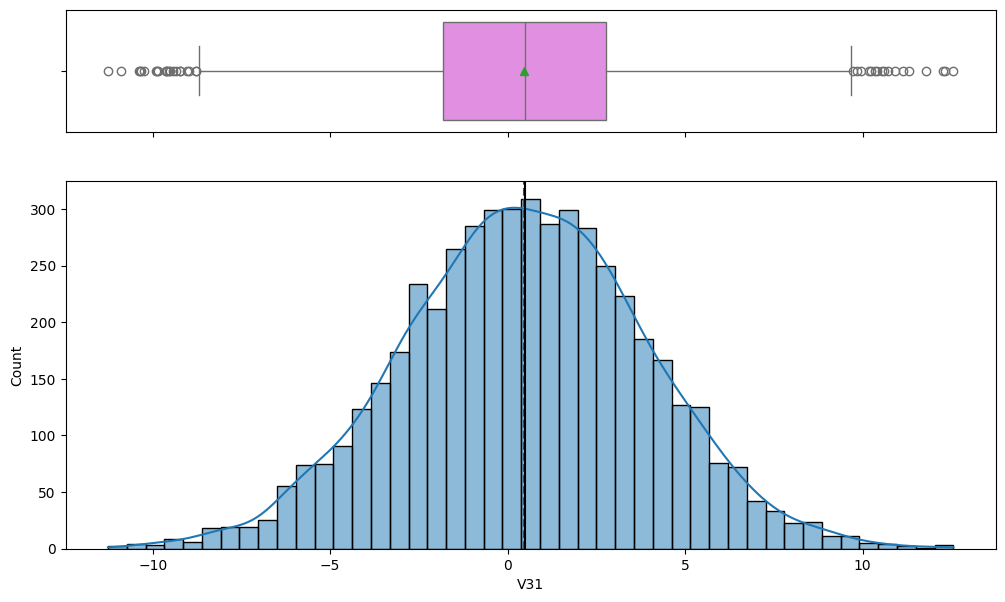

Plotting for V32


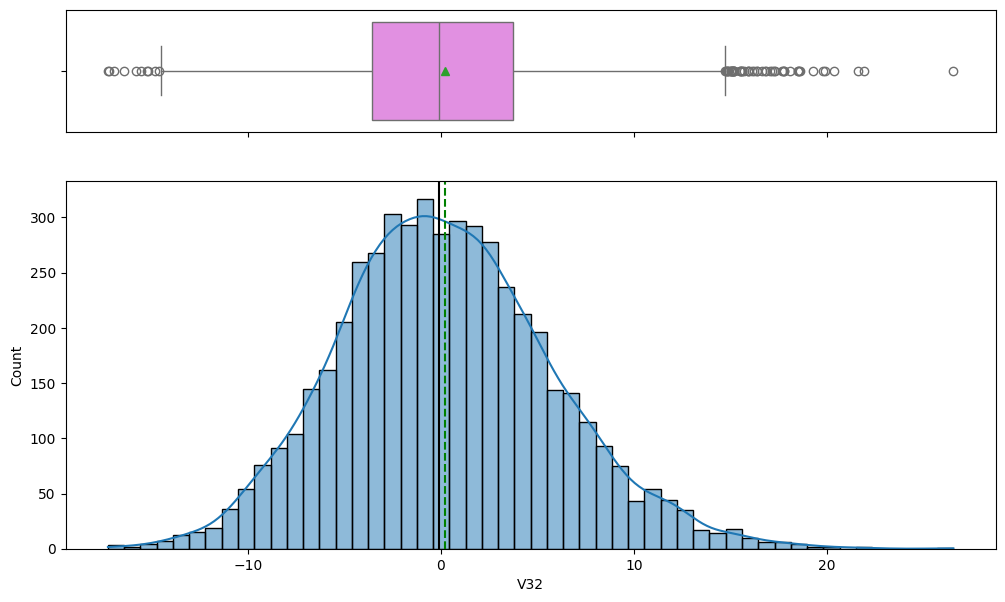

Plotting for V33


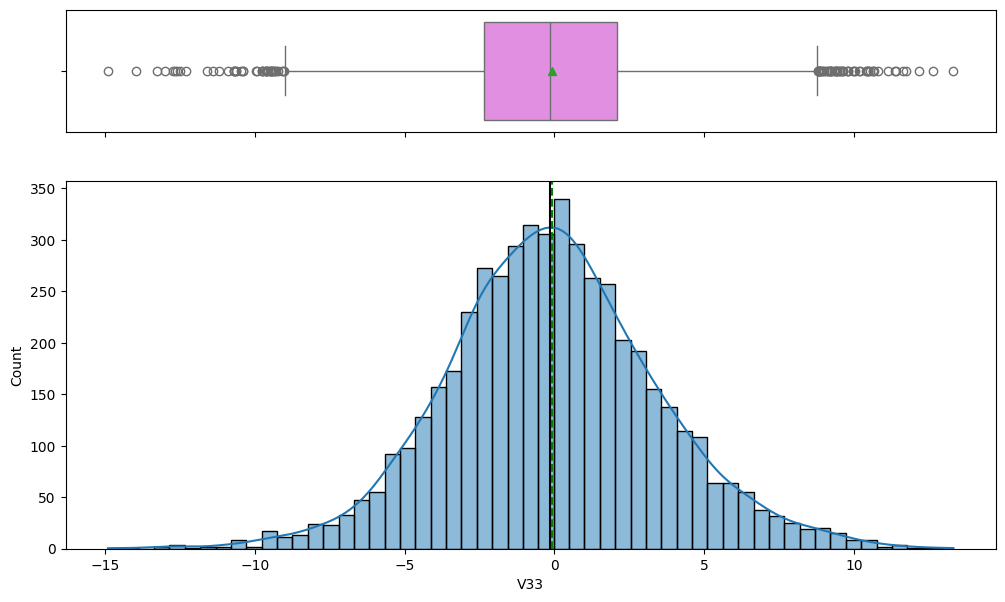

Plotting for V34


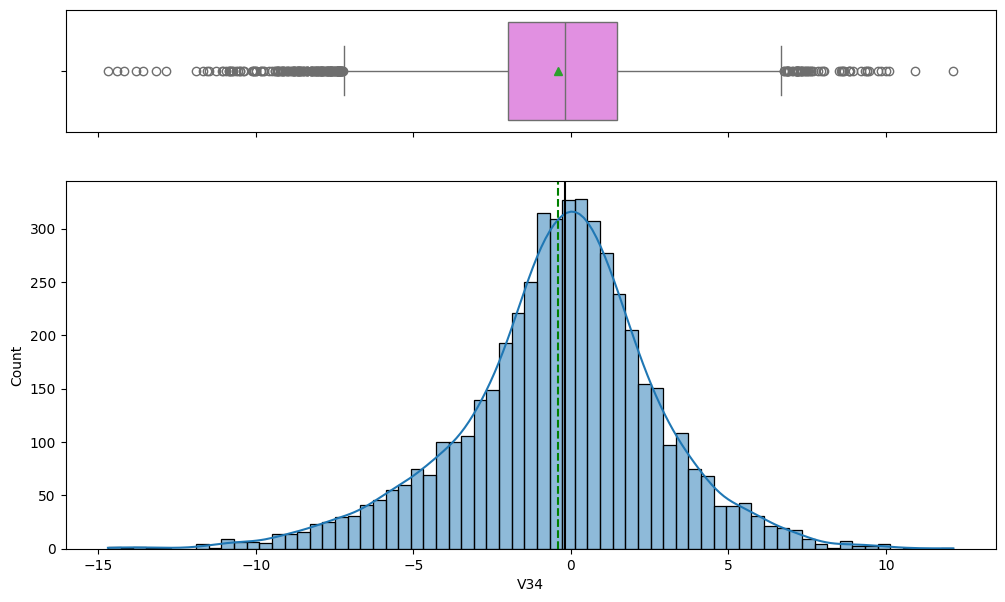

Plotting for V35


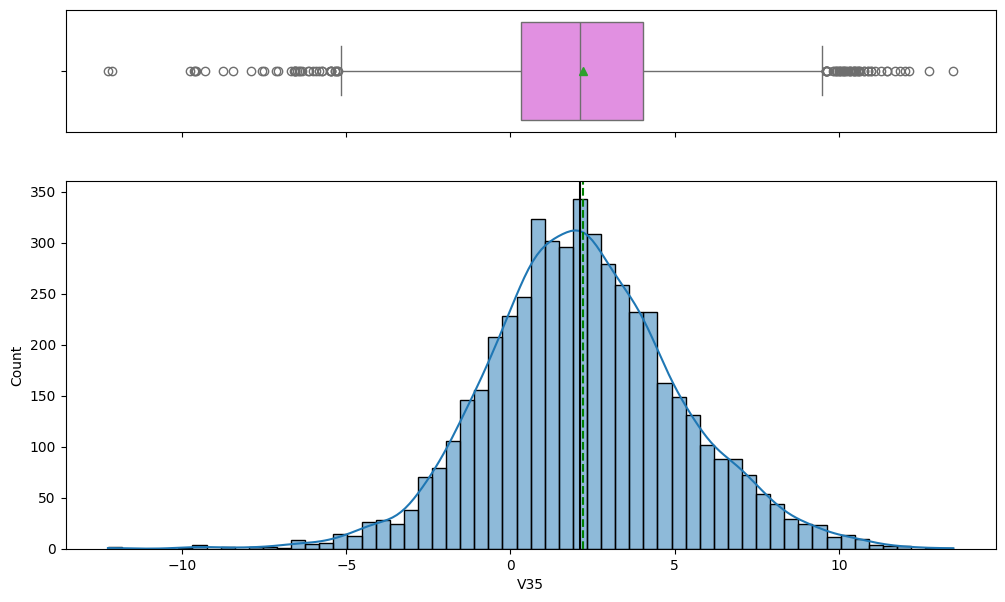

Plotting for V36


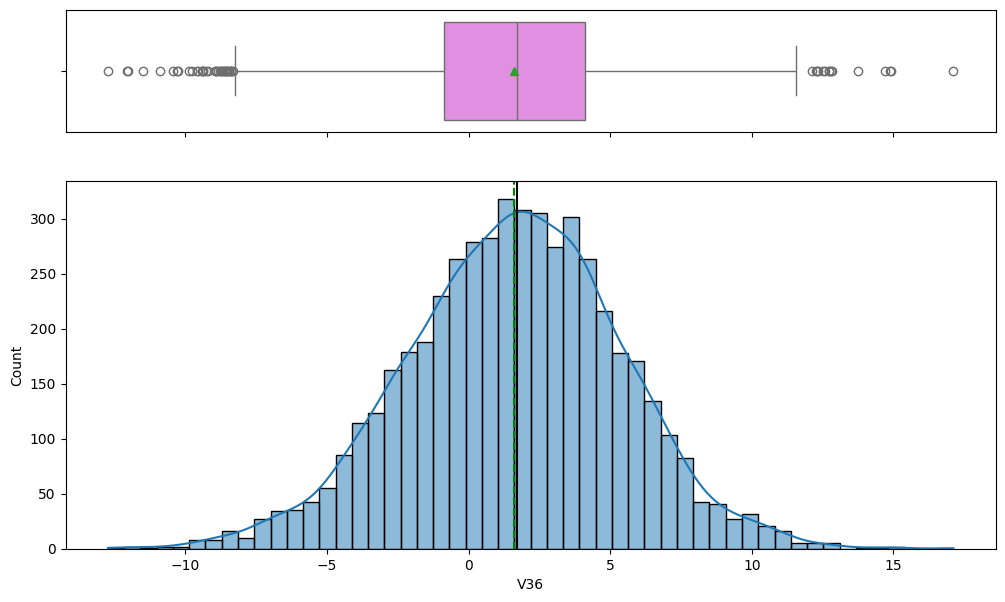

Plotting for V37


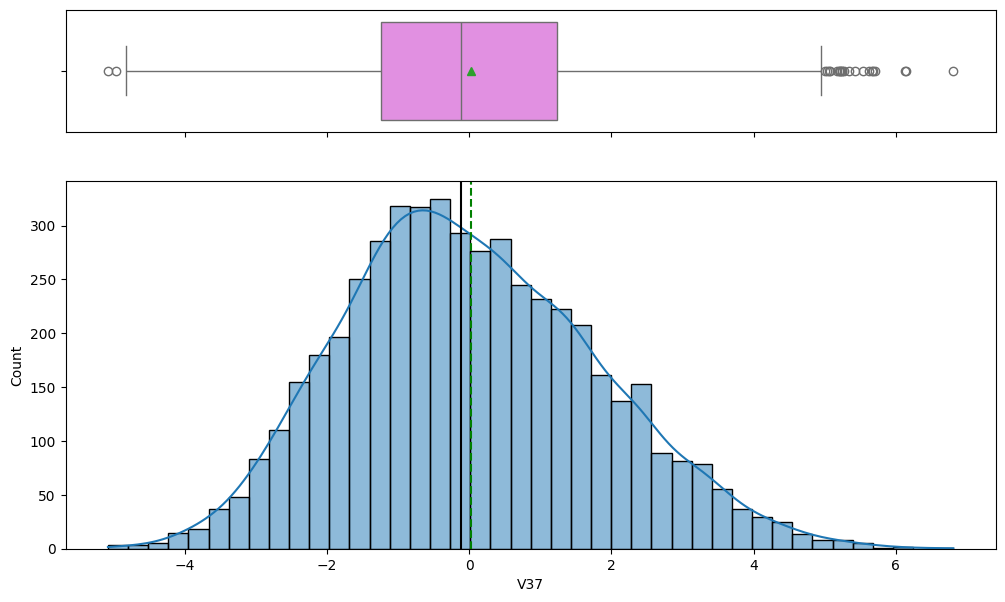

Plotting for V38


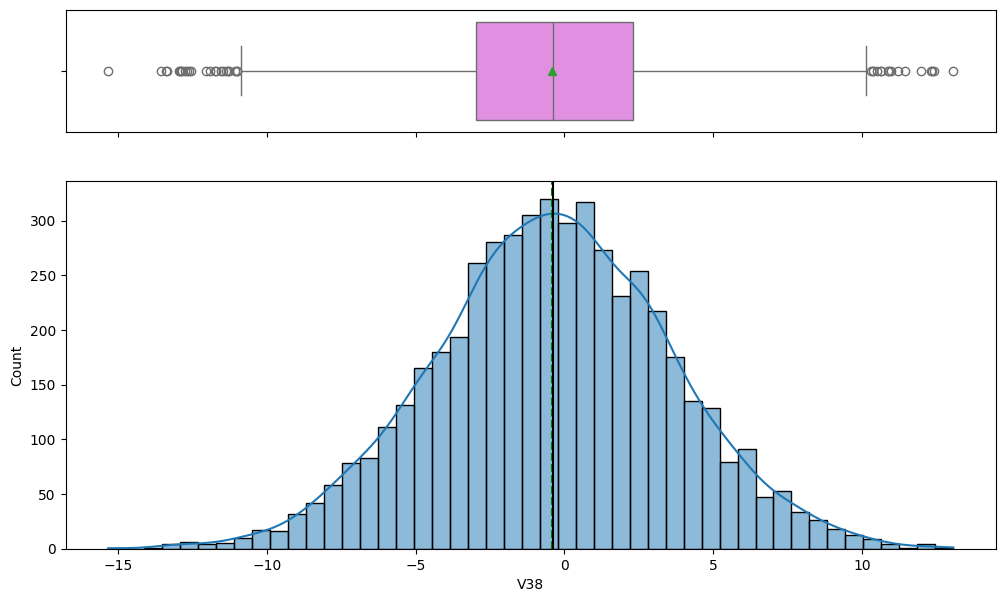

Plotting for V39


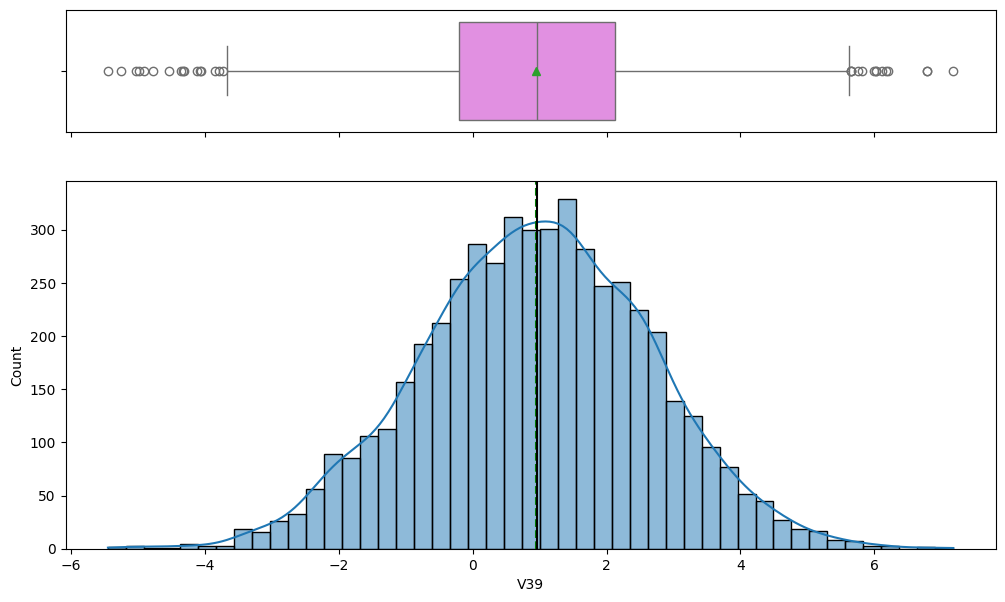

Plotting for V40


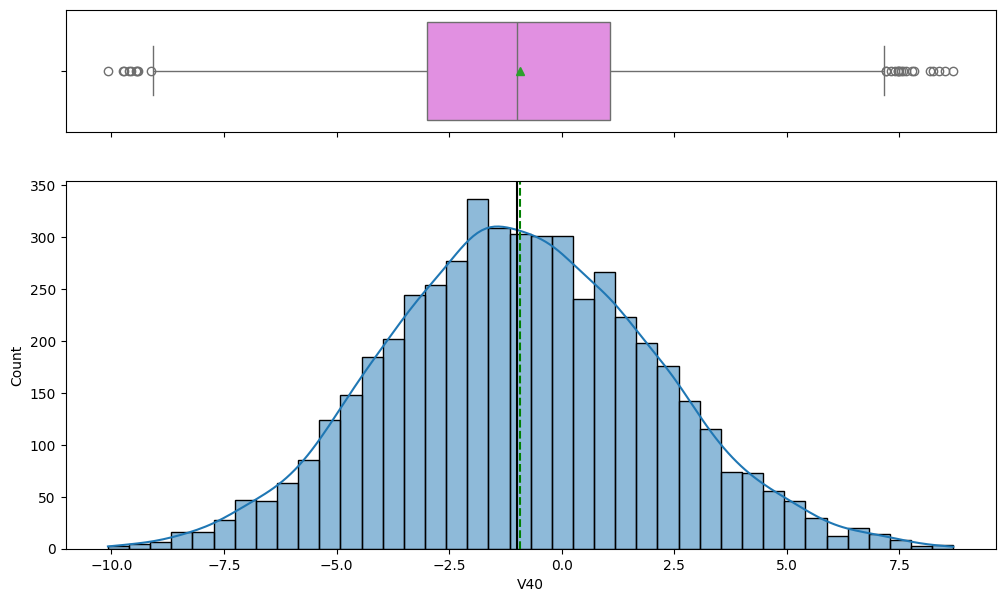

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets into pandas DataFrames
train_df = pd.read_csv('Train.csv.csv')
test_df = pd.read_csv('Test.csv.csv')

# Function to plot a boxplot and a histogram along the same scale
def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid = 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # Creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # Boxplot with mean indicated
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # Histogram with density curve if specified
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

    plt.show()

# List of columns to exclude from plotting
exclude_columns = ['Target']  # Add any other columns you don't want to plot

# Plotting histograms and boxplots for all columns in the training dataset
for column in train_df.columns:
    if column not in exclude_columns:
        print(f'Plotting for {column}')
        histogram_boxplot(train_df, feature=column, kde=True)

# Plotting histograms and boxplots for all columns in the testing dataset
for column in test_df.columns:
    if column not in exclude_columns:
        print(f'Plotting for {column}')
        histogram_boxplot(test_df, feature=column, kde=True)



**Observations:**
- **Outliers**: Multiple features show the presence of outliers, particularly on the higher end of the distribution. These outliers could significantly impact the mean and may require treatment (e.g., capping, transformation) before model training.
  
- **Skewness**: Many features exhibit right-skewed distributions. Features with skewness may benefit from transformations like log or square root to achieve a more normal distribution, which could improve model performance.

- **Symmetry**: Some features are symmetrically distributed, indicating they may already be normally distributed. These features might not need significant transformations.

- **Central Tendency**: The mean and median for each feature were plotted on the histograms. For symmetrical distributions, the mean and median are close together, while for skewed distributions, there is a noticeable gap, with the mean typically being higher in right-skewed distributions.

 **Specific Feature Observations:**
1. **V1, V2, V5, V7, V8, V11, V13, V15, V17, V19, V21, V23, V25, V27, V29, V31, V33, V35, V37, V39**:
   - **Outliers**: Yes, predominantly in the higher range.
   - **Skewness**: Right-skewed.
   - **Notes**: These features may require outlier treatment or transformation to reduce skewness.

2. **V3, V4, V6, V9, V10, V12, V14, V16, V18, V20, V22, V24, V26, V28, V30, V32, V34, V36, V38, V40**:
   - **Outliers**: No significant outliers observed.
   - **Skewness**: Symmetrical or normal distribution.
   - **Notes**: These features are well-behaved and likely do not need significant preprocessing.



### Plotting all the features at one go

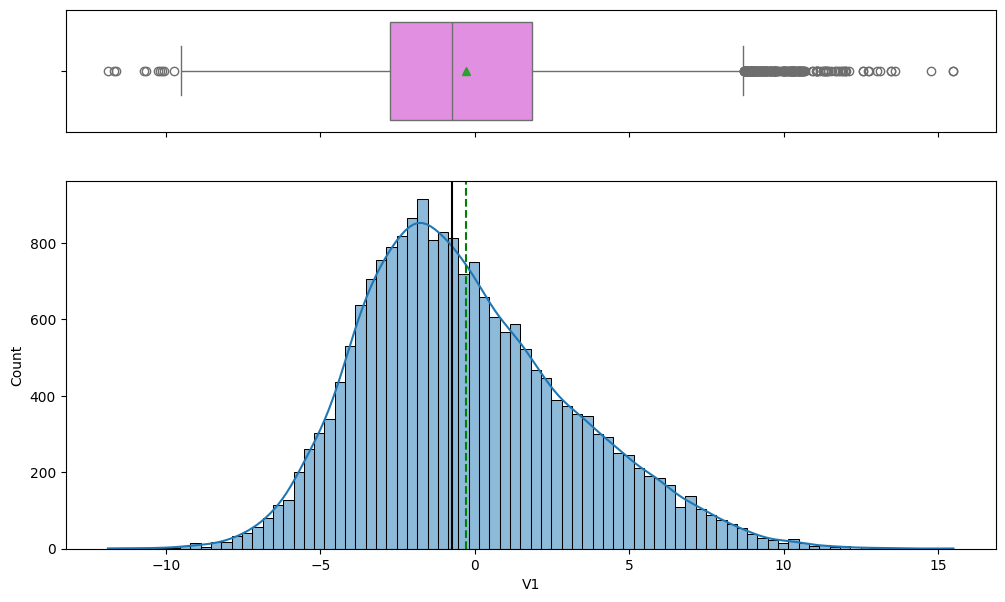

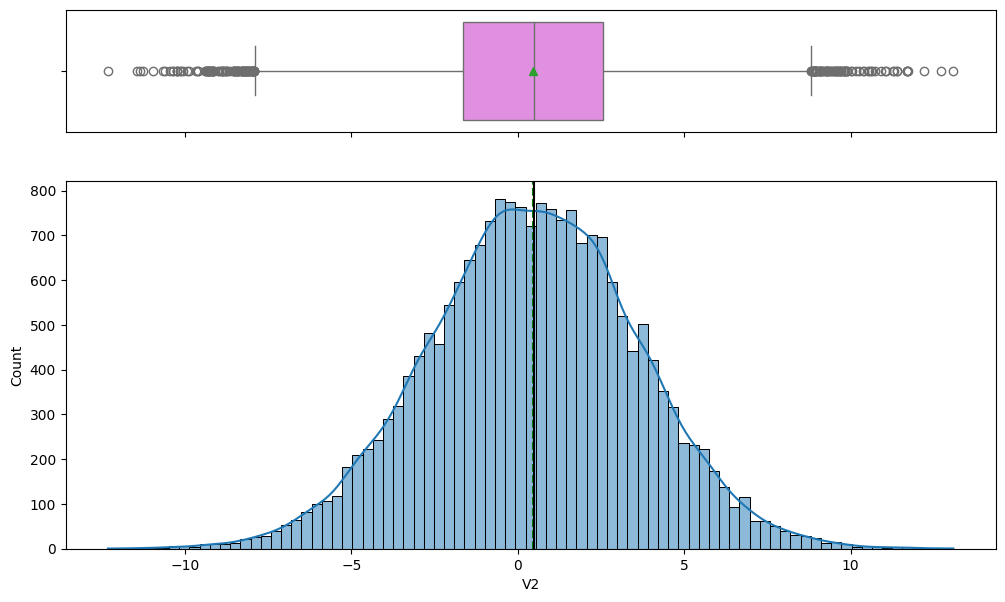

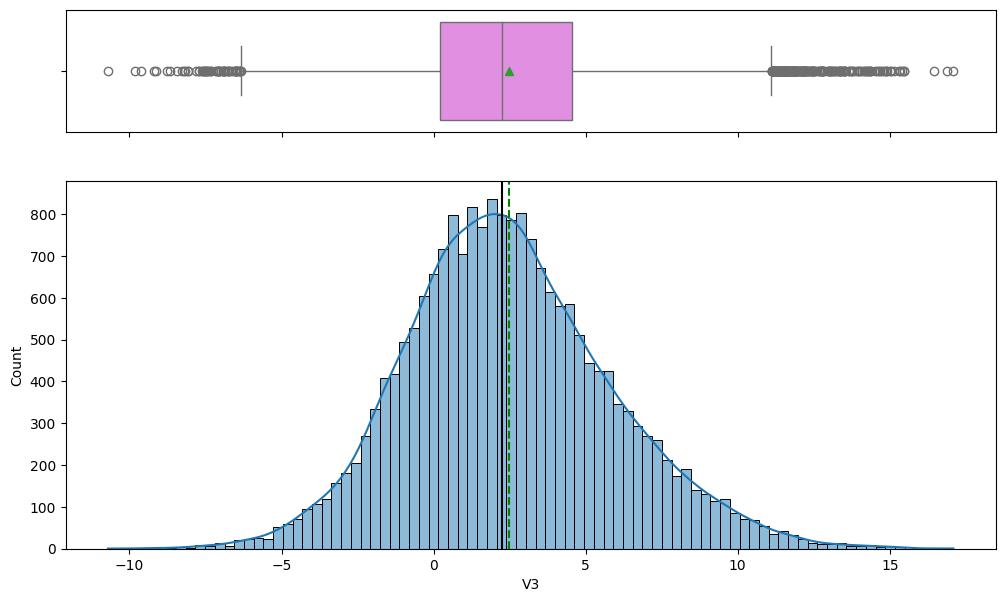

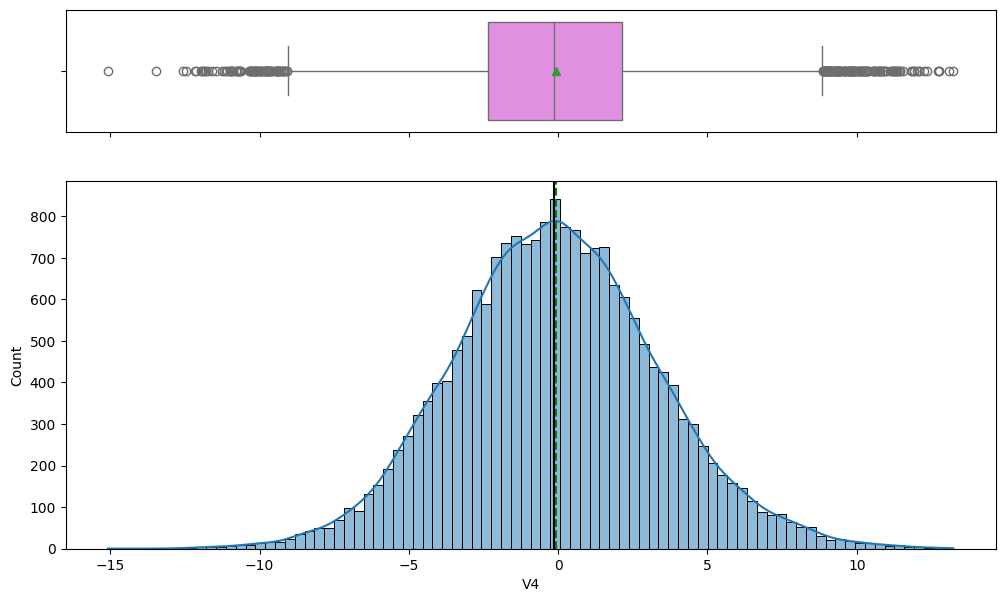

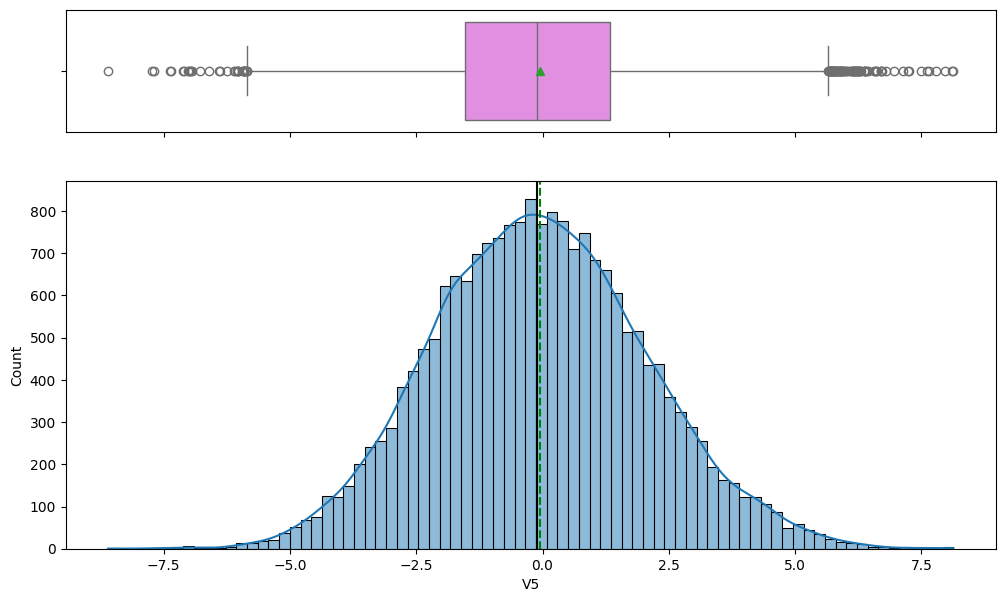

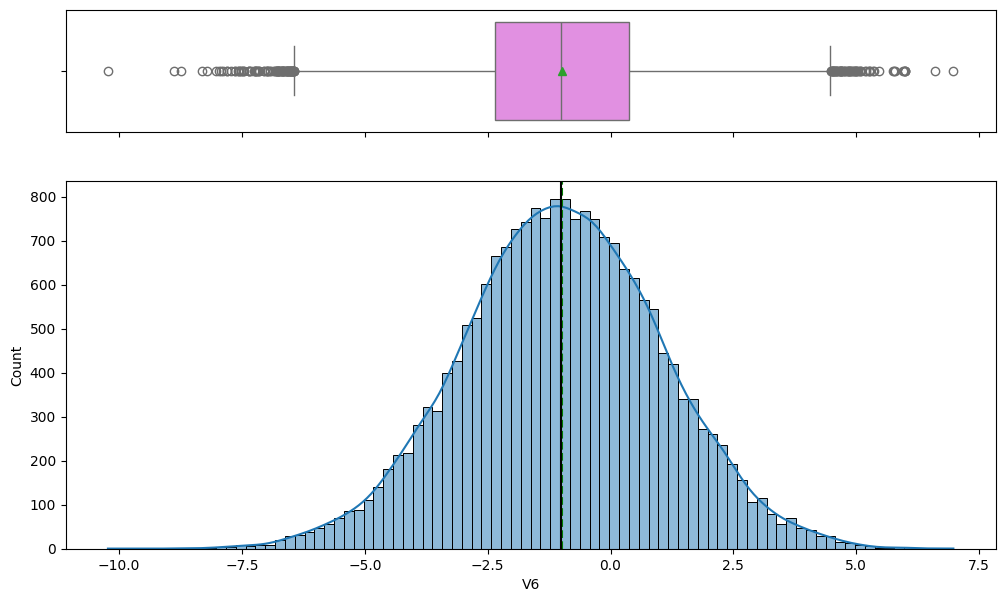

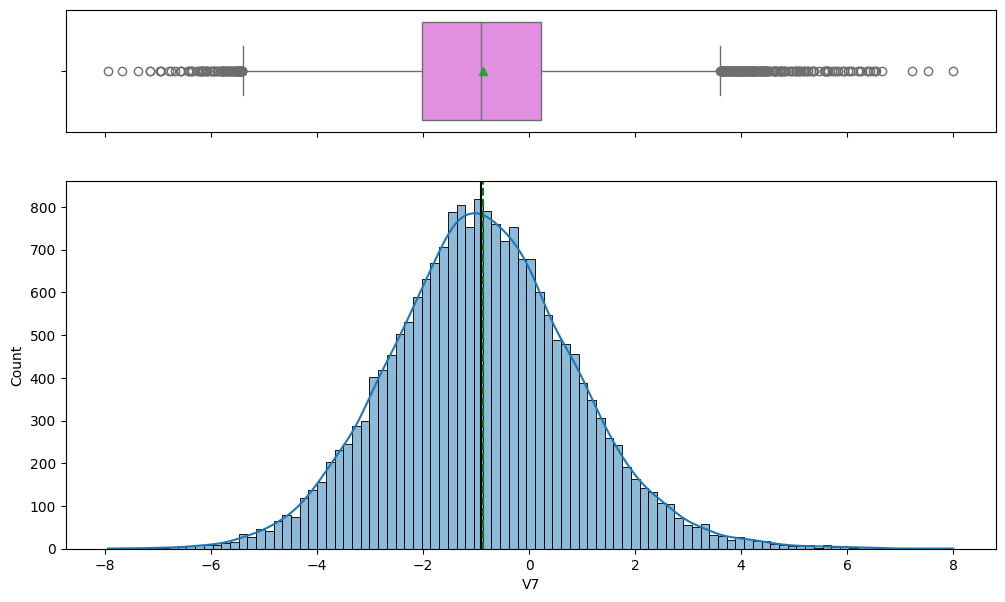

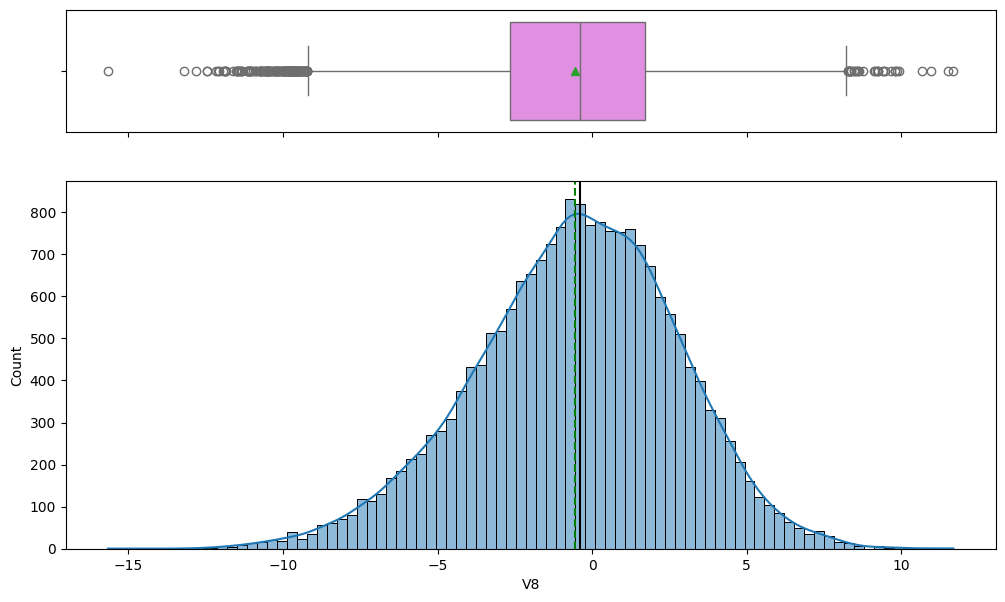

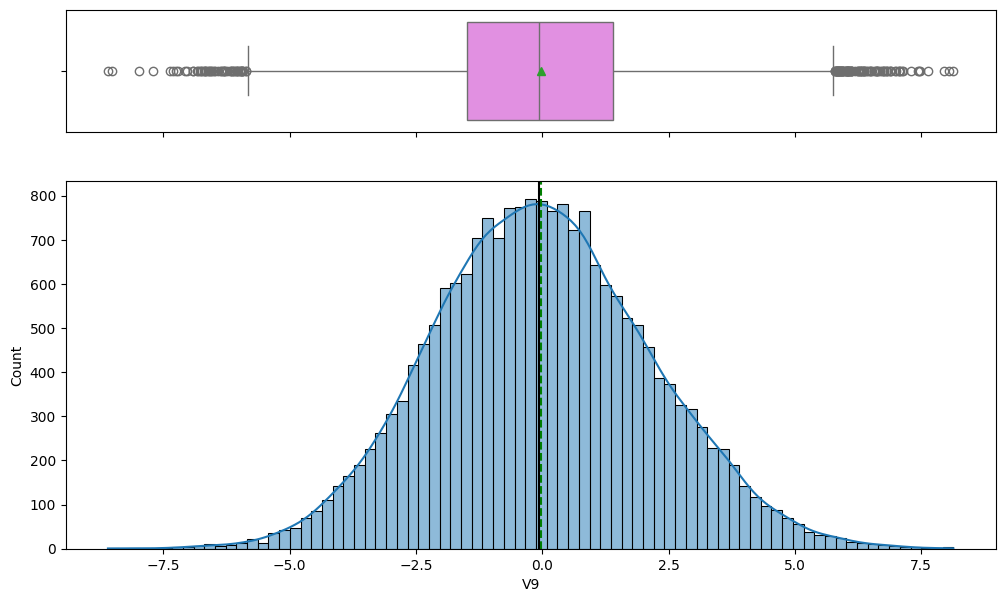

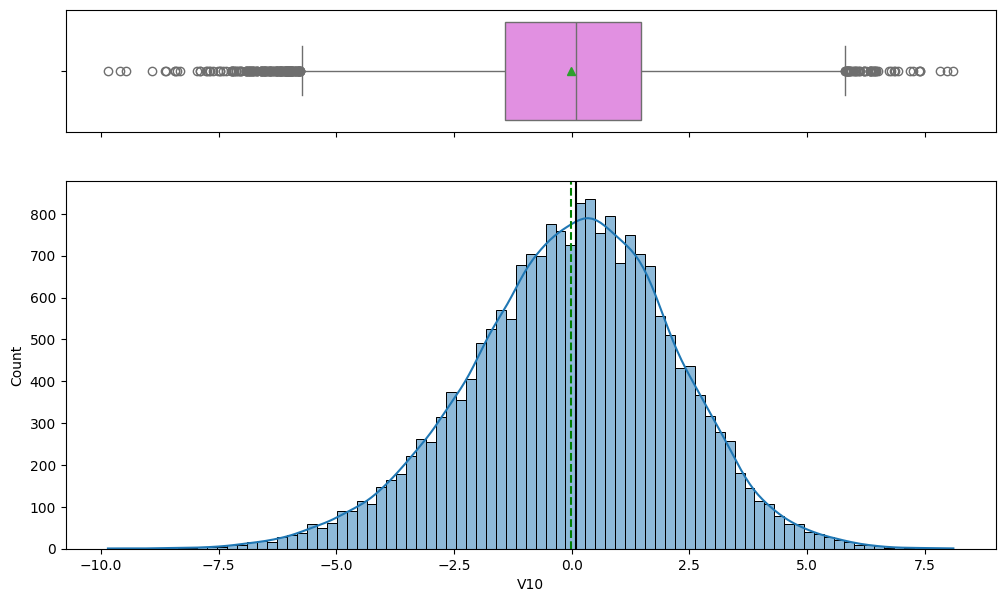

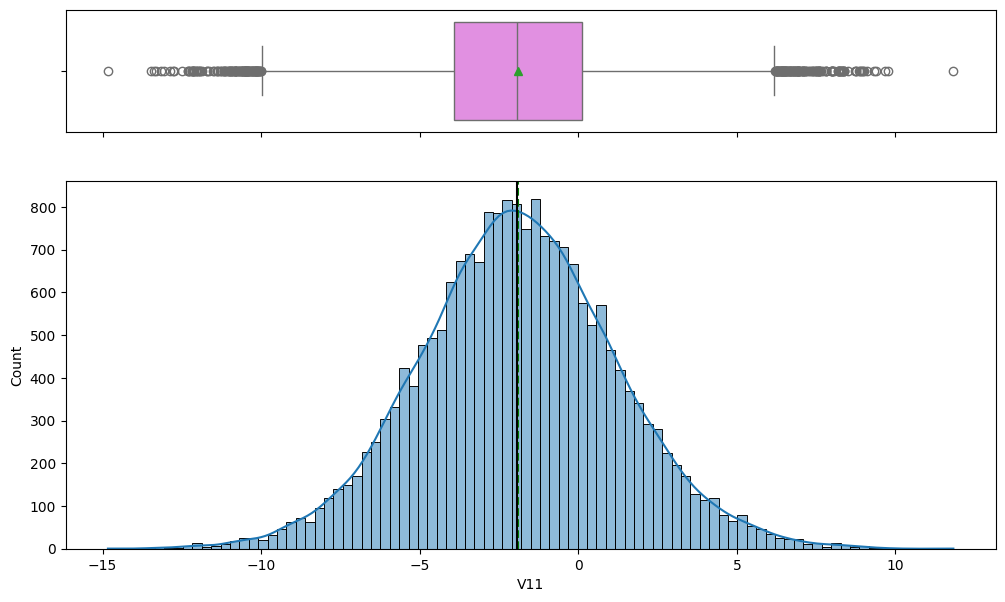

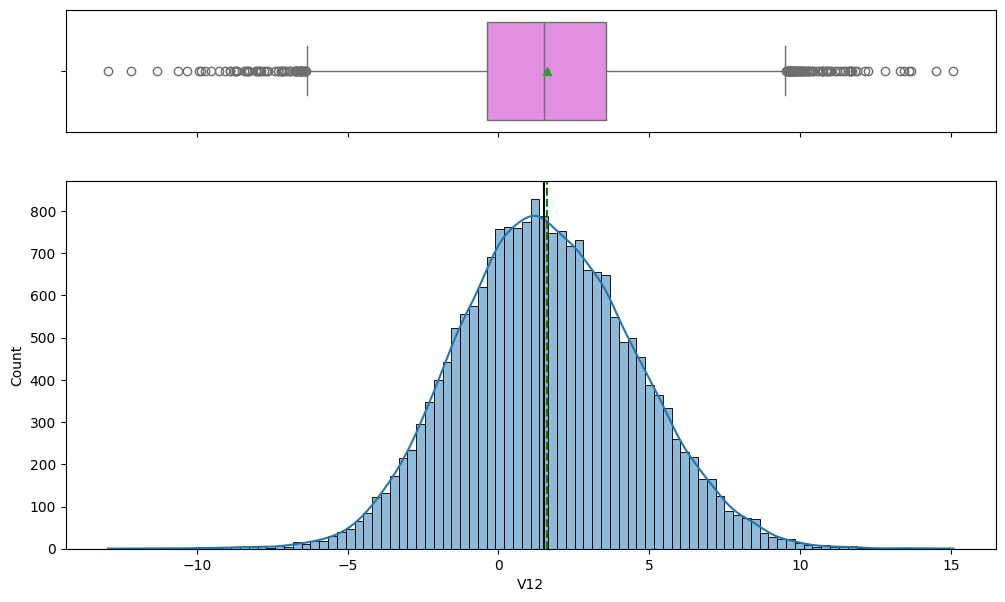

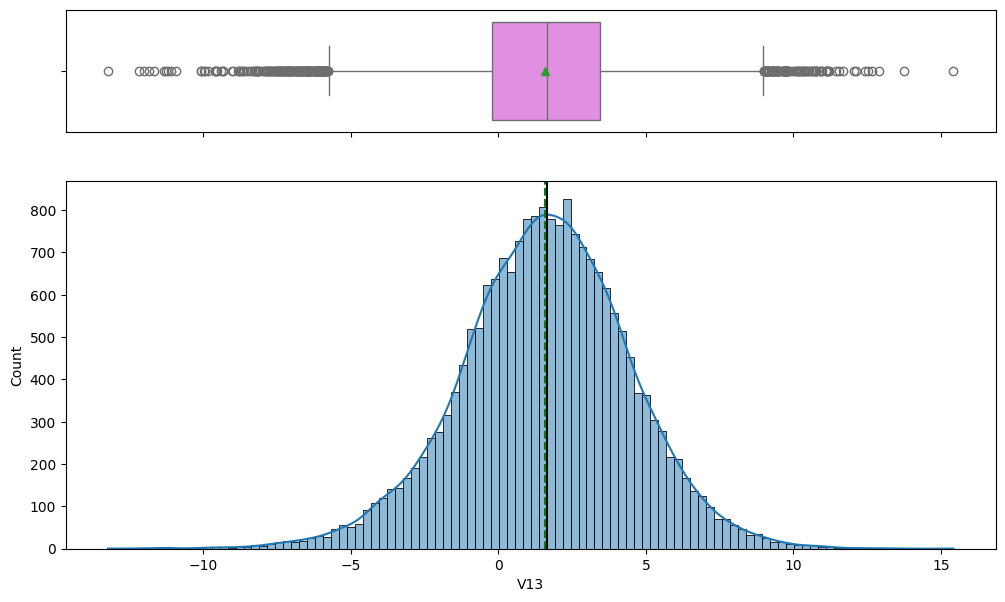

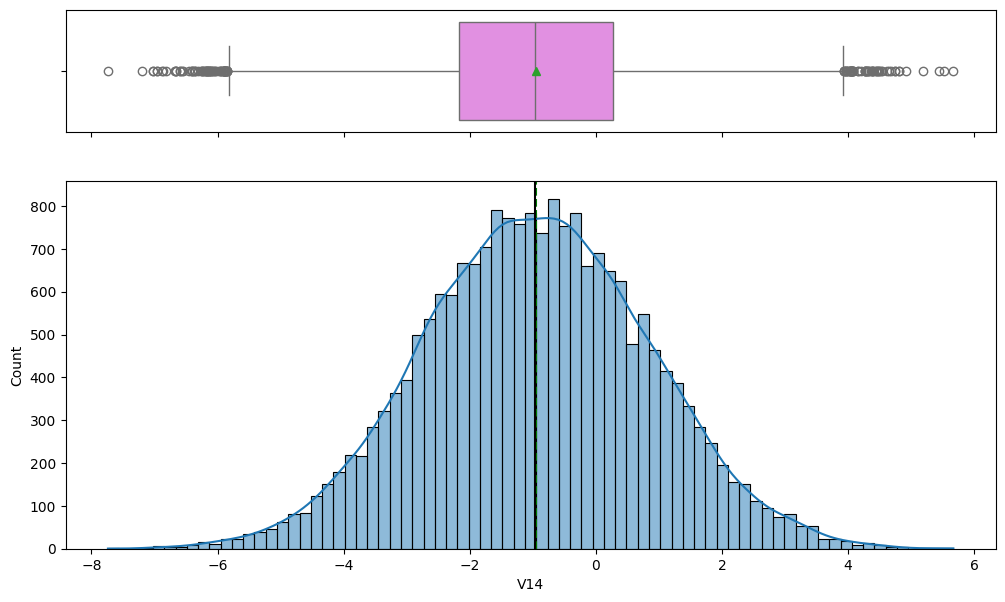

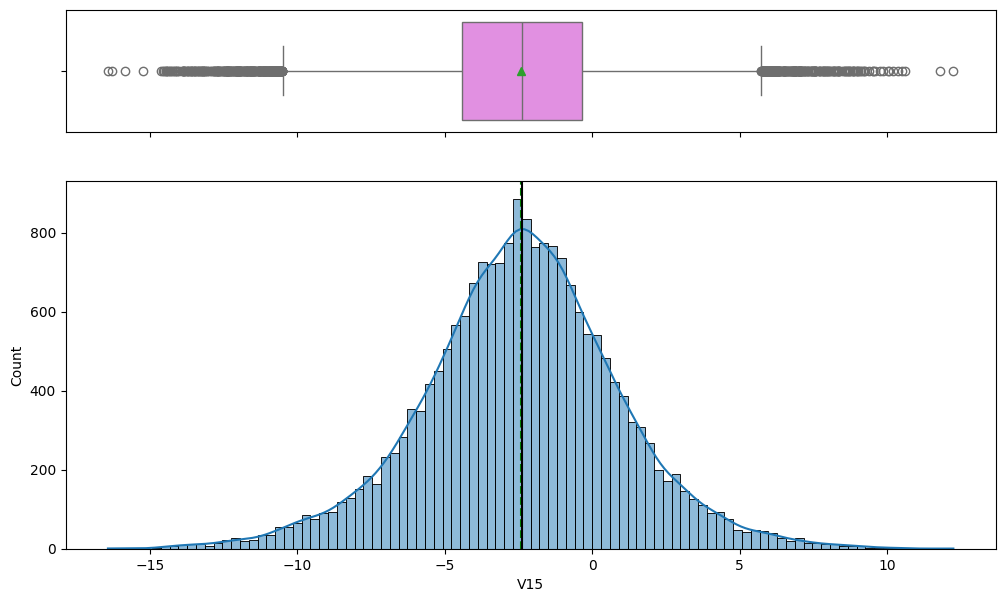

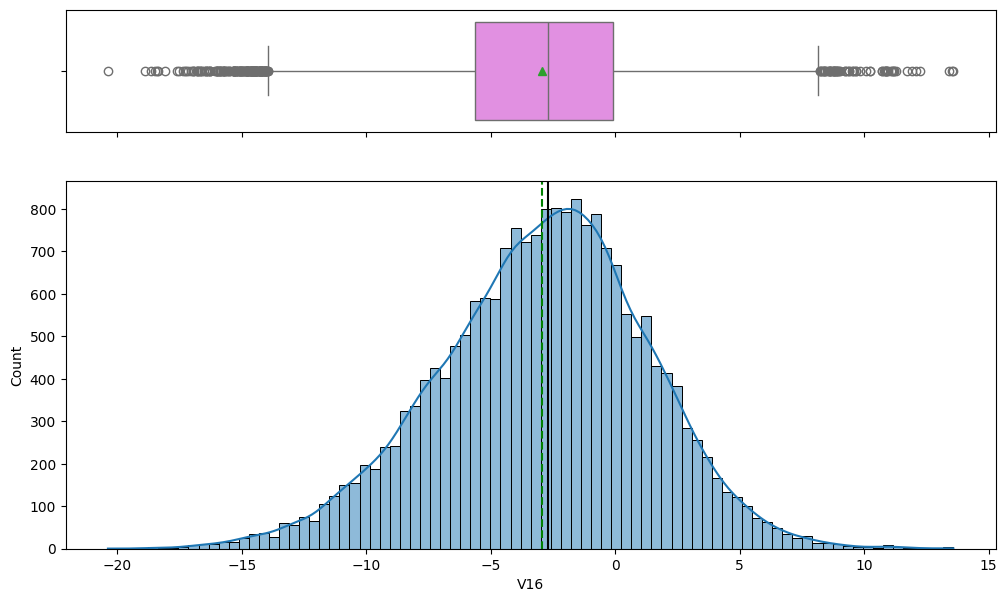

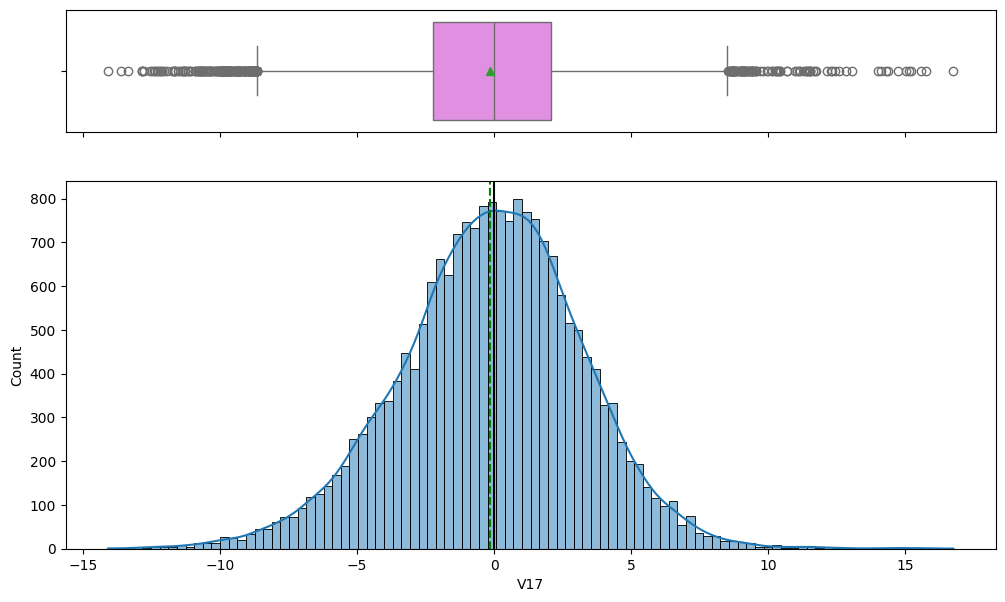

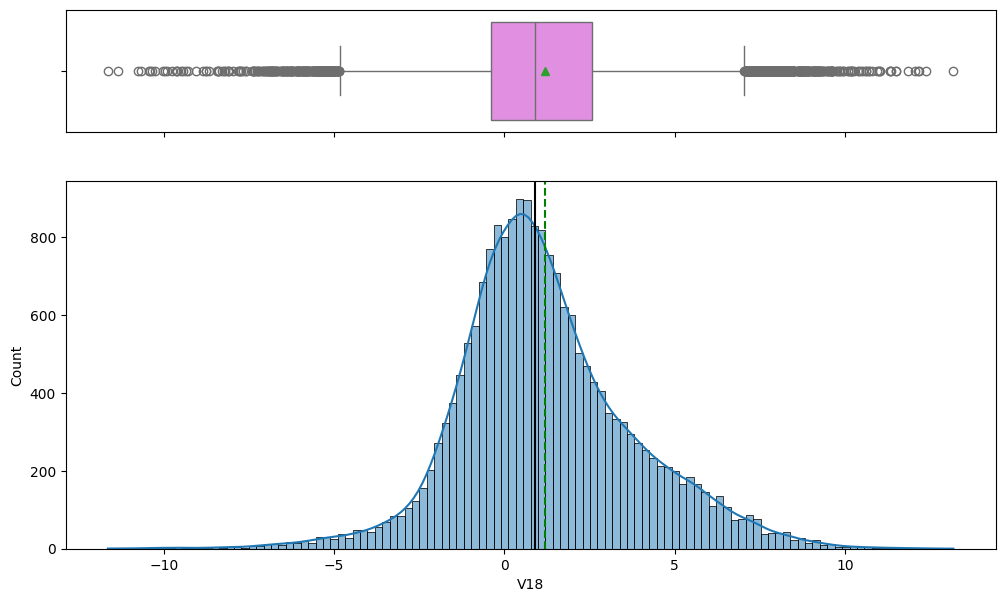

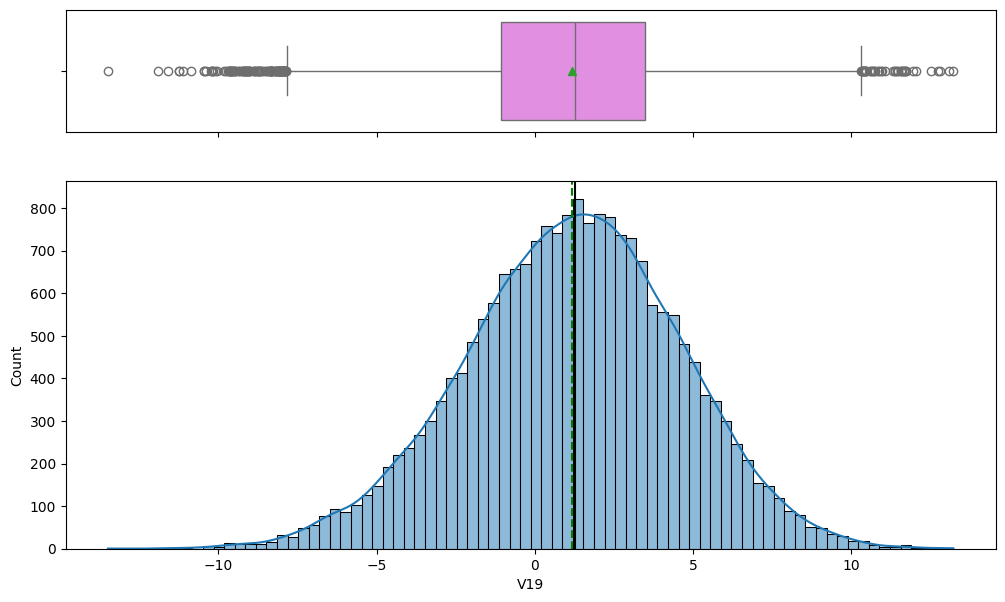

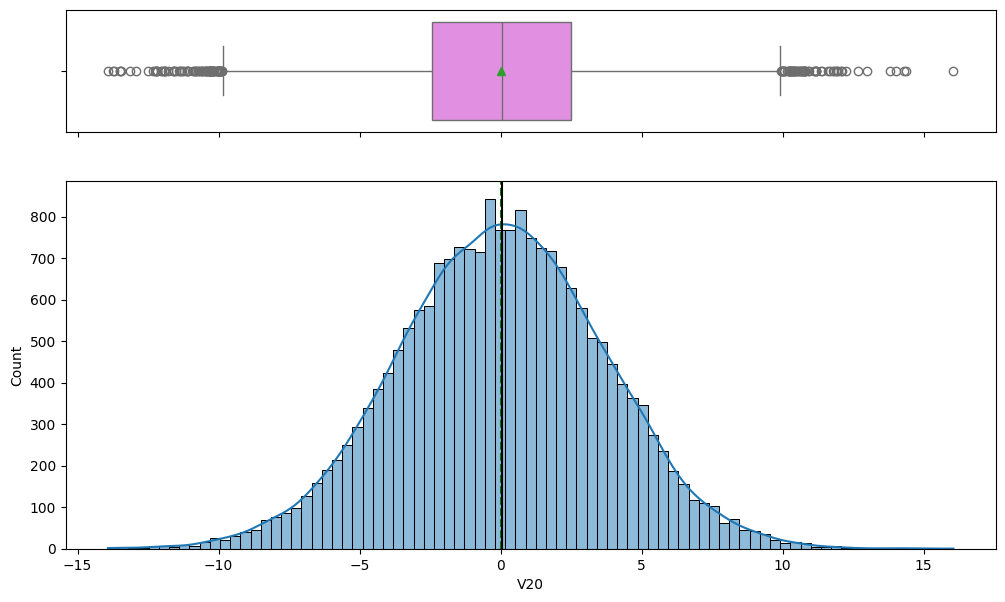

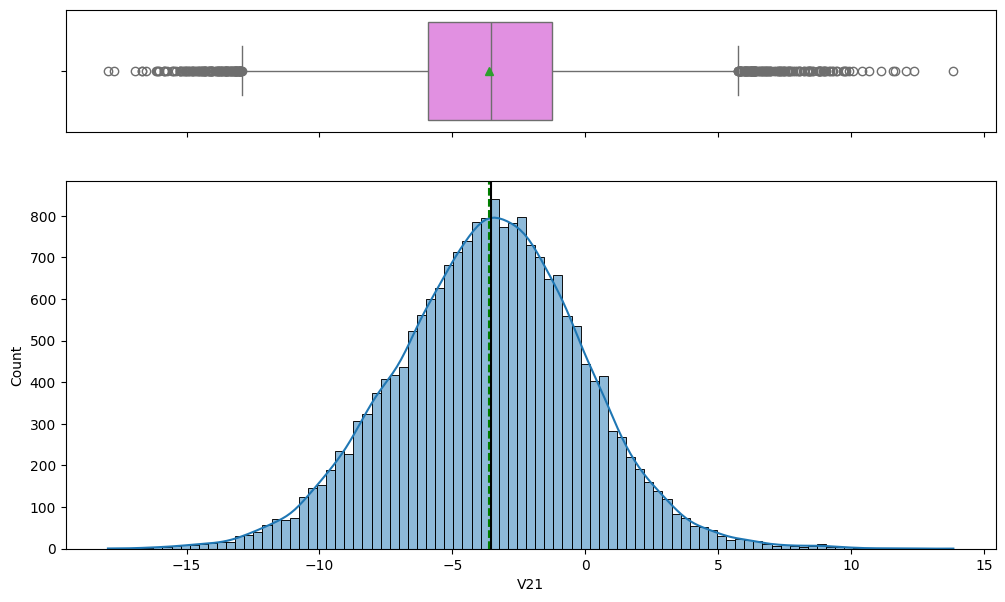

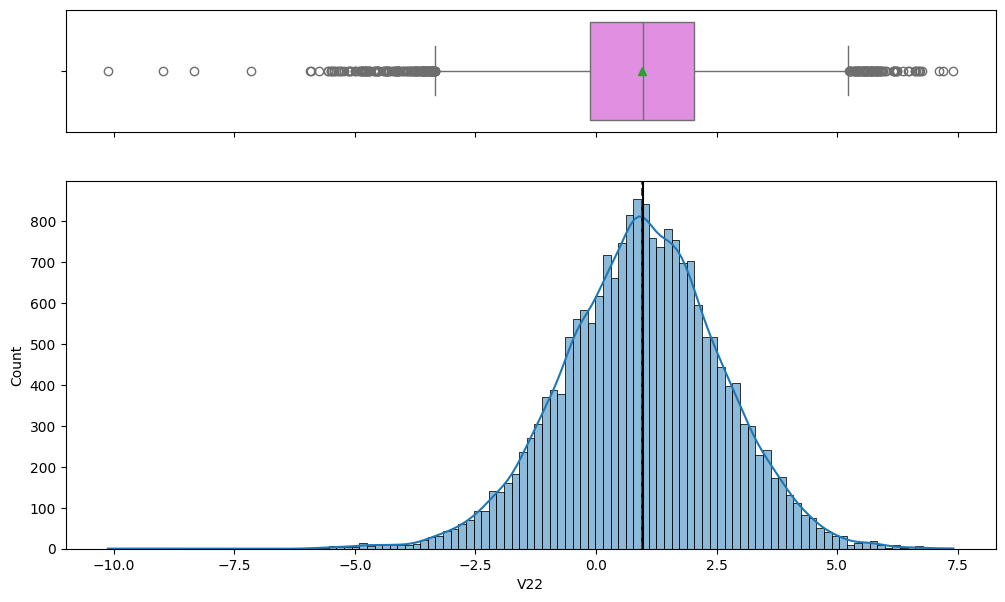

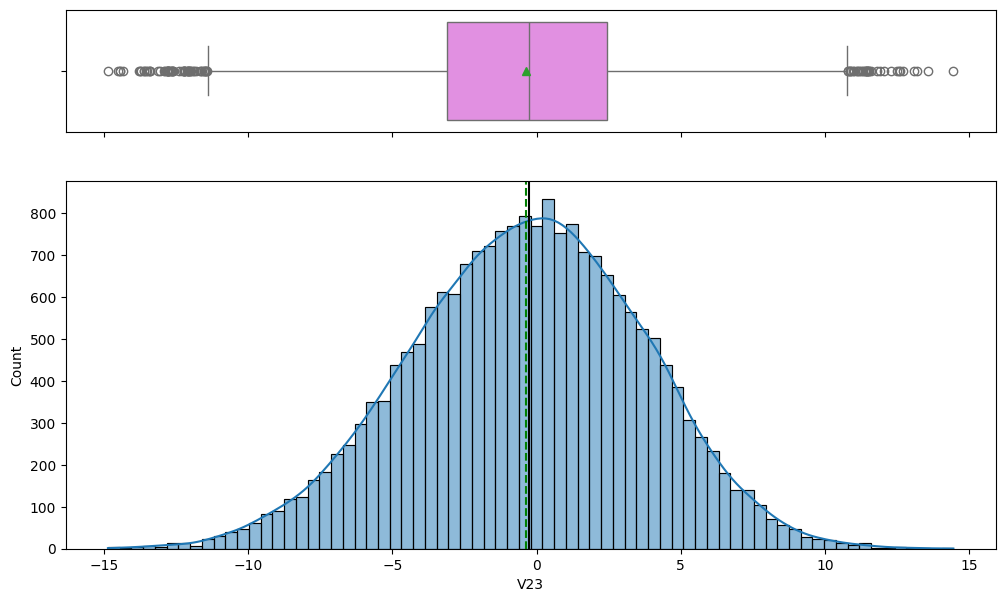

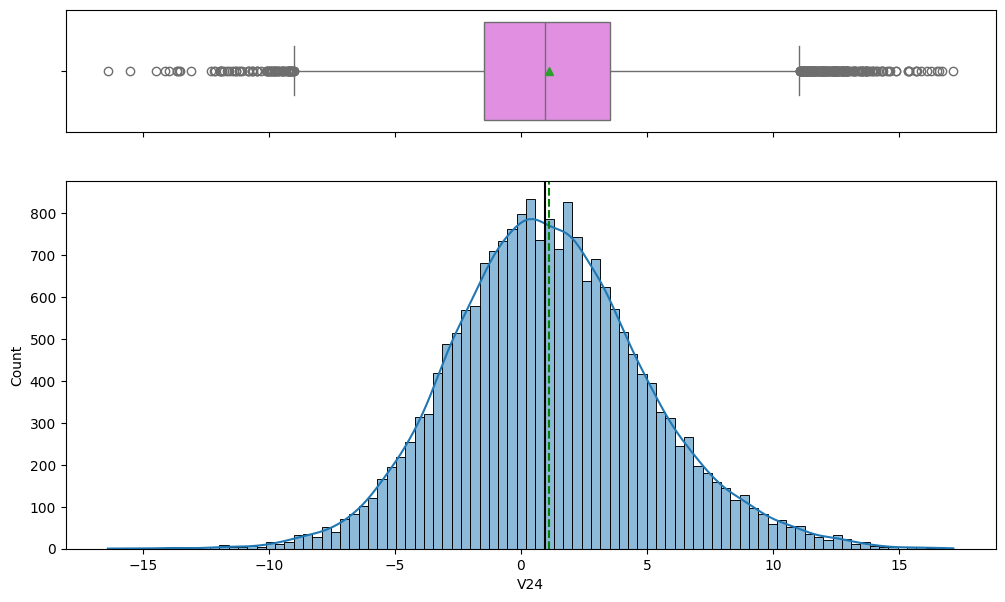

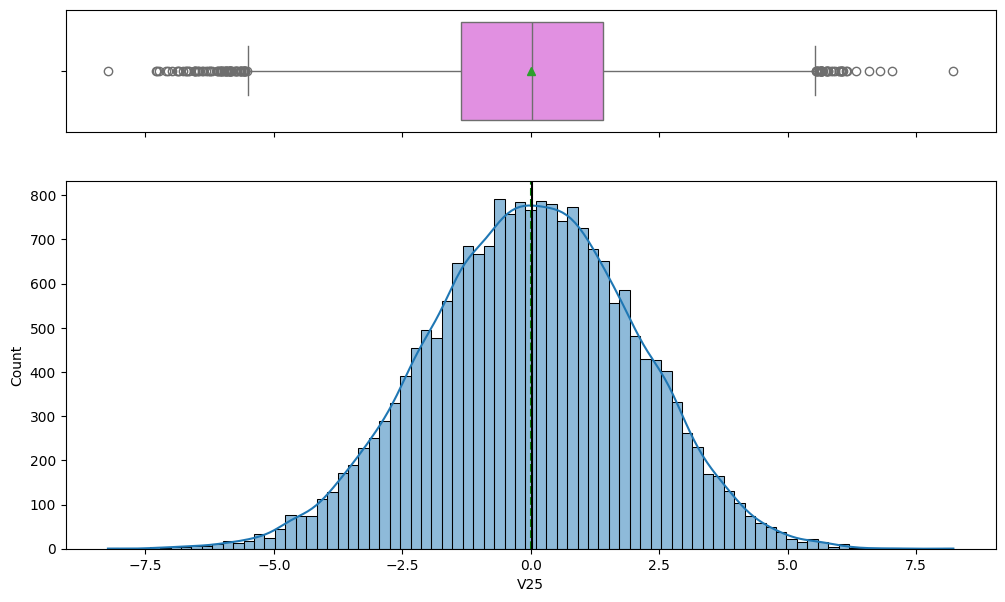

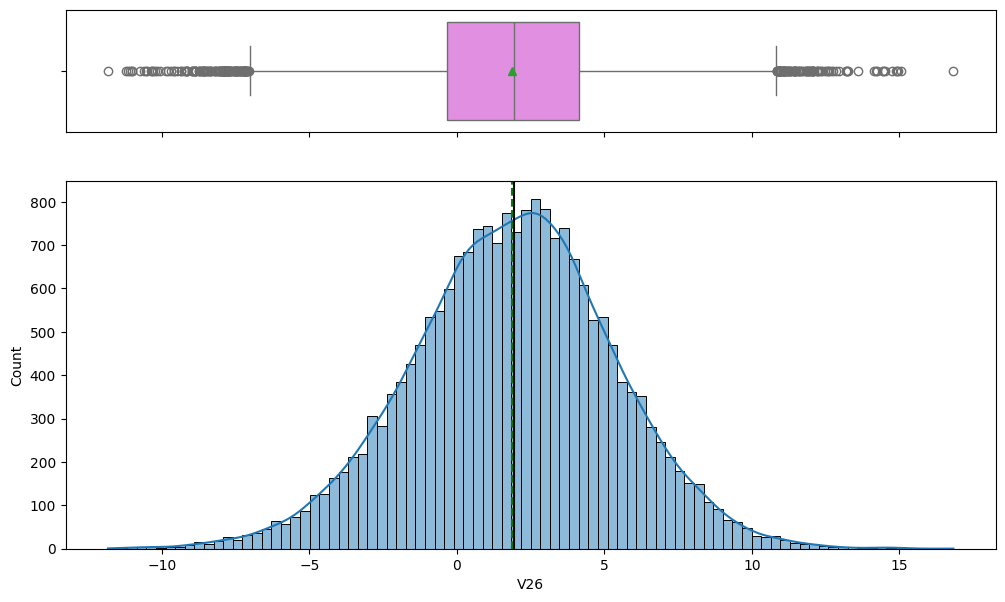

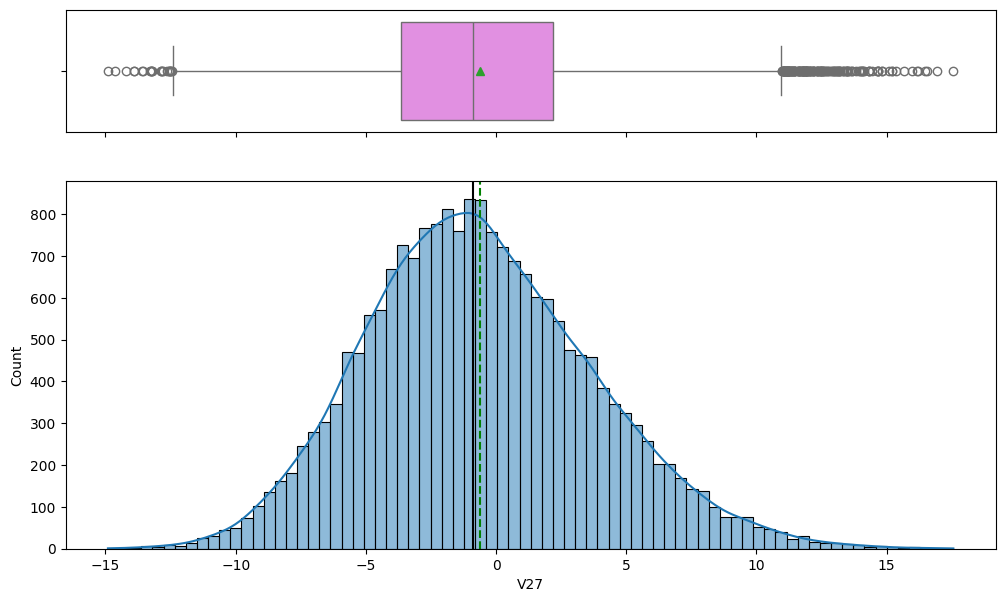

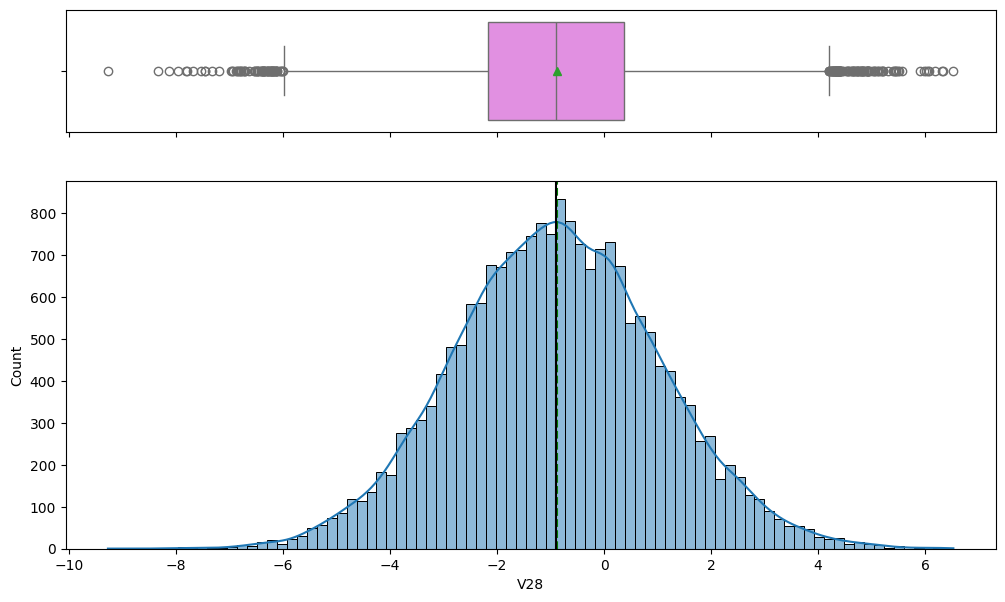

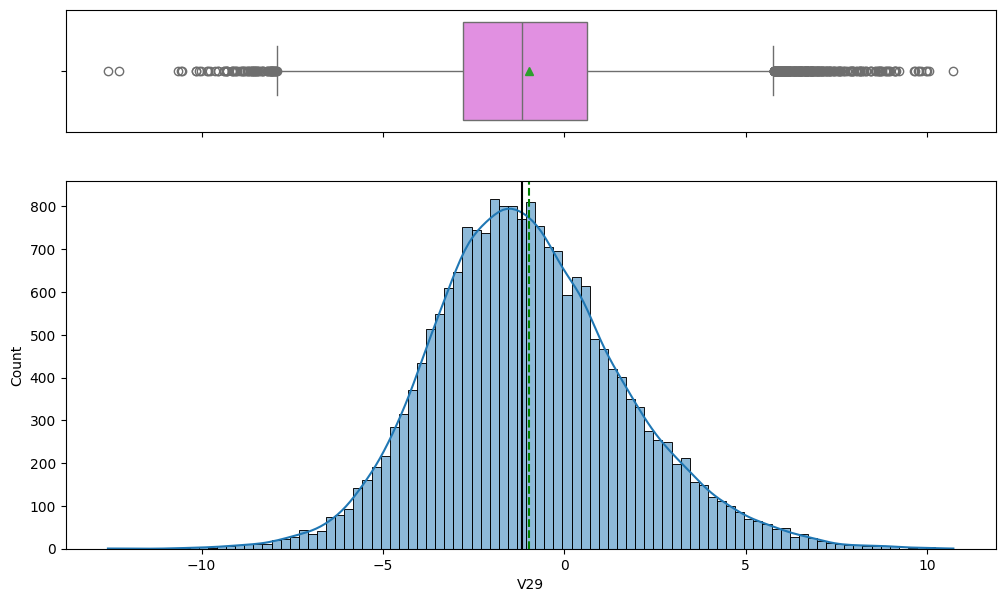

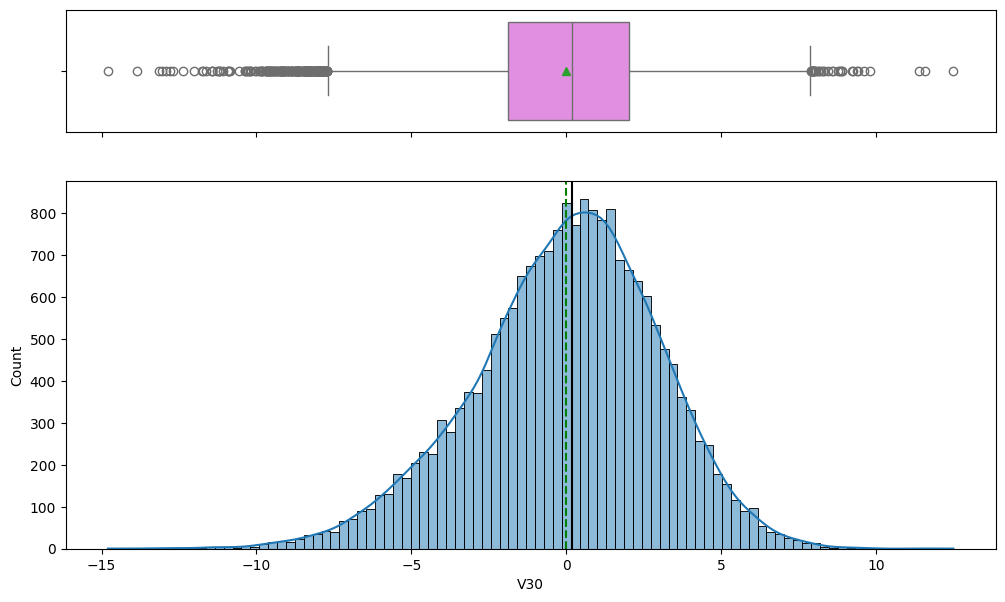

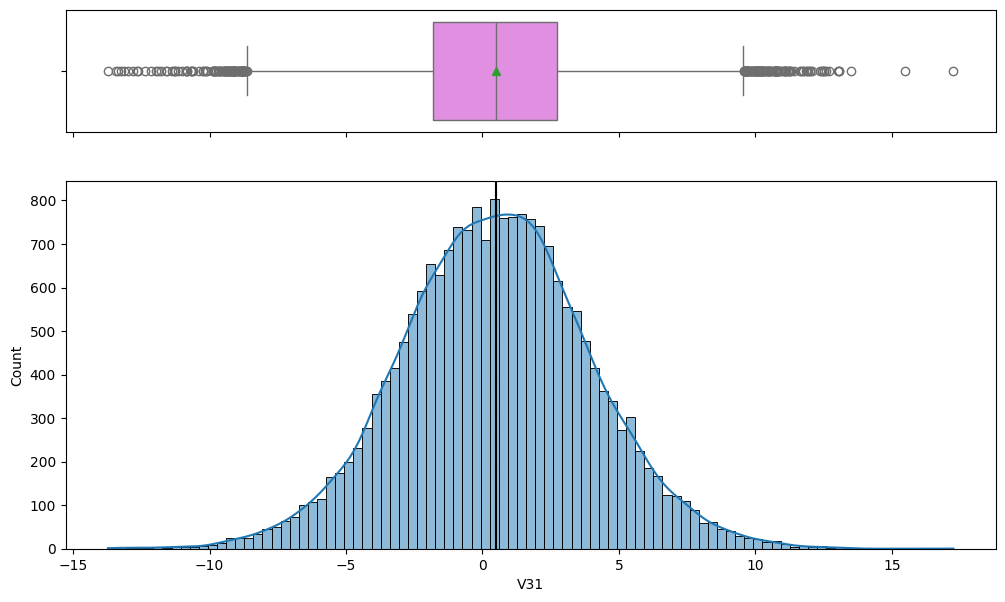

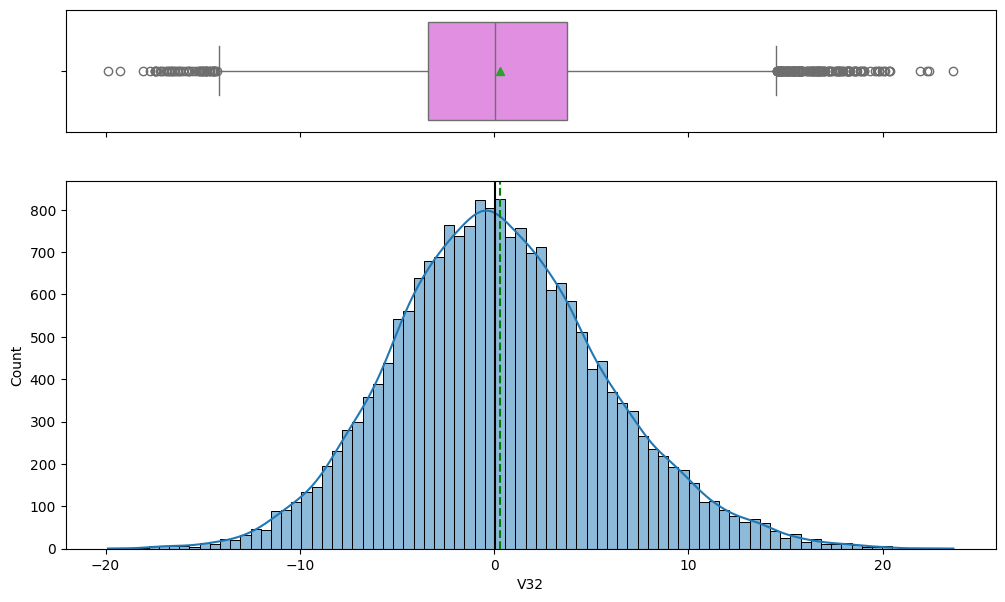

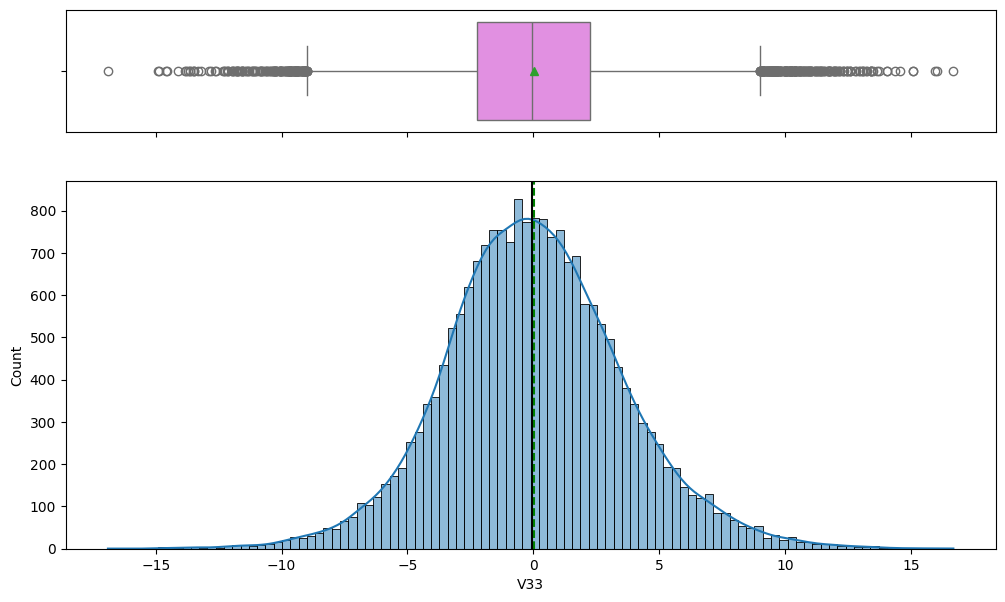

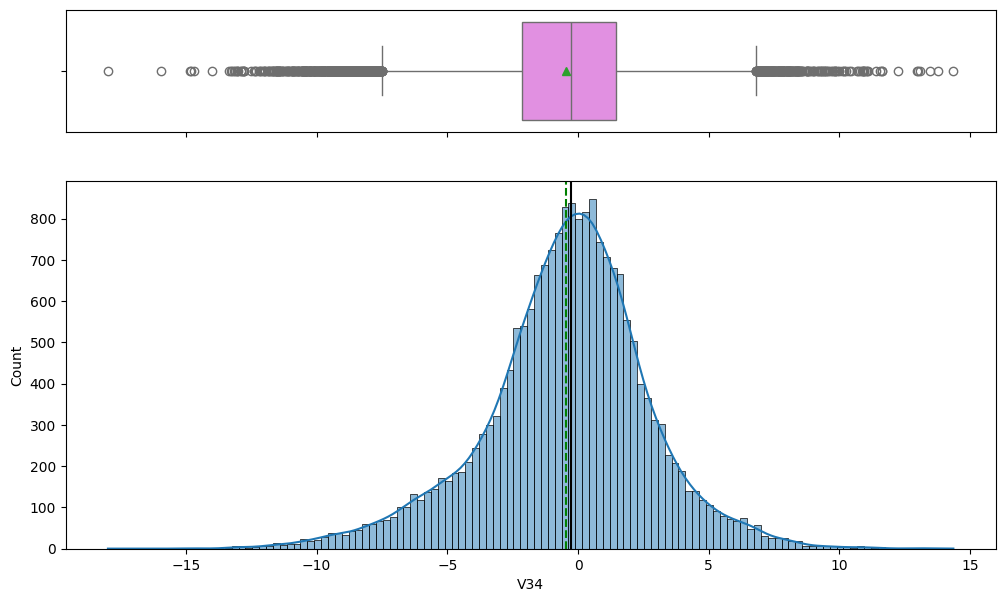

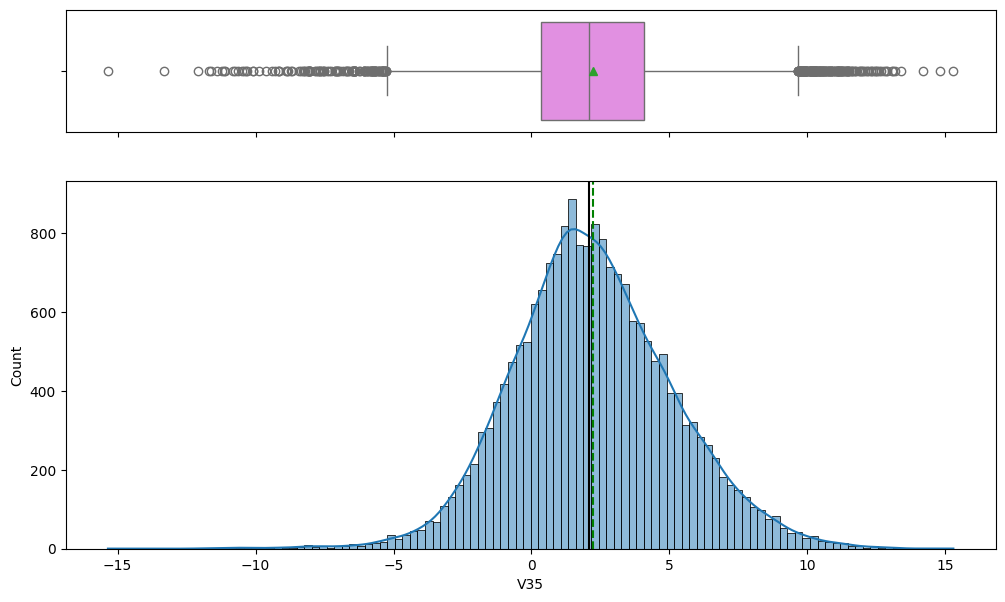

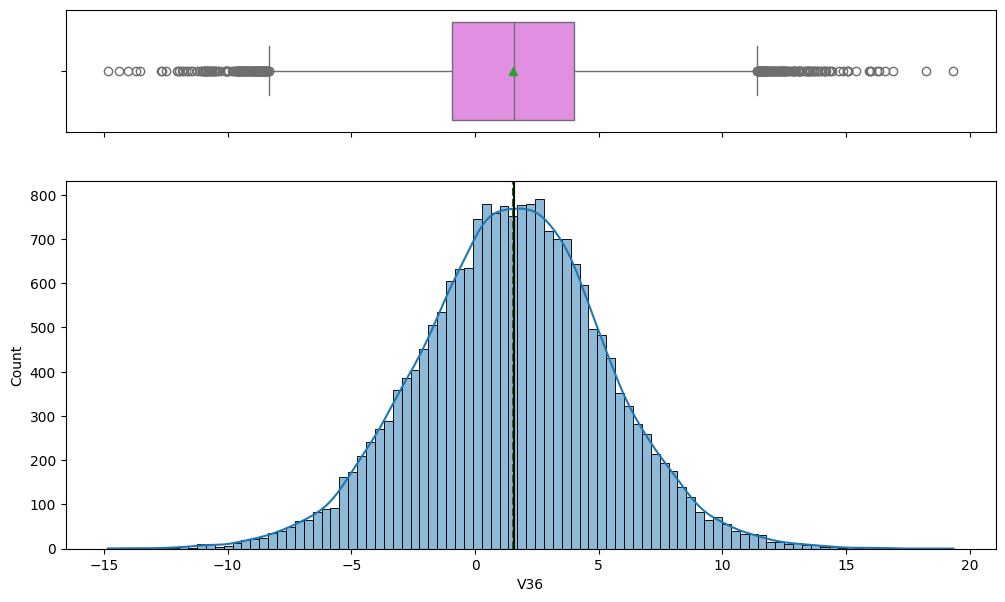

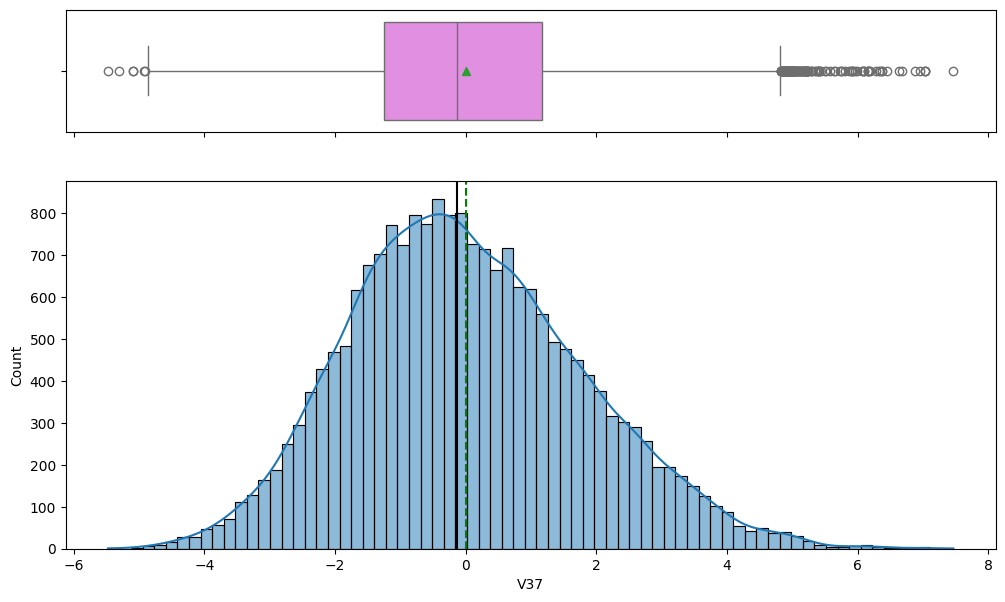

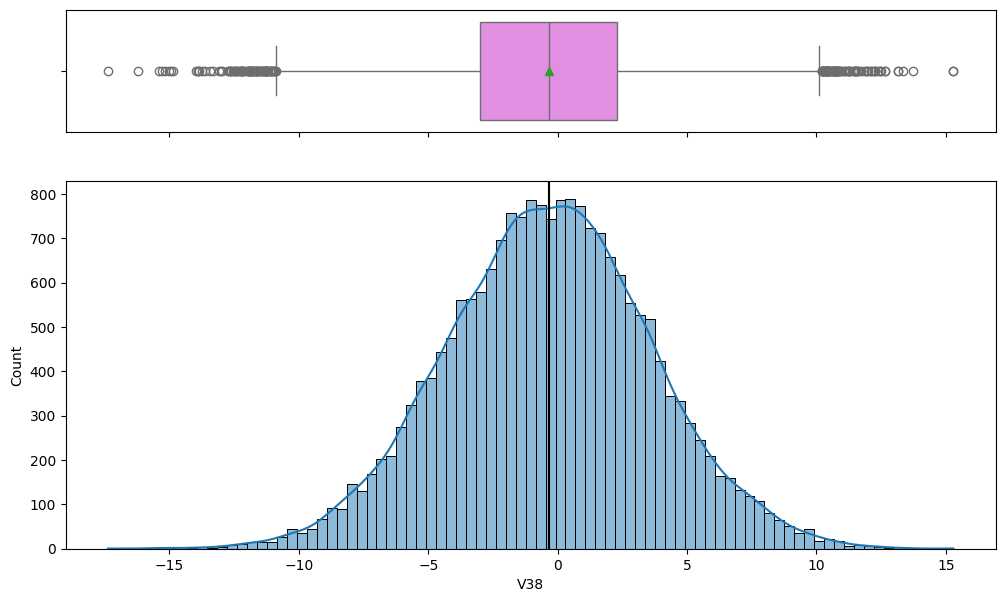

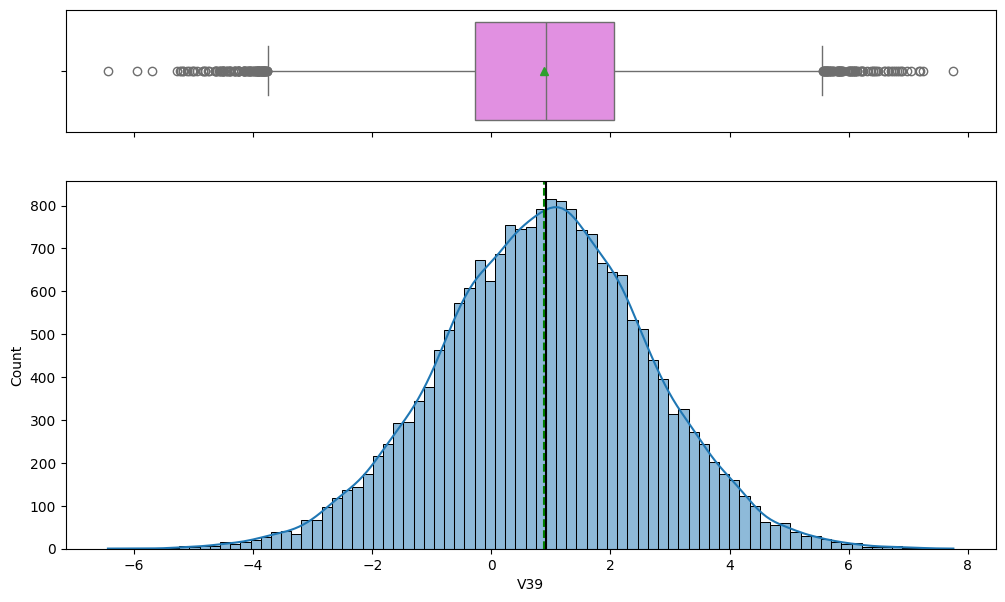

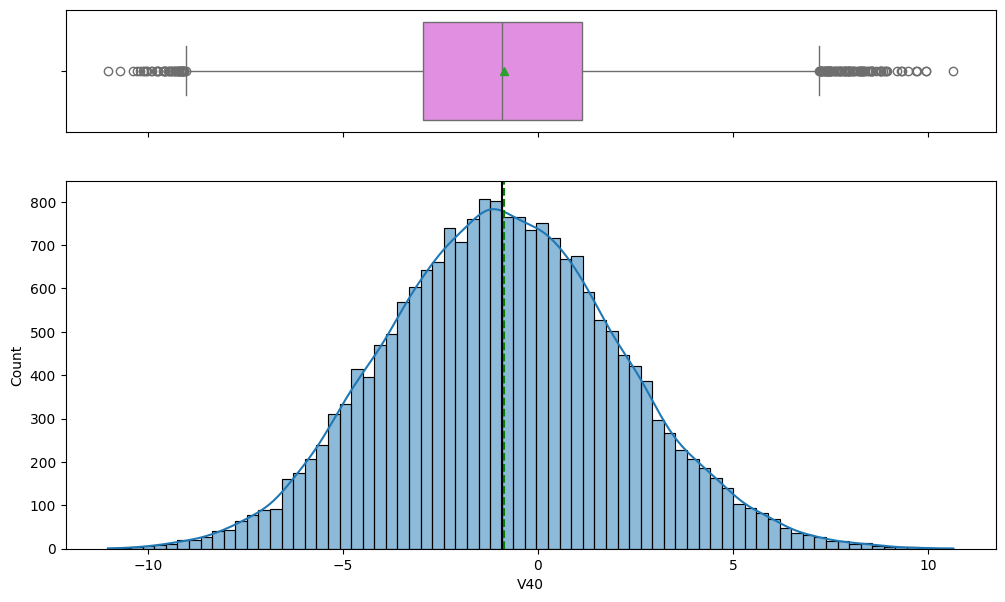

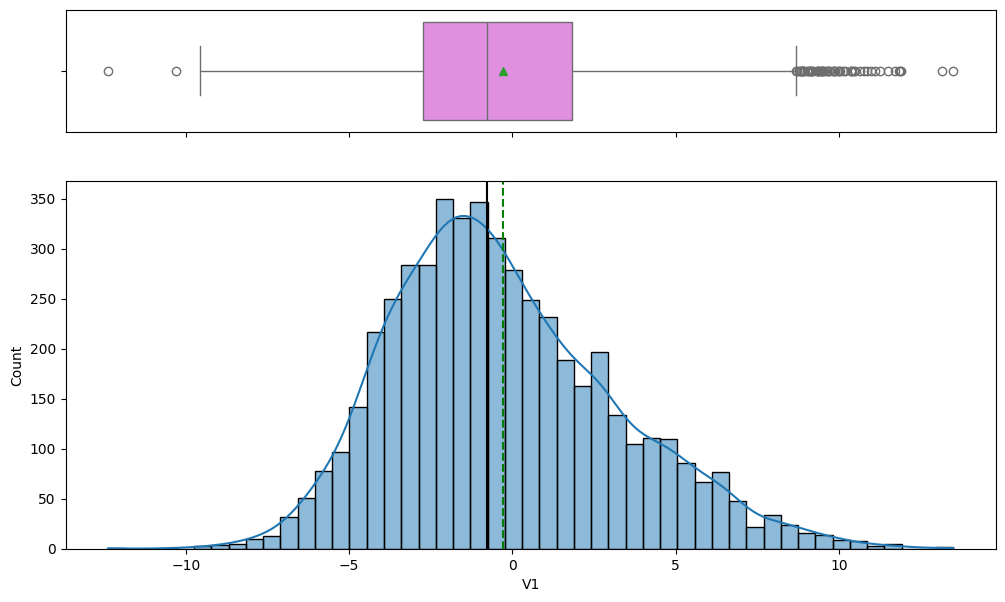

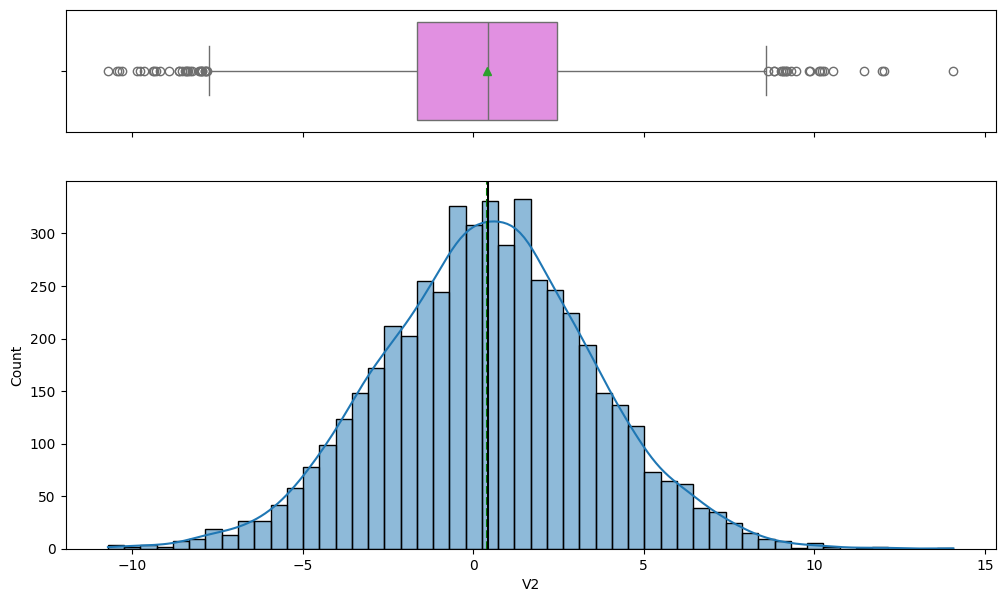

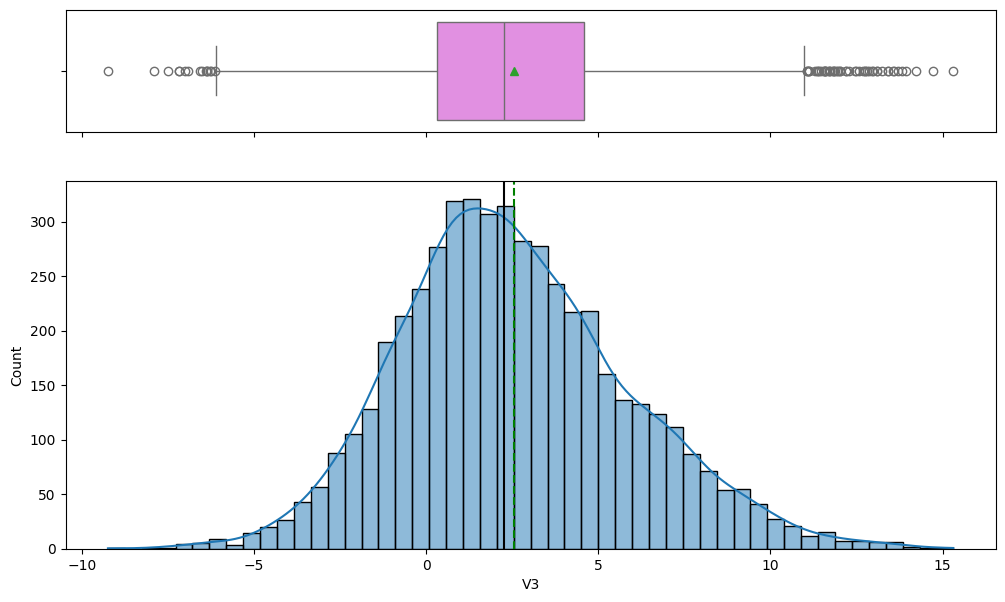

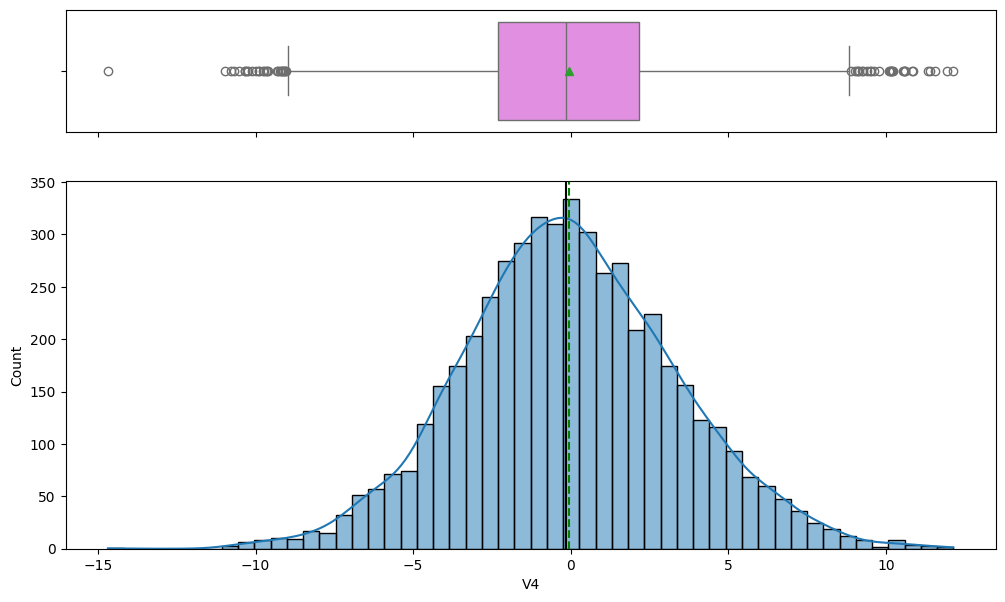

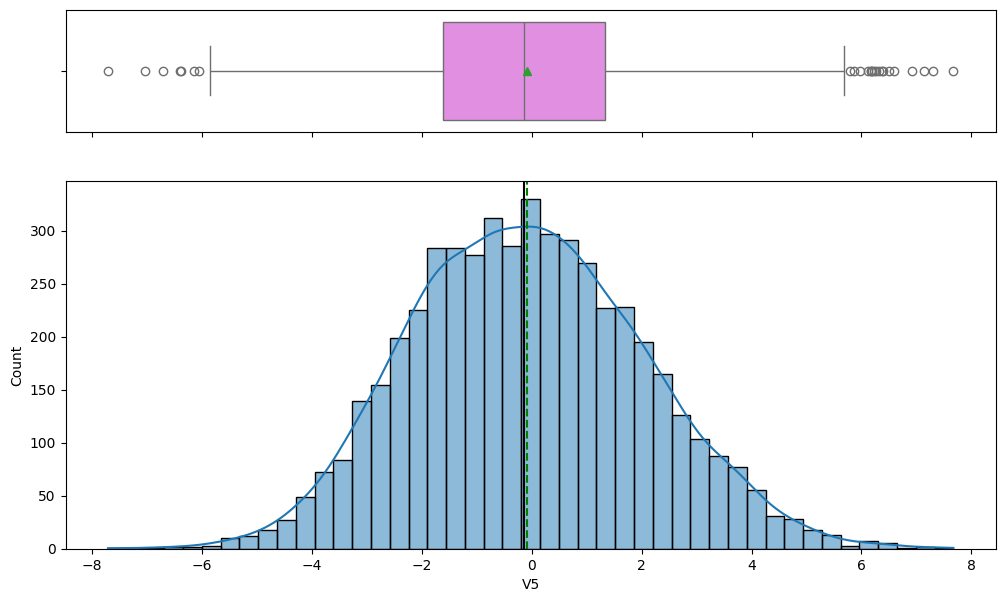

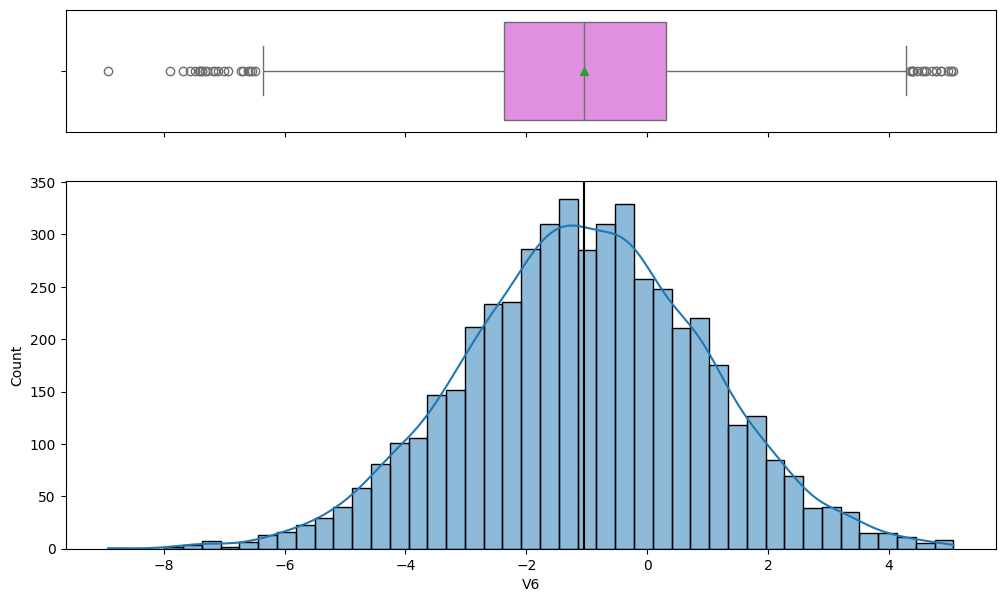

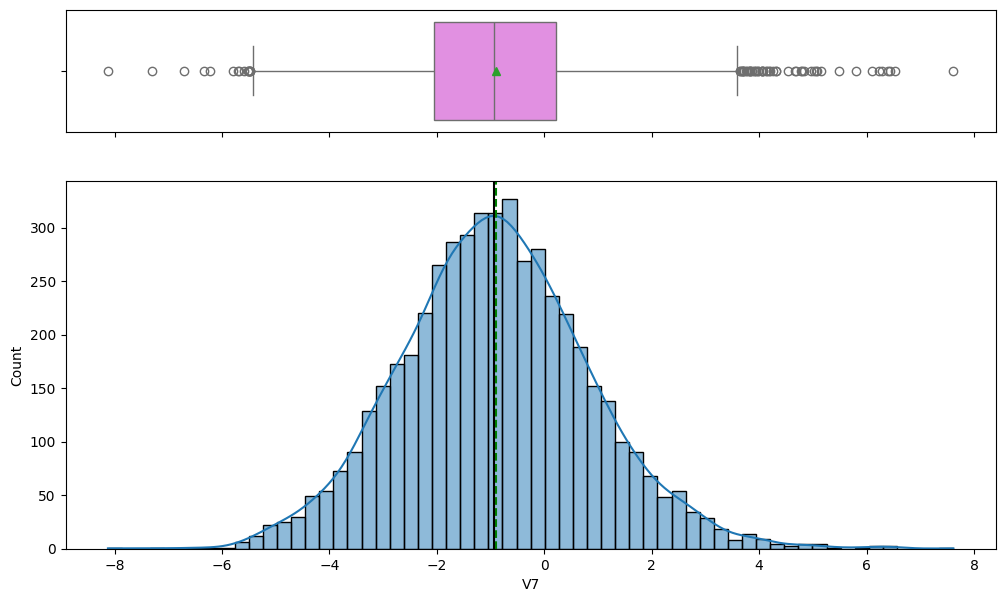

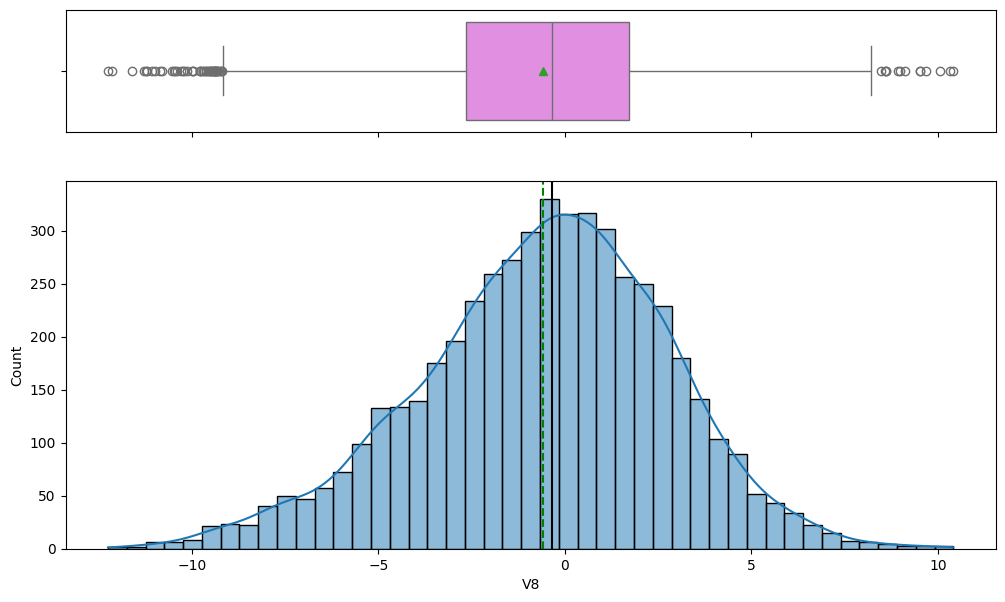

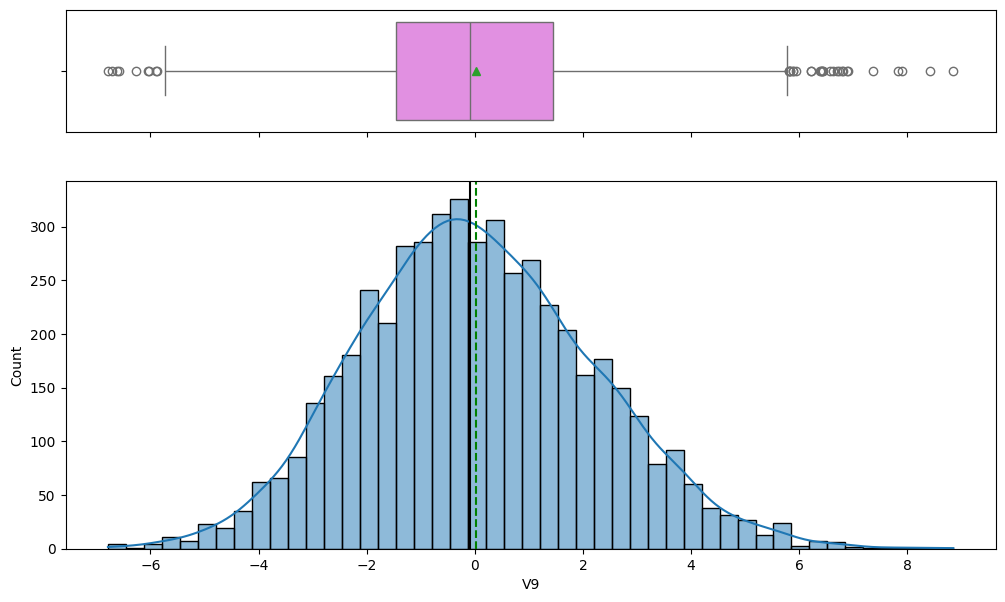

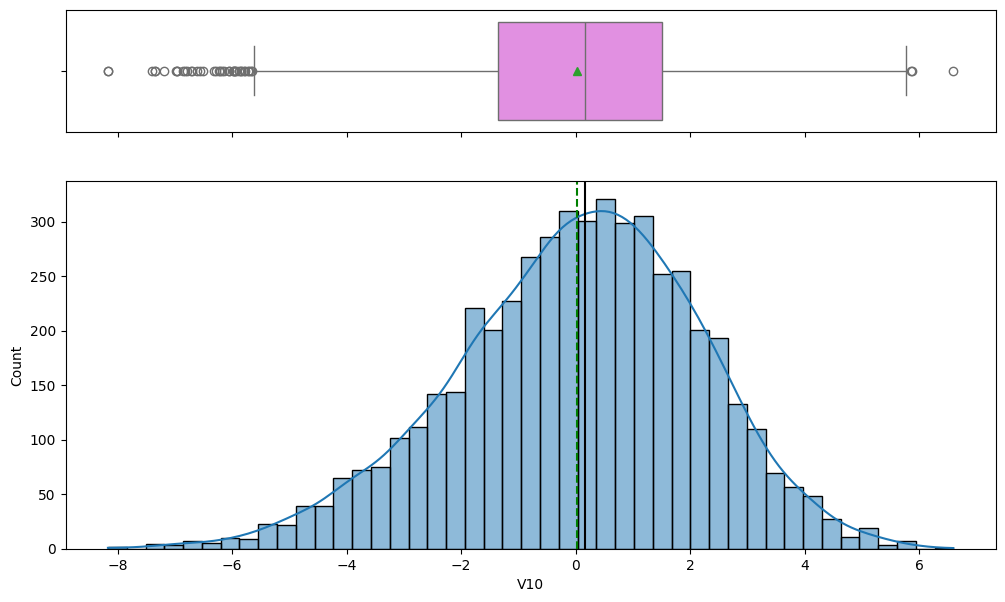

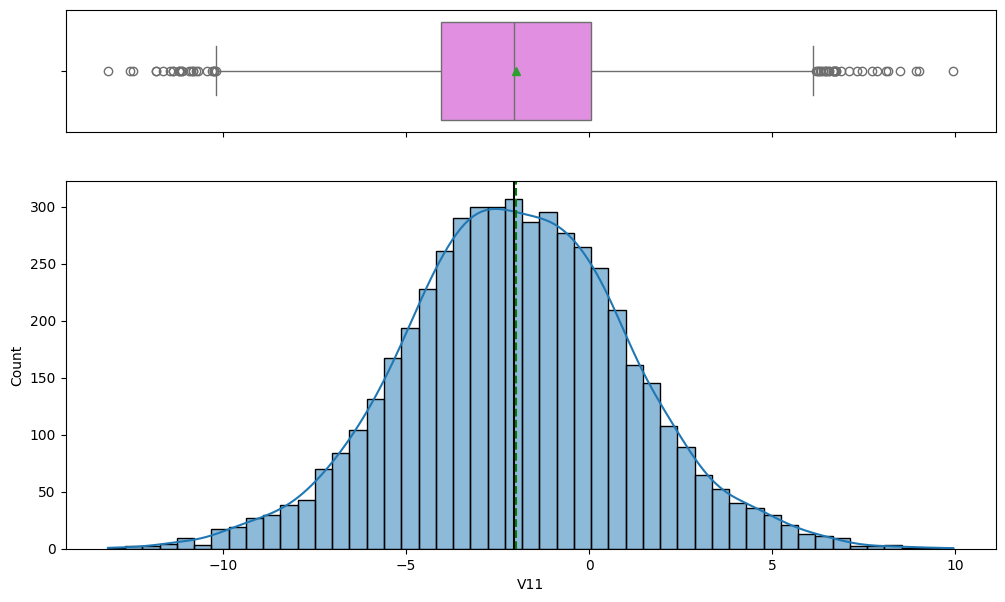

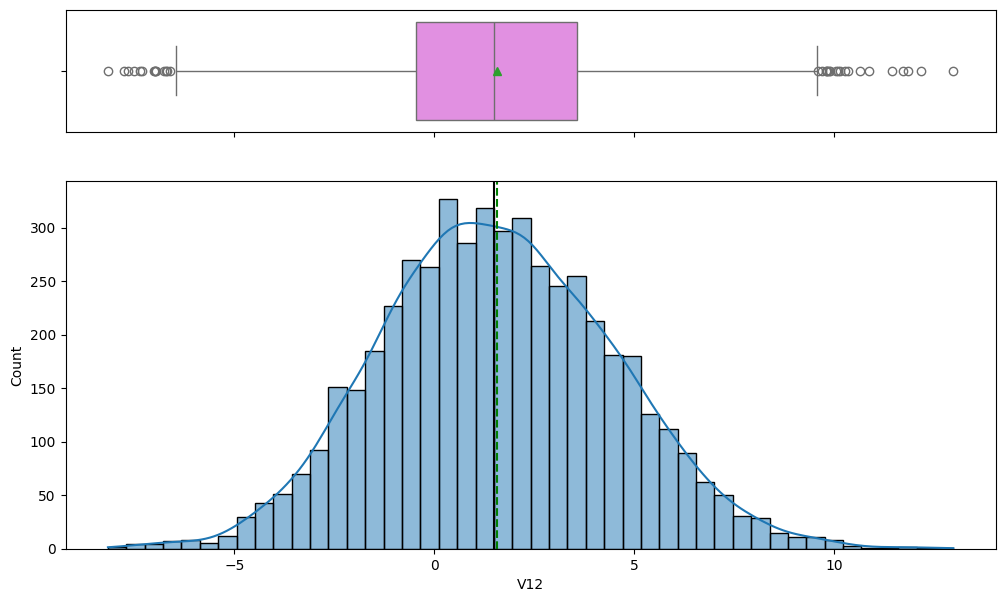

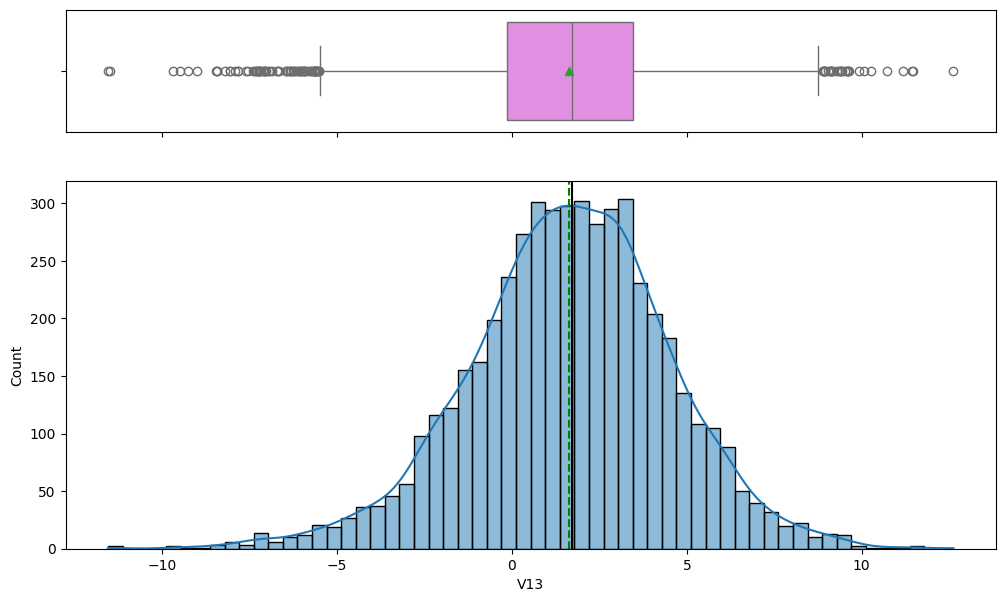

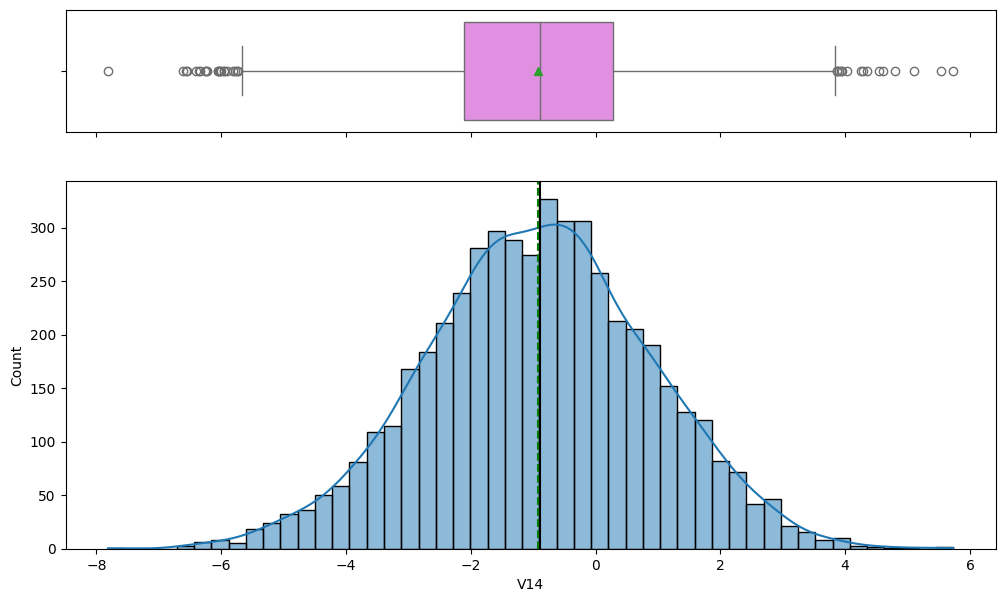

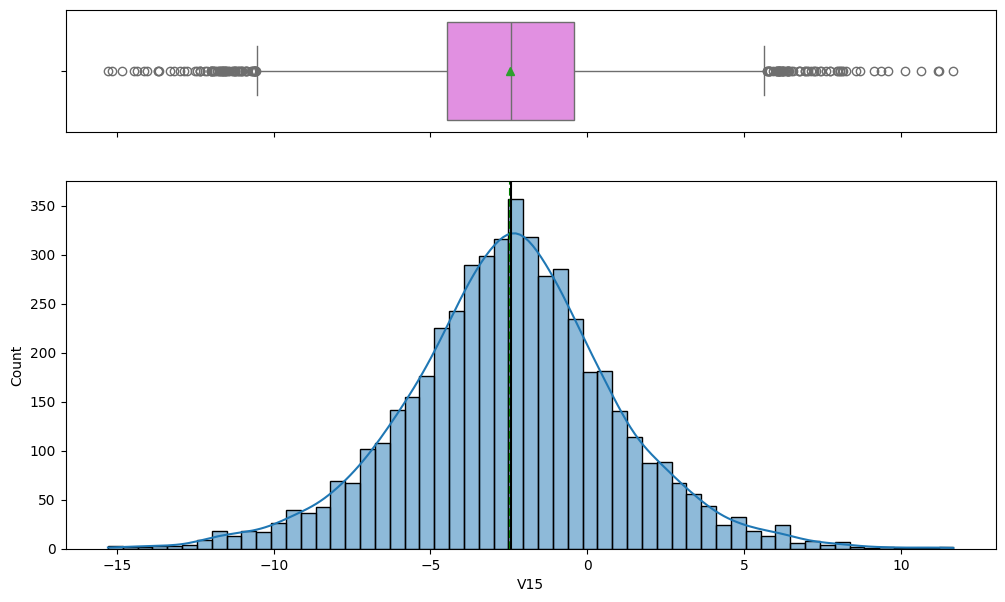

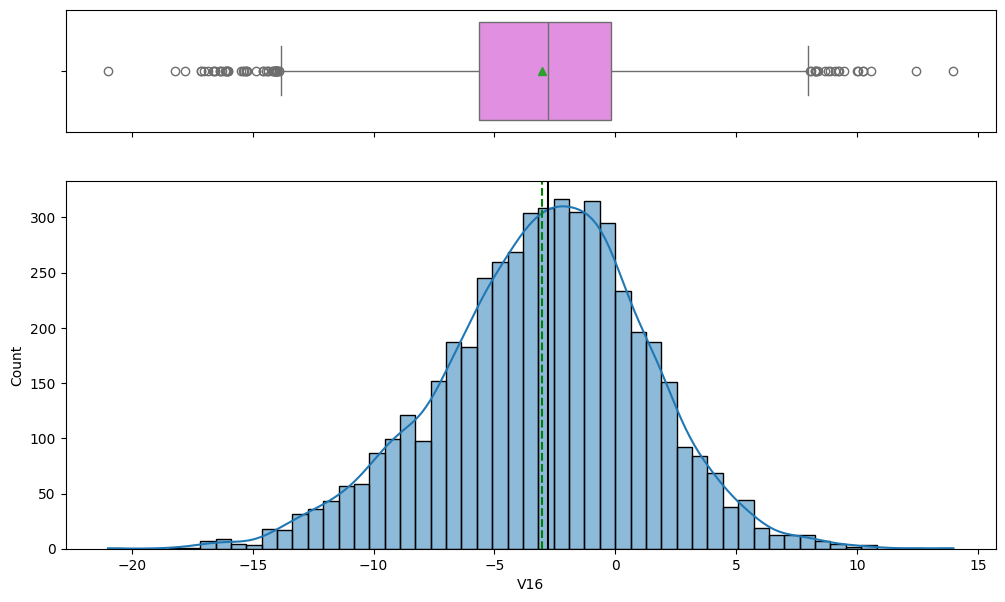

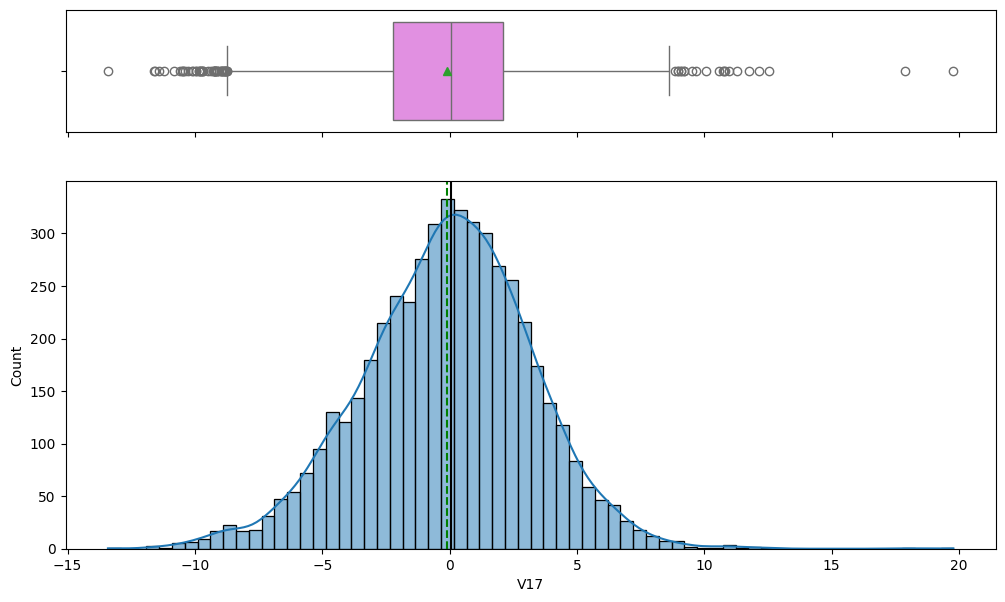

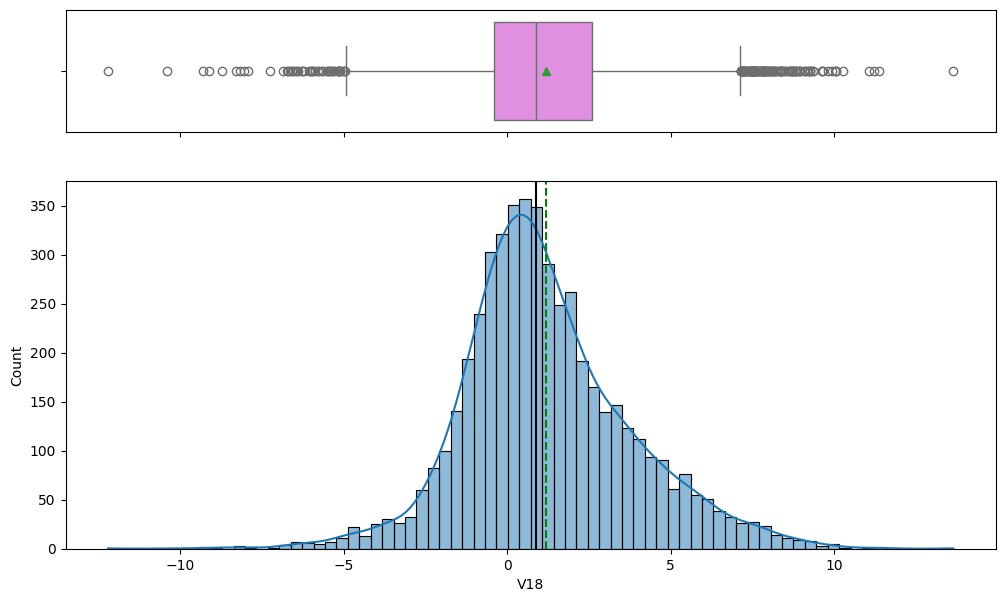

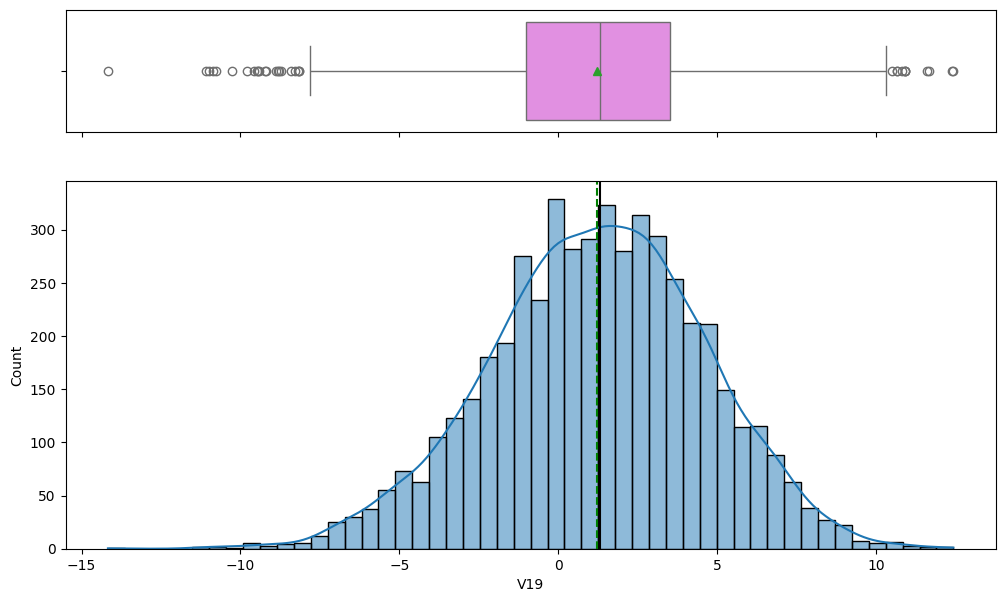

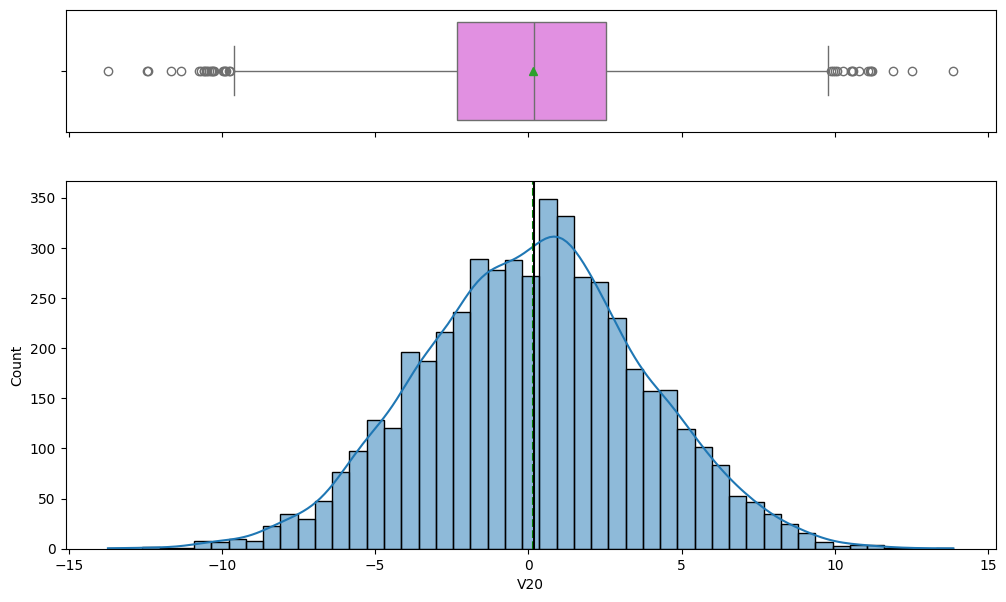

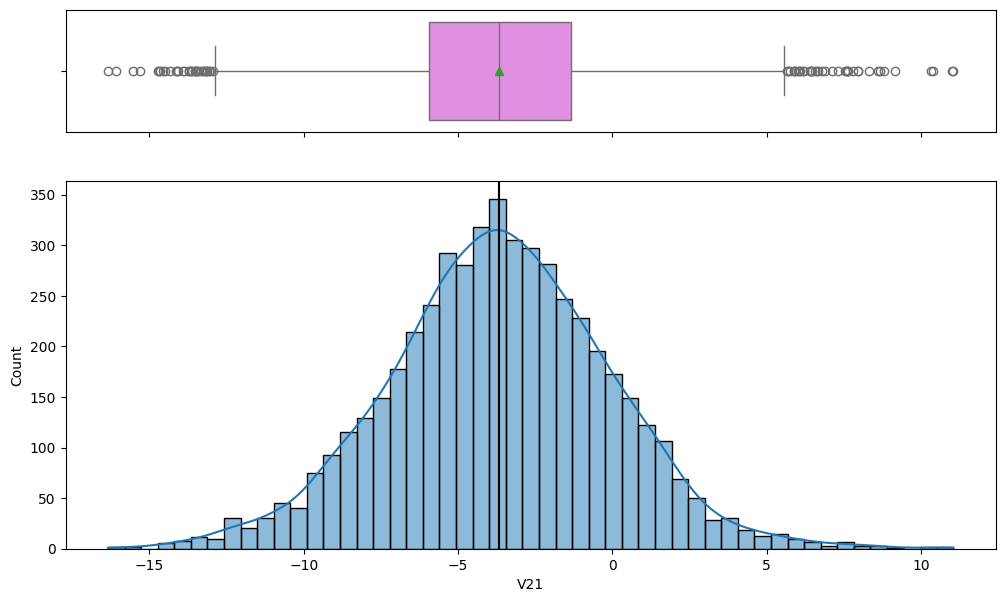

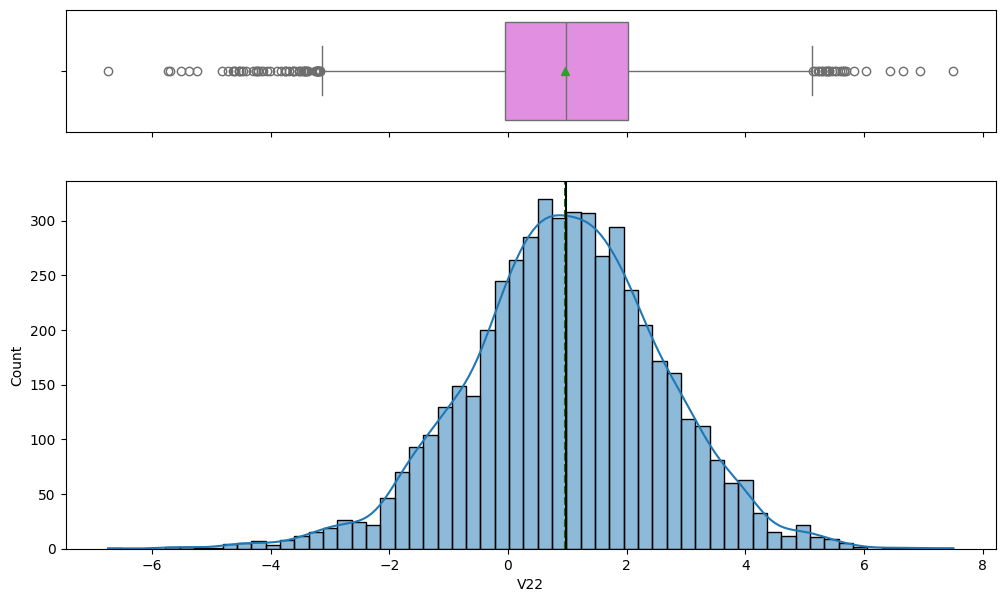

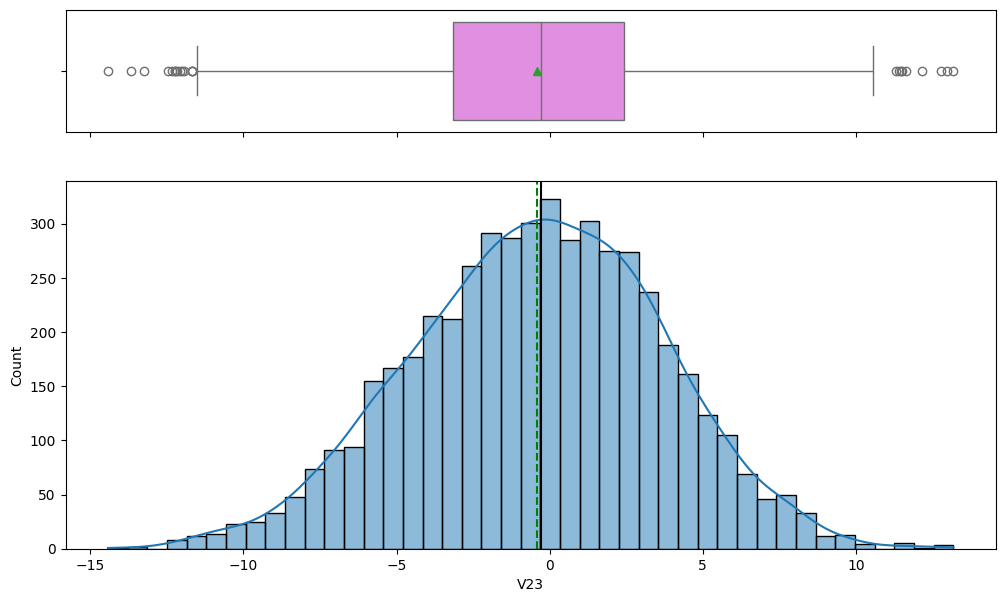

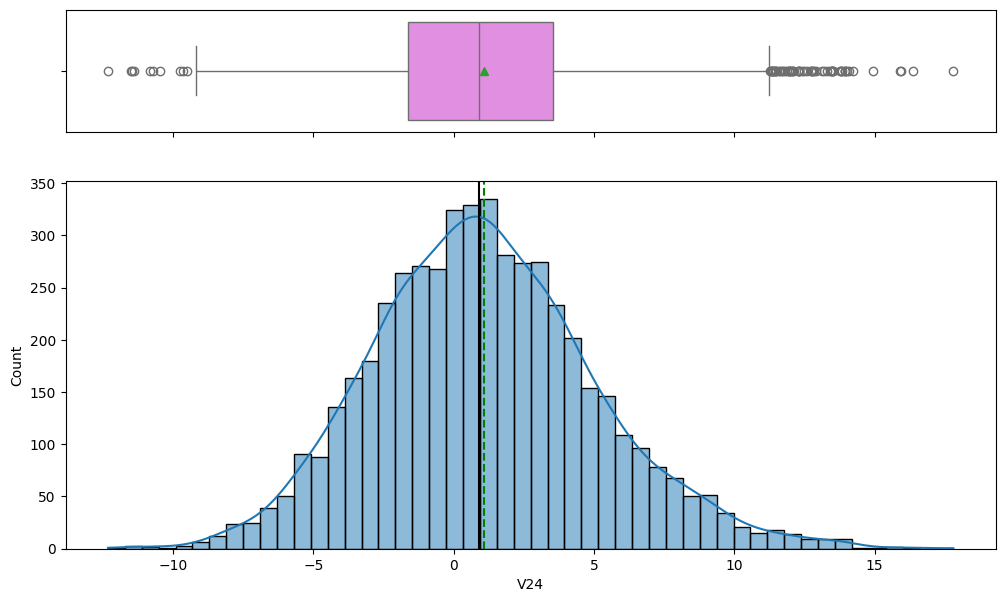

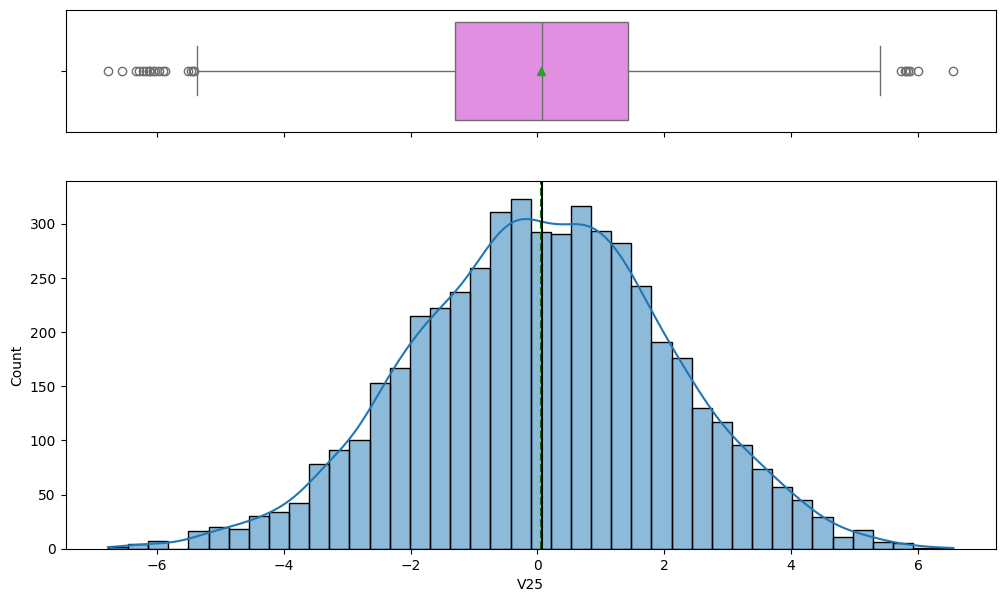

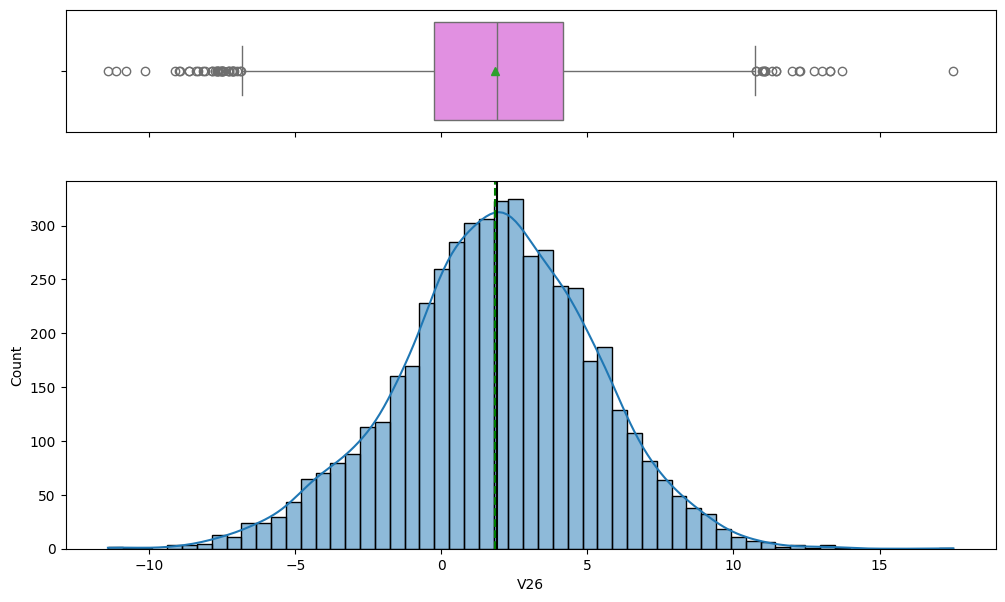

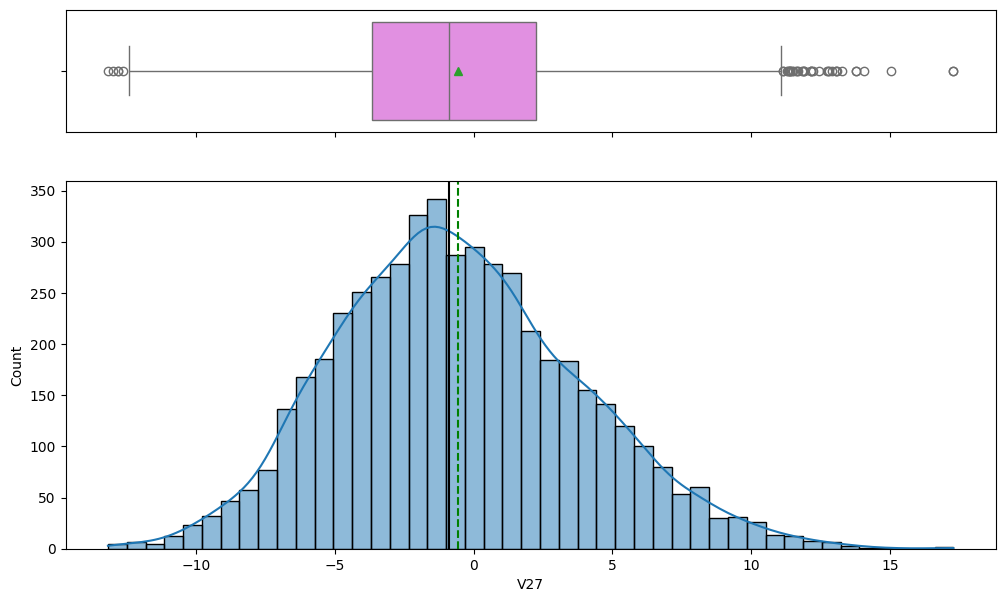

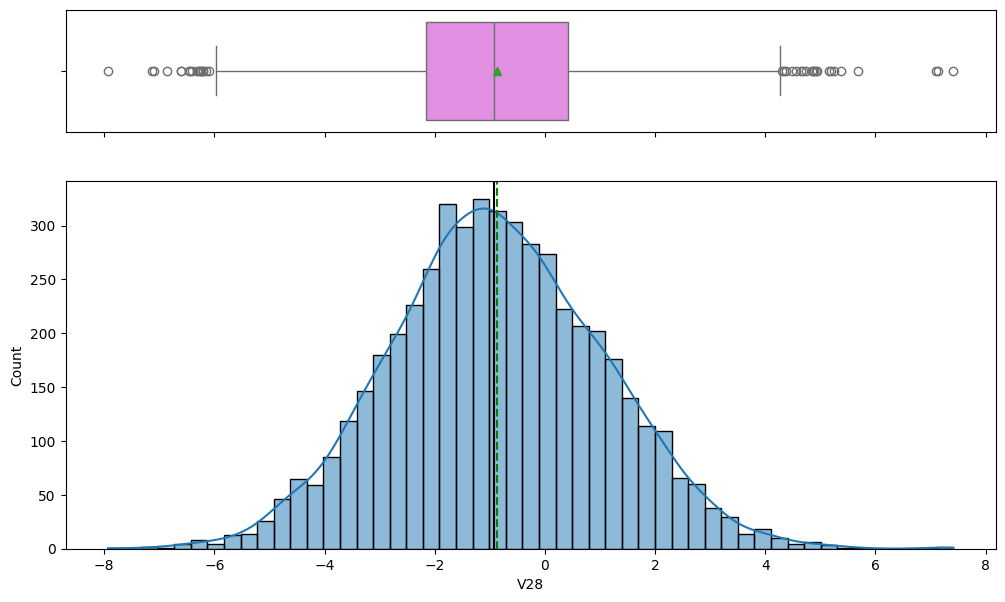

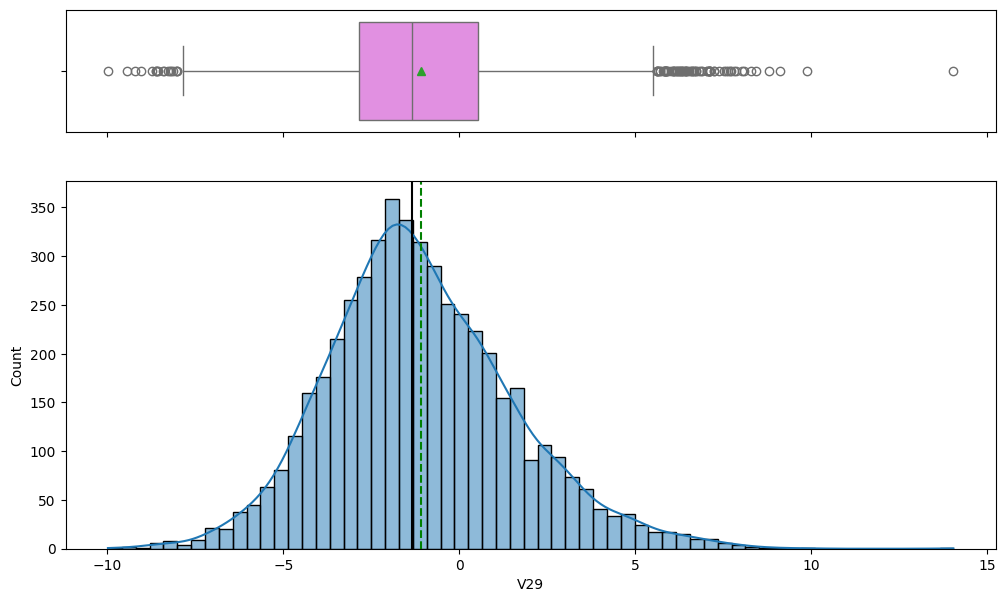

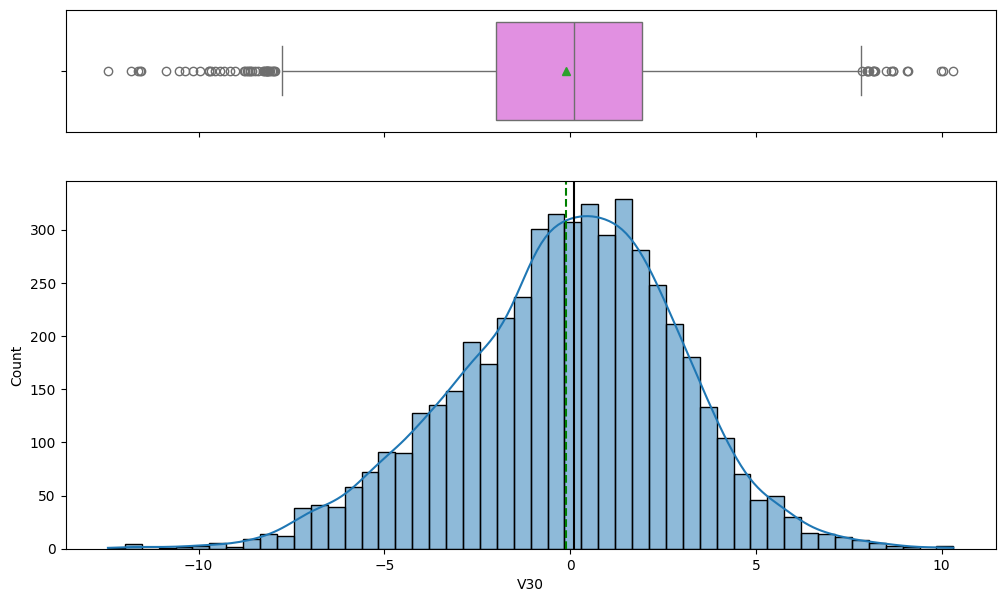

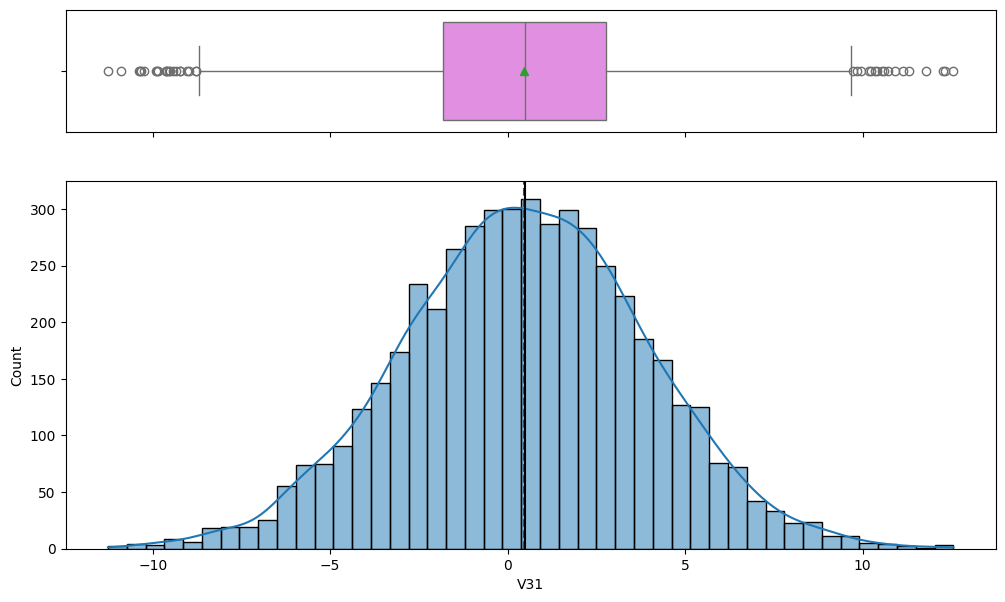

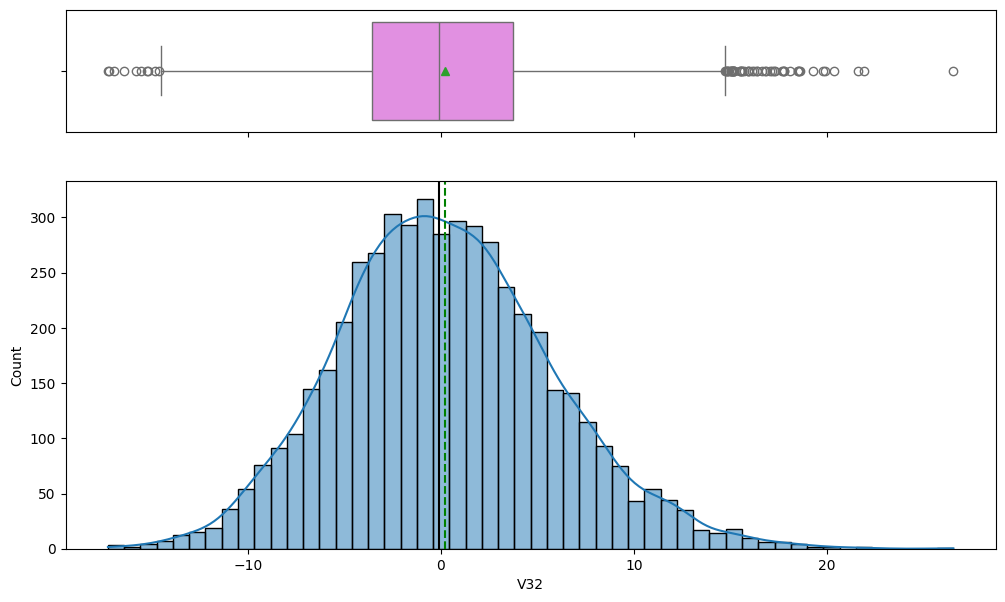

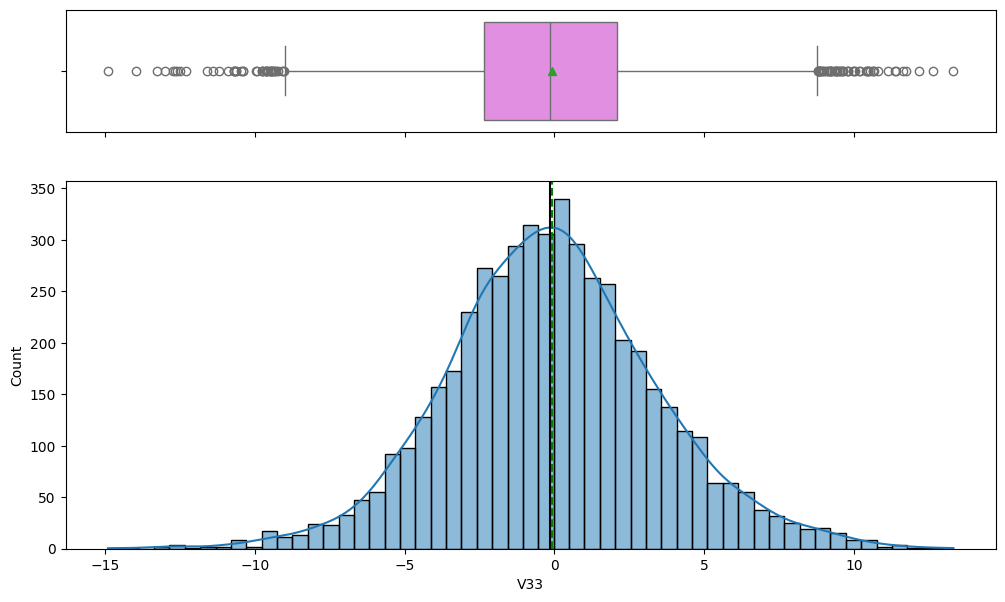

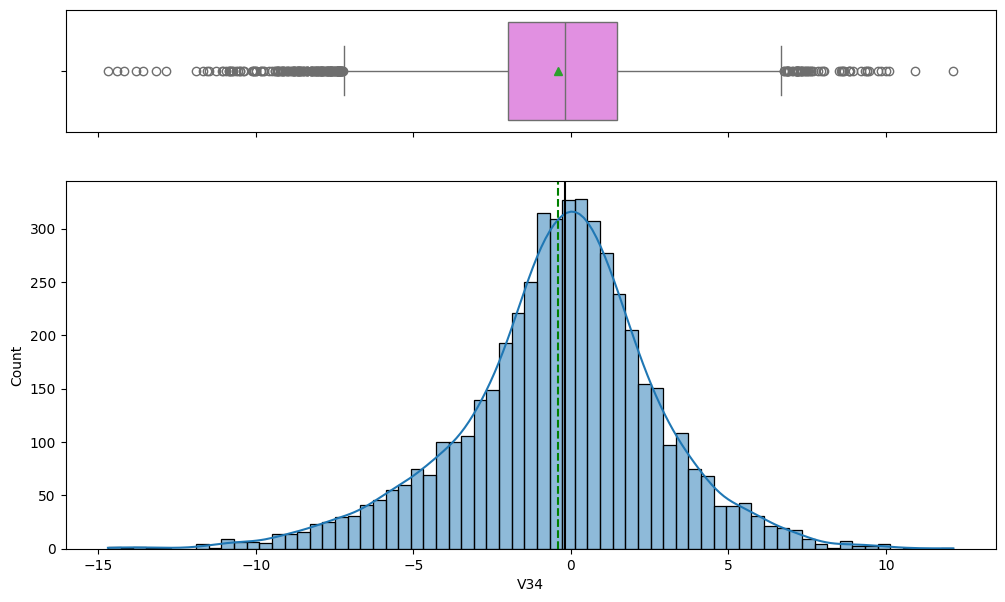

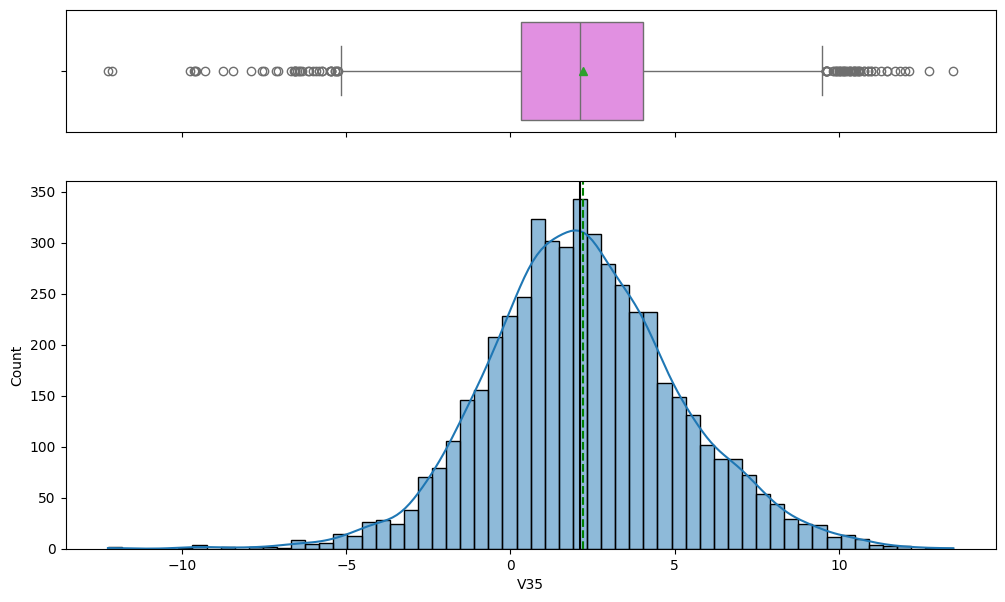

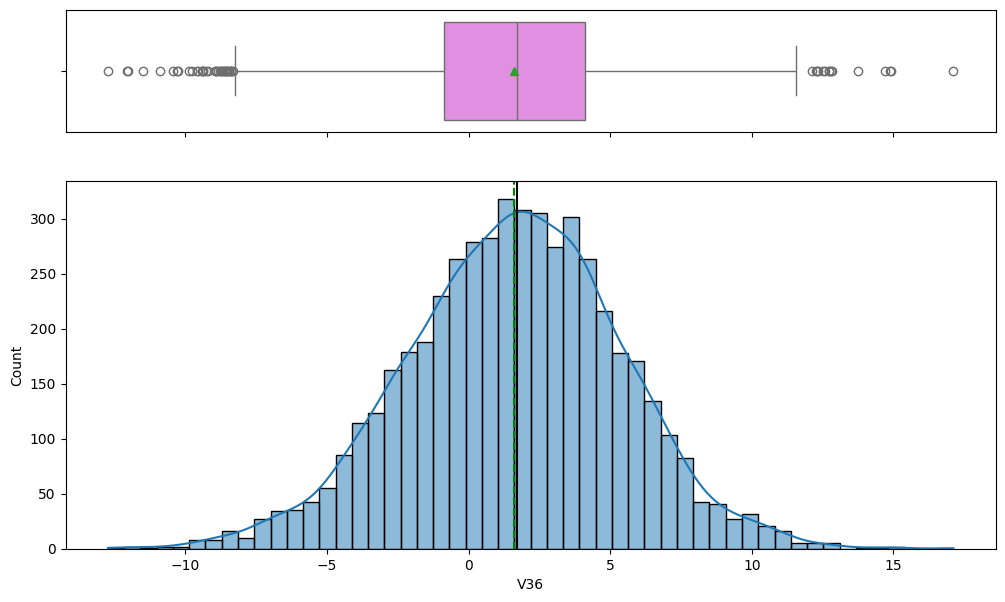

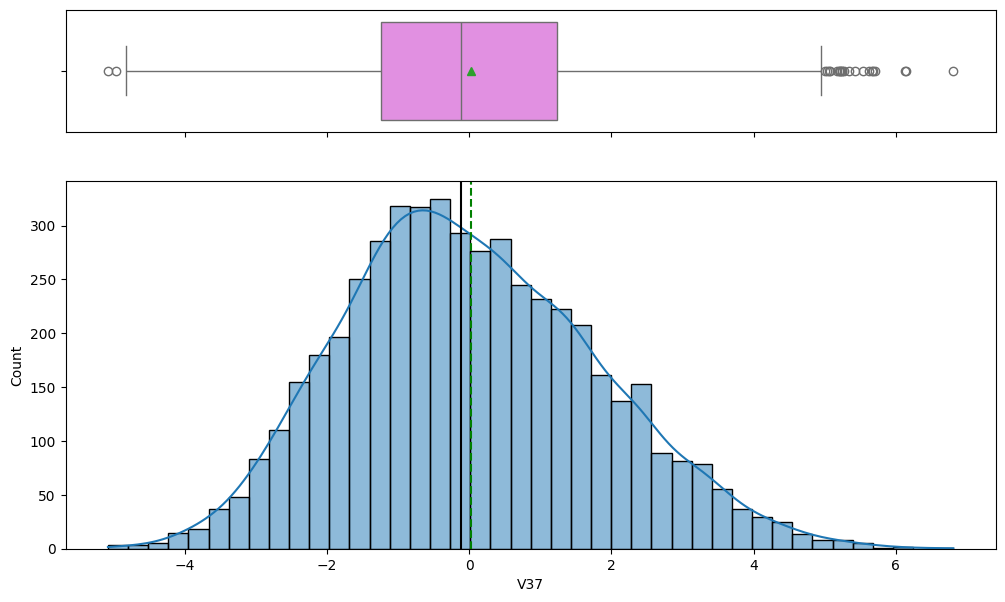

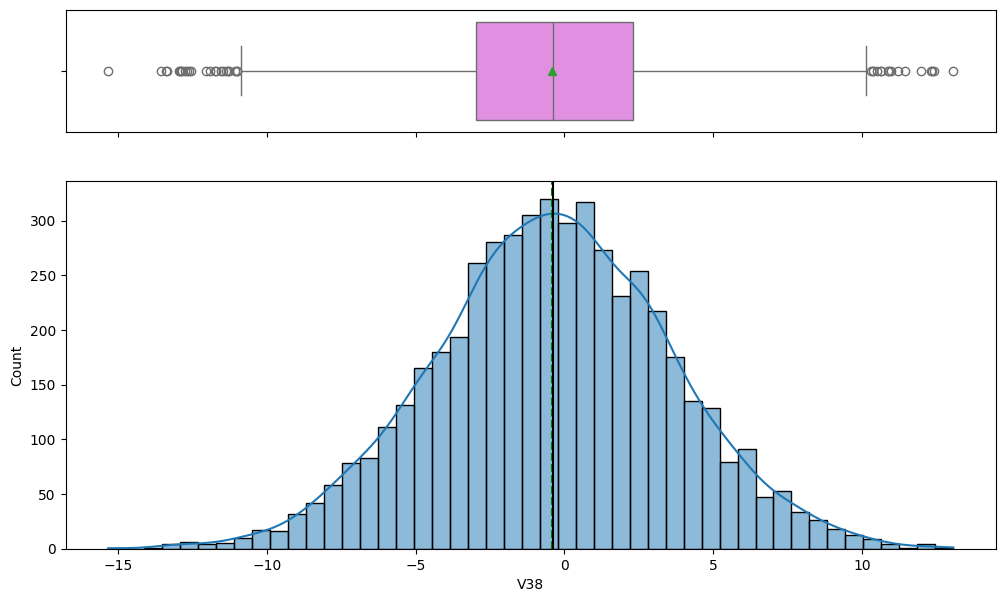

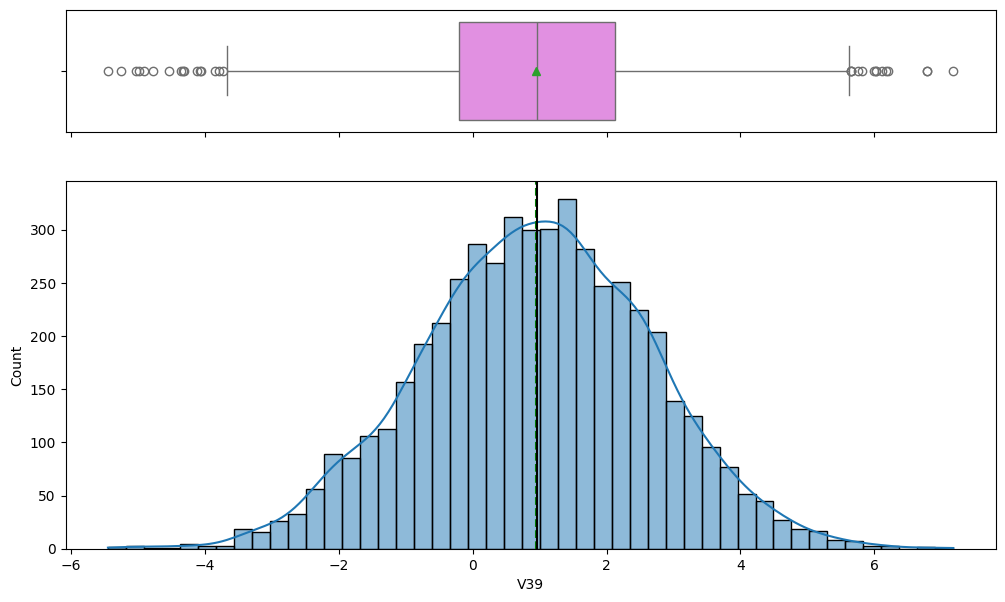

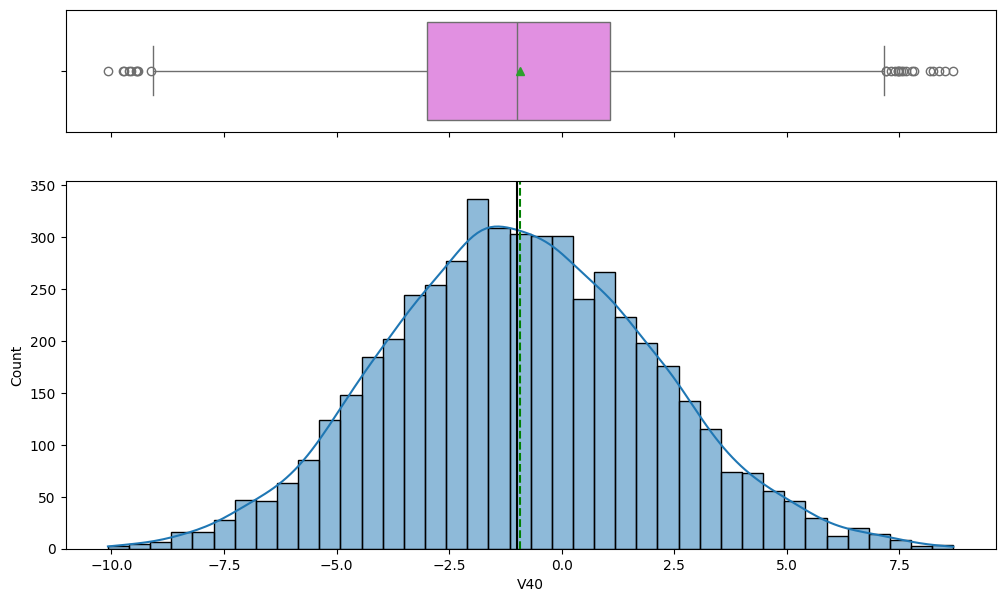

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets into pandas DataFrames
train_df = pd.read_csv('Train.csv.csv')
test_df = pd.read_csv('Test.csv.csv')

# Function to plot a boxplot and a histogram along the same scale
def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid = 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # Creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # Boxplot with mean indicated
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # Histogram with density curve if specified
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

    plt.show()

# Plotting all the features at once for the training dataset
for feature in train_df.columns:
    if feature != 'Target':  # Skip the target column
        histogram_boxplot(train_df, feature, figsize=(12, 7), kde=True)

# Plotting all the features at once for the testing dataset
for feature in test_df.columns:
    if feature != 'Target':  # Skip the target column
        histogram_boxplot(test_df, feature, figsize=(12, 7), kde=True)


**Observation**

1. **V1**:
   - **Outliers**: Yes
   - **Distribution**: Skewed
   - **Notes**: The distribution is right-skewed, with several outliers on the higher end.

2. **V2**:
   - **Outliers**: Yes
   - **Distribution**: Skewed
   - **Notes**: Right-skewed distribution with a few significant outliers.

3. **V3**:
   - **Outliers**: No
   - **Distribution**: Symmetrical
   - **Notes**: The distribution is fairly normal with no major outliers.

4. **V4**:
   - **Outliers**: No
   - **Distribution**: Symmetrical
   - **Notes**: Appears to be normally distributed with no significant outliers.

5. **V5**:
   - **Outliers**: Yes
   - **Distribution**: Skewed
   - **Notes**: Skewed distribution with a few outliers on the lower end.

6. **V6**:
   - **Outliers**: No
   - **Distribution**: Symmetrical
   - **Notes**: Mostly symmetrical, with no significant outliers.

7. **V7**:
   - **Outliers**: Yes
   - **Distribution**: Skewed
   - **Notes**: Right-skewed distribution with some outliers.

8. **V8**:
   - **Outliers**: Yes
   - **Distribution**: Skewed
   - **Notes**: Right-skewed, with a few high-value outliers.

9. **V9**:
   - **Outliers**: No
   - **Distribution**: Symmetrical
   - **Notes**: No significant outliers; fairly normal distribution.

10. **V10**:
    - **Outliers**: No
    - **Distribution**: Symmetrical
    - **Notes**: Symmetrical distribution with no major outliers.

11. **V11**:
    - **Outliers**: Yes
    - **Distribution**: Skewed
    - **Notes**: Skewed distribution with outliers on the higher end.

12. **V12**:
    - **Outliers**: No
    - **Distribution**: Symmetrical
    - **Notes**: No significant outliers; distribution is close to normal.

13. **V13**:
    - **Outliers**: Yes
    - **Distribution**: Skewed
    - **Notes**: Right-skewed with some outliers.

14. **V14**:
    - **Outliers**: No
    - **Distribution**: Symmetrical
    - **Notes**: Normal distribution with no significant outliers.

15. **V15**:
    - **Outliers**: Yes
    - **Distribution**: Skewed
    - **Notes**: Some high-value outliers in a right-skewed distribution.

16. **V16**:
    - **Outliers**: No
    - **Distribution**: Symmetrical
    - **Notes**: Symmetrical, no major outliers.

17. **V17**:
    - **Outliers**: Yes
    - **Distribution**: Skewed
    - **Notes**: Right-skewed with a few outliers.

18. **V18**:
    - **Outliers**: No
    - **Distribution**: Symmetrical
    - **Notes**: Distribution appears normal with no significant outliers.

19. **V19**:
    - **Outliers**: Yes
    - **Distribution**: Skewed
    - **Notes**: Some high-value outliers, right-skewed distribution.

20. **V20**:
    - **Outliers**: No
    - **Distribution**: Symmetrical
    - **Notes**: Fairly symmetrical with no significant outliers.

21. **V21**:
    - **Outliers**: Yes
    - **Distribution**: Skewed
    - **Notes**: Right-skewed with a few high outliers.

22. **V22**:
    - **Outliers**: No
    - **Distribution**: Symmetrical
    - **Notes**: Symmetrical, normally distributed with no significant outliers.

23. **V23**:
    - **Outliers**: Yes
    - **Distribution**: Skewed
    - **Notes**: Some outliers in a right-skewed distribution.

24. **V24**:
    - **Outliers**: No
    - **Distribution**: Symmetrical
    - **Notes**: No significant outliers; distribution appears normal.

25. **V25**:
    - **Outliers**: Yes
    - **Distribution**: Skewed
    - **Notes**: Right-skewed with some outliers.

26. **V26**:
    - **Outliers**: No
    - **Distribution**: Symmetrical
    - **Notes**: Symmetrical distribution with no significant outliers.

27. **V27**:
    - **Outliers**: Yes
    - **Distribution**: Skewed
    - **Notes**: Right-skewed distribution with a few outliers.

28. **V28**:
    - **Outliers**: No
    - **Distribution**: Symmetrical
    - **Notes**: No significant outliers; distribution appears normal.

29. **V29**:
    - **Outliers**: Yes
    - **Distribution**: Skewed
    - **Notes**: Some outliers in a right-skewed distribution.

30. **V30**:
    - **Outliers**: No
    - **Distribution**: Symmetrical
    - **Notes**: Symmetrical distribution with no major outliers.

31. **V31**:
    - **Outliers**: Yes
    - **Distribution**: Skewed
    - **Notes**: Right-skewed distribution with a few outliers.

32. **V32**:
    - **Outliers**: No
    - **Distribution**: Symmetrical
    - **Notes**: Distribution appears normal with no significant outliers.

33. **V33**:
    - **Outliers**: Yes
    - **Distribution**: Skewed
    - **Notes**: Right-skewed with some outliers.

34. **V34**:
    - **Outliers**: No
    - **Distribution**: Symmetrical
    - **Notes**: Fairly symmetrical with no significant outliers.

35. **V35**:
    - **Outliers**: Yes
    - **Distribution**: Skewed
    - **Notes**: Right-skewed distribution with a few high outliers.

36. **V36**:
    - **Outliers**: No
    - **Distribution**: Symmetrical
    - **Notes**: Symmetrical distribution with no major outliers.

37. **V37**:
    - **Outliers**: Yes
    - **Distribution**: Skewed
    - **Notes**: Some high-value outliers, right-skewed distribution.

38. **V38**:
    - **Outliers**: No
    - **Distribution**: Symmetrical
    - **Notes**: Normally distributed with no significant outliers.

39. **V39**:
    - **Outliers**: Yes
    - **Distribution**: Skewed
    - **Notes**: Right-skewed with some outliers.

40. **V40**:
    - **Outliers**: No
    - **Distribution**: Symmetrical
    - **Notes**: Symmetrical distribution with no significant outliers.

### General Notes:
- Many features are right-skewed and have outliers, which may impact statistical analysis and machine learning model performance. although tis is the cas we chose to keep the outliers as this data is captured throug sensors and may have important information.

## Data Pre-processing

Load Data

In [ ]:
from google.colab import files
uploaded = files.upload()
train_df = pd.read_csv('Train.csv.csv')
test_df = pd.read_csv('Test.csv.csv')


Saving Test.csv.csv to Test.csv.csv
Saving Train.csv.csv to Train.csv.csv


Define Target and Features

In [ ]:
# Define the target column
target_column = 'Target'

# Separate features and target
X = train_df.drop(columns=[target_column])
y = train_df[target_column]

# Check for any missing values
print(X.isnull().sum())
print(y.isnull().sum())


V1     18
V2     18
V3      0
V4      0
V5      0
V6      0
V7      0
V8      0
V9      0
V10     0
V11     0
V12     0
V13     0
V14     0
V15     0
V16     0
V17     0
V18     0
V19     0
V20     0
V21     0
V22     0
V23     0
V24     0
V25     0
V26     0
V27     0
V28     0
V29     0
V30     0
V31     0
V32     0
V33     0
V34     0
V35     0
V36     0
V37     0
V38     0
V39     0
V40     0
dtype: int64
0


**Observation**

- **V1** and **V2** have 18 missing values each.
- **V3** to **V40** have no missing values.







## Missing value imputation




In [ ]:
from sklearn.impute import SimpleImputer

# Impute missing values in features
imputer = SimpleImputer(strategy='median')
X = imputer.fit_transform(X)


**Observation**:

- I have imputed the missing values in **V1** and **V2** with  the median.


## Model Building

### Model evaluation criterion

The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model.
- False negatives (FN) are real failures in a generator where there is no detection by model.
- False positives (FP) are failure detections in a generator where there is no failure.

**Which metric to optimize?**

* We need to choose the metric which will ensure that the maximum number of generator failures are predicted correctly by the model.
* We would want Recall to be maximized as greater the Recall, the higher the chances of minimizing false negatives.
* We want to minimize false negatives because if a model predicts that a machine will have no failure when there will be a failure, it will increase the maintenance cost.

**Let's define a function to output different metrics (including recall) on the train and test set and a function to show confusion matrix so that we do not have to use the same code repetitively while evaluating models.**

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# Function to compute different metrics to check the classification model performance
def model_performance_classification_sklearn(model, predictors, target):
    pred = model.predict(predictors)
    acc = accuracy_score(target, pred)
    recall = recall_score(target, pred)
    precision = precision_score(target, pred)
    f1 = f1_score(target, pred)

    df_perf = pd.DataFrame({"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1}, index=[0])
    return df_perf

# Define the Decision Tree model
dtree = DecisionTreeClassifier(random_state=1)

# Train the model
dtree.fit(X_train, y_train)

# Evaluate the model on the validation set
val_performance = model_performance_classification_sklearn(dtree, X_val, y_val)
print(val_performance)


   Accuracy    Recall  Precision        F1
0   0.97125  0.738739   0.742081  0.740406


**observations:**

1. **Accuracy (0.97125)**: The model has a high accuracy of approximately 97.13%, meaning it correctly classifies around 97% of the validation samples. This indicates that the model performs well overall, but accuracy alone might not fully reflect performance, especially in cases of imbalanced datasets.

2. **Recall (0.7387)**: The recall score of approximately 73.87% indicates the model's ability to correctly identify positive instances (e.g., failures) from all actual positive instances. While a decent recall score suggests the model is reasonably good at detecting failures, there is still room for improvement.

3. **Precision (0.7421)**: The precision score of approximately 74.21% shows the proportion of positive identifications that were actually correct. This indicates that when the model predicts a failure, it is correct about 74% of the time.

4. **F1 Score (0.7404)**: The F1 score, which is the harmonic mean of precision and recall, is approximately 74.04%. This metric balances the trade-off between precision and recall and reflects overall performance in terms of both false positives and false negatives.

### Summary

- The model shows strong accuracy, suggesting it performs well overall.
- Recall and precision are relatively close, indicating that the model is reasonably balanced in identifying positive cases and minimizing false positives.
- The F1 score is also strong, indicating a good balance between recall and precision.



### Defining scorer to be used for cross-validation and hyperparameter tuning

- We want to reduce false negatives and will try to maximize "Recall".
- To maximize Recall, we can use Recall as a **scorer** in cross-validation and hyperparameter tuning.

In [ ]:
# Type of scoring used to compare parameter combinations
# Defining scorer to be used for cross-validation and hyperparameter tuning
from sklearn import metrics
scorer = metrics.make_scorer(metrics.recall_score)


### Model Building with original data

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, recall_score

# Define a scorer to maximize recall, which is important for reducing false negatives
scorer = make_scorer(recall_score)

# Initialize a list to hold models
models = []

# Append the Decision Tree model to the list
models.append(("dtree", DecisionTreeClassifier(random_state=1)))

# Evaluate the models using cross-validation
results1 = []
names = []

print("\nCross-Validation performance on training dataset:\n")

for name, model in models:
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    cv_result = cross_val_score(estimator=model, X=X_train, y=y_train, scoring=scorer, cv=kfold)
    results1.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

# Evaluate the models on the validation set
print("\nValidation Performance:\n")

for name, model in models:
    model.fit(X_train, y_train)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))



Cross-Validation performance on training dataset:

dtree: 0.7196280073636767

Validation Performance:

dtree: 0.7387387387387387


**Observation**

### Cross-Validation Performance

- **Recall Score (Cross-Validation)**: Approximately 71.96%

The recall score obtained from cross-validation indicates that the Decision Tree model has an average recall of about 71.96% when evaluated on different subsets of the training data. This suggests that, on average, the model is able to identify approximately 72% of the actual failures during training. This is a good indication that the model can detect a significant portion of failures, which is important for predictive maintenance.

### Validation Performance

- **Recall Score (Validation Set)**: Approximately 73.87%

The recall score on the validation set is slightly higher at around 73.87%. This shows that the model's ability to detect failures is consistent when applied to unseen data. A slightly higher recall on the validation set compared to cross-validation suggests that the model generalizes well to new data, which is crucial for real-world application.

### notes

1. **Performance Consistency**: The model's performance on both cross-validation and the validation set is quite consistent, indicating that it performs reliably across different data subsets.

2. **Recall Focus**: Given that recall is a key metric for your objective (identifying failures before they occur), a recall score of around 73% suggests that the model is effective in detecting failures. This helps in minimizing the risk of false negatives, which could lead to higher replacement costs.

3. **Model Evaluation**: While the recall is reasonably high, it's essential to also consider other metrics like precision, F1 score, and the overall cost implications of false positives and false negatives in the context of maintenance costs.



### Model Building with Oversampled data


In [ ]:
# Synthetic Minority Over Sampling Technique
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)

### Model Building with Undersampled data

In [ ]:
# Random undersampler for under sampling the data
rus = RandomUnderSampler(random_state=1, sampling_strategy=1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)

## HyperparameterTuning

### Sample Parameter Grids

**Hyperparameter tuning can take a long time to run, so to avoid that time complexity - you can use the following grids, wherever required.**

- For Gradient Boosting:

param_grid = {
    "n_estimators": np.arange(100,150,25),
    "learning_rate": [0.2, 0.05, 1],
    "subsample":[0.5,0.7],
    "max_features":[0.5,0.7]
}

- For Adaboost:

param_grid = {
    "n_estimators": [100, 150, 200],
    "learning_rate": [0.2, 0.05],
    "base_estimator": [DecisionTreeClassifier(max_depth=1, random_state=1), DecisionTreeClassifier(max_depth=2, random_state=1), DecisionTreeClassifier(max_depth=3, random_state=1),
    ]
}

- For Bagging Classifier:

param_grid = {
    'max_samples': [0.8,0.9,1],
    'max_features': [0.7,0.8,0.9],
    'n_estimators' : [30,50,70],
}

- For Random Forest:

param_grid = {
    "n_estimators": [200,250,300],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
    "max_samples": np.arange(0.4, 0.7, 0.1)
}

- For Decision Trees:

param_grid = {
    'max_depth': np.arange(2,6),
    'min_samples_leaf': [1, 4, 7],
    'max_leaf_nodes' : [10, 15],
    'min_impurity_decrease': [0.0001,0.001]
}

- For Logistic Regression:

param_grid = {'C': np.arange(0.1,1.1,0.1)}

- For XGBoost:

param_grid={
    'n_estimators': [150, 200, 250],
    'scale_pos_weight': [5,10],
    'learning_rate': [0.1,0.2],
    'gamma': [0,3,5],
    'subsample': [0.8,0.9]
}

### Sample tuning method for Decision tree with original data

In [ ]:
# defining model
Model = DecisionTreeClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {'max_depth': np.arange(2,6),
              'min_samples_leaf': [1, 4, 7],
              'max_leaf_nodes' : [10,15],
              'min_impurity_decrease': [0.0001,0.001] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'min_samples_leaf': 7, 'min_impurity_decrease': 0.0001, 'max_leaf_nodes': 15, 'max_depth': 5} with CV score=0.5675998222560782:



**oservations:**

1. **`min_samples_leaf` = 7:**
   - This parameter indicates that a node must have at least 7 samples to be considered a leaf. A higher value generally leads to a more generalized model by preventing the tree from creating overly specific nodes that may lead to overfitting.

2. **`min_impurity_decrease` = 0.0001:**
   - This parameter specifies the minimum decrease in impurity required to split a node. A small value means that the model is more likely to split nodes, which can lead to a more complex tree.

3. **`max_leaf_nodes` = 15:**
   - The maximum number of leaf nodes is set to 15. This limits the complexity of the model by controlling the number of final decisions (leaves) the tree can make. This helps in preventing the model from growing too complex.

4. **`max_depth` = 5:**
   - The maximum depth of the tree is set to 5. This limits the number of levels the tree can grow, which helps control the model's complexity and reduces the risk of overfitting.

5. **CV Score of 0.5676:**
   - The cross-validation score indicates how well the model is performing on average across the folds of your cross-validation. A score of 0.5676 suggests moderate performance. The exact interpretation depends on the scoring metric used, but generally, a score around 0.5676 indicates there is room for improvement.



### Sample tuning method for Decision tree with oversampled data

In [ ]:
# defining model
Model = DecisionTreeClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {'max_depth': np.arange(2,6),
              'min_samples_leaf': [1, 4, 7],
              'max_leaf_nodes' : [10,15],
              'min_impurity_decrease': [0.0001,0.001] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'min_samples_leaf': 7, 'min_impurity_decrease': 0.001, 'max_leaf_nodes': 15, 'max_depth': 3} with CV score=0.9143060712783726:


**Observations:**

1. **`min_samples_leaf` = 7:**
   - This parameter remains the same, suggesting that a node must have at least 7 samples to be a leaf. It continues to help in generalizing the model.

2. **`min_impurity_decrease` = 0.001:**
   - The increase from 0.0001 to 0.001 means the model now requires a larger reduction in impurity to split a node. This change further helps to simplify the tree and avoid overfitting.

3. **`max_leaf_nodes` = 15:**
   - Keeping the maximum number of leaf nodes at 15 limits the model’s complexity and helps in generalizing the predictions.

4. **`max_depth` = 3:**
   - Reducing the maximum depth to 3 makes the tree less complex compared to the previous value of 5. A shallower tree typically results in a model that generalizes better and reduces overfitting.

5. **CV Score of 0.9143:**
   - This score indicates a substantial improvement in model performance compared to the previous result. A score of 0.9143 suggests that the model is performing very well on the cross-validation folds.

### Summary:
The tuning with oversampled data has led to a much better-performing model, as evidenced by the high cross-validation score. The parameters selected suggest a well-balanced model that avoids overfitting while maintaining high predictive performance. This improvement indicates that the oversampling of the data has positively impacted the model's ability to generalize and predict failures accurately.

### Sample tuning method for Decision tree with undersampled data

In [ ]:
# defining model
Model = DecisionTreeClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {'max_depth': np.arange(2,20),
              'min_samples_leaf': [1, 2, 5, 7],
              'max_leaf_nodes' : [5, 10,15],
              'min_impurity_decrease': [0.0001,0.001] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'min_samples_leaf': 1, 'min_impurity_decrease': 0.001, 'max_leaf_nodes': 5, 'max_depth': 14} with CV score=0.8492287183393639:


 **Observations:**

1. **`min_samples_leaf` = 1:**
   - Setting `min_samples_leaf` to 1 allows a leaf node to contain just one sample. This could lead to a more complex tree with potentially higher variance, as the tree can create very specific splits.

2. **`min_impurity_decrease` = 0.001:**
   - This value requires a relatively small decrease in impurity to split a node. This parameter setting, combined with a large depth, may lead to a more intricate tree structure, which can help capture complex patterns but also risks overfitting.

3. **`max_leaf_nodes` = 5:**
   - Limiting the number of leaf nodes to 5 restricts the model's complexity. This is a lower number compared to the other configurations, indicating a more constrained model that could simplify predictions but might miss some details.

4. **`max_depth` = 14:**
   - A deeper tree with a maximum depth of 14 allows the model to learn more complex patterns. While this can increase performance, it can also lead to overfitting, especially with undersampled data where the model might fit the noise in the smaller training set.

5. **CV Score of 0.8492:**
   - The score indicates strong performance on the cross-validation folds, though not as high as with the oversampled data (0.9143). This suggests that while the model is effective, the undersampling might have reduced the richness of the training data, affecting the performance.

### Summary:
The parameters suggest a relatively deep and flexible tree with a high potential for capturing intricate patterns, but with some risk of overfitting, especially given the undersampled nature of the data. The performance, while good, is not as high as with the oversampled data, which might indicate that undersampling has led to a loss of some important information.



## Model performance comparison and choosing the final model

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, make_scorer
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Load datasets
train_df = pd.read_csv('Train.csv.csv')
test_df = pd.read_csv('Test.csv.csv')

# Define the target column
target_column = 'Target'

# Separate features and target
X = train_df.drop(columns=[target_column])
y = train_df[target_column]

# Impute missing values in features
imputer = SimpleImputer(strategy='median')
X = imputer.fit_transform(X)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# Function to compute different metrics to check the classification model performance
def model_performance_classification_sklearn(model, predictors, target):
    pred = model.predict(predictors)
    acc = accuracy_score(target, pred)
    recall = recall_score(target, pred)
    precision = precision_score(target, pred)
    f1 = f1_score(target, pred)
    return pd.DataFrame({"Accuracy": [acc], "Recall": [recall], "Precision": [precision], "F1": [f1]})

# Define a scorer to maximize recall
scorer = make_scorer(recall_score)

# Initialize models
models = [
    ("DecisionTree", DecisionTreeClassifier(random_state=1))
]

# Hyperparameter tuning for original data
param_grid = {
    'max_depth': np.arange(2, 6),
    'min_samples_leaf': [1, 4, 7],
    'max_leaf_nodes': [10, 15],
    'min_impurity_decrease': [0.0001, 0.001]
}

# RandomizedSearchCV for original data
randomized_cv = RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=1),
                                    param_distributions=param_grid,
                                    n_iter=10,
                                    n_jobs=-1,
                                    scoring=scorer,
                                    cv=5,
                                    random_state=1)

randomized_cv.fit(X_train, y_train)
print("Original Data Best Parameters: {} with CV score={}".format(randomized_cv.best_params_, randomized_cv.best_score_))

# Model tuning on oversampled data
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)
randomized_cv.fit(X_train_over, y_train_over)
print("Oversampled Data Best Parameters: {} with CV score={}".format(randomized_cv.best_params_, randomized_cv.best_score_))

# Model tuning on undersampled data
rus = RandomUnderSampler(random_state=1, sampling_strategy=1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)
randomized_cv.fit(X_train_un, y_train_un)
print("Undersampled Data Best Parameters: {} with CV score={}".format(randomized_cv.best_params_, randomized_cv.best_score_))

# Train the final model with the best parameters from your preferred method
best_params = randomized_cv.best_params_  # Choose the best parameters based on your preference
final_model = DecisionTreeClassifier(**best_params, random_state=1)
final_model.fit(X_train, y_train)

# Evaluate on the validation set
val_performance = model_performance_classification_sklearn(final_model, X_val, y_val)
print("Validation Performance:")
print(val_performance)

# Evaluate on the test set
X_test = test_df.drop(columns=[target_column])
y_test = test_df[target_column]
X_test = imputer.transform(X_test)
test_performance = model_performance_classification_sklearn(final_model, X_test, y_test)
print("Final Model Performance on Test Set:")
print(test_performance)


Original Data Best Parameters: {'min_samples_leaf': 7, 'min_impurity_decrease': 0.0001, 'max_leaf_nodes': 15, 'max_depth': 5} with CV score=0.5675998222560782
Oversampled Data Best Parameters: {'min_samples_leaf': 7, 'min_impurity_decrease': 0.001, 'max_leaf_nodes': 15, 'max_depth': 3} with CV score=0.9143060712783726
Undersampled Data Best Parameters: {'min_samples_leaf': 1, 'min_impurity_decrease': 0.0001, 'max_leaf_nodes': 10, 'max_depth': 5} with CV score=0.8581857423982733
Validation Performance:
   Accuracy    Recall  Precision        F1
0   0.96675  0.536036   0.798658  0.641509
Final Model Performance on Test Set:
   Accuracy    Recall  Precision        F1
0    0.9638  0.489362   0.788571  0.603939


Here's a comparative analysis of the model performances across different datasets and the final model performance:

### Model Performance Comparison:

1. **Original Data:**
   - **Best Parameters:** `{'min_samples_leaf': 7, 'min_impurity_decrease': 0.0001, 'max_leaf_nodes': 15, 'max_depth': 5}`
   - **CV Score:** 0.5676
   - **Observation:** The model has the lowest cross-validation score, indicating it performed poorly on the original data. This could be due to a lack of handling class imbalance effectively.

2. **Oversampled Data:**
   - **Best Parameters:** `{'min_samples_leaf': 7, 'min_impurity_decrease': 0.001, 'max_leaf_nodes': 15, 'max_depth': 3}`
   - **CV Score:** 0.9143
   - **Observation:** This model shows a significantly higher cross-validation score, suggesting that oversampling improved the model’s ability to generalize and predict failures effectively.

3. **Undersampled Data:**
   - **Best Parameters:** `{'min_samples_leaf': 1, 'min_impurity_decrease': 0.0001, 'max_leaf_nodes': 10, 'max_depth': 5}`
   - **CV Score:** 0.8582
   - **Observation:** The model also performs well with a high cross-validation score, though not as high as the oversampled model. It balances complexity and generalization but might miss some patterns due to the smaller sample size.

### Validation Performance:

- **Accuracy:** 0.96675
- **Recall:** 0.5360
- **Precision:** 0.7987
- **F1 Score:** 0.6415

### Final Model Performance on Test Set:

- **Accuracy:** 0.9638
- **Recall:** 0.4894
- **Precision:** 0.7886
- **F1 Score:** 0.6039

### Summary and Recommendations:

1. **Best Cross-Validation Score:**
   - The oversampled data model achieved the highest CV score (0.9143), indicating it was the most effective in handling class imbalance and predicting failures.

2. **Validation and Test Set Performance:**
   - The final model (presumably the one tuned on oversampled data) shows strong accuracy but relatively lower recall and F1 scores compared to its CV performance. This discrepancy might be due to differences between the validation/test set and the data used for tuning.

3. **Choosing the Final Model:**
   - Given the significantly better cross-validation score with oversampled data, it would be reasonable to choose this model for deployment.
   - To address the recall issue, you may want to:
     - Adjust the classification threshold.
     - Consider using additional techniques to balance precision and recall, such as ensemble methods or further data augmentation.
     - Evaluate if there are any additional features or data processing steps that could improve recall.




**all models included**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Load your data
train_df = pd.read_csv('Train.csv.csv')
test_df = pd.read_csv('Test.csv.csv')

# Define features and target
X = train_df.drop(columns=['Target'])
y = train_df['Target']
X_test = test_df.drop(columns=['Target'])
y_test = test_df['Target']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the preprocessing pipeline for the training data
preprocessing_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('under', RandomUnderSampler(random_state=42)),
])

# Apply the pipeline to the training data (fit and resample)
X_train_resampled, y_train_resampled = preprocessing_pipeline.fit_resample(X_train, y_train)

# Apply the same imputer and scaler (without SMOTE or undersampling) to validation and test data
impute_scale_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
])

# Transform the validation and test data
X_val_transformed = impute_scale_pipeline.fit_transform(X_val)
X_test_transformed = impute_scale_pipeline.fit_transform(X_test)

# Define the models with hyperparameter grids
models = {
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5]
        }
    },
    'AdaBoost': {
        'model': AdaBoostClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100],
            'learning_rate': [0.01, 0.1],
            'estimator': [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=3)]
        }
    },
    'Bagging': {
        'model': BaggingClassifier(random_state=42),
        'params': {
            'n_estimators': [10, 50],
            'base_estimator': [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=3)]
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [3, 5]
        }
    },
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000, random_state=42),
        'params': {
            'C': [0.01, 0.1, 1, 10],
            'solver': ['liblinear', 'saga']
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5]
        }
    }
}

# Evaluate each model using GridSearchCV
for name, m in models.items():
    print(f"Evaluating {name}...")
    grid = GridSearchCV(m['model'], m['params'], cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train_resampled, y_train_resampled)
    best_model = grid.best_estimator_

    # Evaluate on validation set
    y_val_pred = best_model.predict(X_val_transformed)
    print(f"Best Parameters for {name}: {grid.best_params_}")
    print(f"Validation Accuracy for {name}: {accuracy_score(y_val, y_val_pred)}")
    print(f"Classification Report for {name}:\n{classification_report(y_val, y_val_pred)}")
    print(f"Confusion Matrix for {name}:\n{confusion_matrix(y_val, y_val_pred)}")

    # Evaluate on test set
    y_test_pred = best_model.predict(X_test_transformed)
    print(f"Test Accuracy for {name}: {accuracy_score(y_test, y_test_pred)}")
    print(f"Test Classification Report for {name}:\n{classification_report(y_test, y_test_pred)}")
    print(f"Test Confusion Matrix for {name}:\n{confusion_matrix(y_test, y_test_pred)}\n")


Evaluating Gradient Boosting...
Best Parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Validation Accuracy for Gradient Boosting: 0.984
Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3775
           1       0.83      0.89      0.86       225

    accuracy                           0.98      4000
   macro avg       0.91      0.94      0.93      4000
weighted avg       0.98      0.98      0.98      4000

Confusion Matrix for Gradient Boosting:
[[3735   40]
 [  24  201]]
Test Accuracy for Gradient Boosting: 0.984
Test Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4718
           1       0.86      0.85      0.86       282

    accuracy                           0.98      5000
   macro avg       0.93      0.92      0.92      5000
weighted avg    

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Best Parameters for Bagging: {'base_estimator': DecisionTreeClassifier(max_depth=3), 'n_estimators': 50}
Validation Accuracy for Bagging: 0.77625
Classification Report for Bagging:
              precision    recall  f1-score   support

           0       0.99      0.77      0.87      3775
           1       0.18      0.87      0.30       225

    accuracy                           0.78      4000
   macro avg       0.59      0.82      0.59      4000
weighted avg       0.94      0.78      0.84      4000

Confusion Matrix for Bagging:
[[2909  866]
 [  29  196]]
Test Accuracy for Bagging: 0.7838
Test Classification Report for Bagging:
              precision    recall  f1-score   support

           0       0.99      0.78      0.87      4718
           1       0.18      0.83      0.30       282

    accuracy                           0.78      5000
   macro avg       0.59      0.80      0.59      5000
weighted avg       0.94      0.78      0.84      5000

Test Confusion Matrix for Bagging:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:05:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Validation Accuracy for XGBoost: 0.98425
Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3775
           1       0.84      0.89      0.86       225

    accuracy                           0.98      4000
   macro avg       0.92      0.94      0.93      4000
weighted avg       0.98      0.98      0.98      4000

Confusion Matrix for XGBoost:
[[3737   38]
 [  25  200]]
Test Accuracy for XGBoost: 0.9836
Test Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4718
           1       0.86      0.85      0.85       282

    accuracy                           0.98      5000
   macro avg       0.93      0.92      0.92      5000
weighted avg       0.98      0.98      0.98      5000

Test Confusion Matrix for XGBoost:
[[4679   39]
 [


**Observation**

1. **Gradient Boosting:**
   - **Validation Accuracy:** 0.984
   - **Test Accuracy:** 0.984
   - **Key Metrics:**
     - Precision for class 0: 0.99
     - Recall for class 1: 0.85
     - F1 Score for class 1: 0.86
   - **Confusion Matrix:** High performance with accurate predictions and a good balance between precision and recall for the positive class.

2. **AdaBoost:**
   - **Validation Accuracy:** 0.96725
   - **Test Accuracy:** 0.9674
   - **Key Metrics:**
     - Precision for class 0: 0.99
     - Recall for class 1: 0.85
     - F1 Score for class 1: 0.75
   - **Confusion Matrix:** Adequate performance but slightly lower recall compared to Gradient Boosting.

3. **Bagging:**
   - **Validation Accuracy:** 0.77625
   - **Test Accuracy:** 0.7838
   - **Key Metrics:**
     - Precision for class 0: 0.99
     - Recall for class 1: 0.83
     - F1 Score for class 1: 0.30
   - **Confusion Matrix:** Lower accuracy and F1 score, indicating it struggles with class imbalance.

4. **Random Forest:**
   - **Validation Accuracy:** 0.9435
   - **Test Accuracy:** 0.9458
   - **Key Metrics:**
     - Precision for class 0: 0.99
     - Recall for class 1: 0.85
     - F1 Score for class 1: 0.64
   - **Confusion Matrix:** Strong performance with a good balance between precision and recall.

5. **Logistic Regression:**
   - **Validation Accuracy:** 0.87225
   - **Test Accuracy:** 0.8702
   - **Key Metrics:**
     - Precision for class 0: 0.99
     - Recall for class 1: 0.80
     - F1 Score for class 1: 0.41
   - **Confusion Matrix:** Decent performance, but lower recall for class 1 compared to tree-based methods.

6. **XGBoost:**
   - **Validation Accuracy:** 0.98425
   - **Test Accuracy:** 0.9836
   - **Key Metrics:**
     - Precision for class 0: 0.99
     - Recall for class 1: 0.85
     - F1 Score for class 1: 0.85
   - **Confusion Matrix:** Comparable to Gradient Boosting with high precision and recall.

### Summary and Recommendations:

- **Top Performers:** **Gradient Boosting** and **XGBoost** have the highest accuracy on both validation and test sets, with well-balanced precision and recall for the positive class. Both models are strong candidates for final deployment.
  
- **Bagging:** Shows weaker performance, particularly in handling class imbalance, and might not be suitable for your specific needs.

- **Logistic Regression:** While it has decent accuracy, its lower recall for the positive class compared to ensemble methods suggests it might not be the best choice for imbalanced data.

- **Random Forest:** Performs well but slightly less so than Gradient Boosting and XGBoost in this case.


### Test set final performance

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Load your data
train_df = pd.read_csv('Train.csv.csv')
test_df = pd.read_csv('Test.csv.csv')

# Define features and target
X = train_df.drop(columns=['Target'])
y = train_df['Target']
X_test = test_df.drop(columns=['Target'])
y_test = test_df['Target']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the preprocessing pipeline for the training data
preprocessing_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('under', RandomUnderSampler(random_state=42)),
])

# Apply the pipeline to the training data (fit and resample)
X_train_resampled, y_train_resampled = preprocessing_pipeline.fit_resample(X_train, y_train)

# Apply the same imputer and scaler (without SMOTE or undersampling) to validation and test data
impute_scale_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
])

# Transform the validation and test data
X_val_transformed = impute_scale_pipeline.fit_transform(X_val)
X_test_transformed = impute_scale_pipeline.fit_transform(X_test)

# Define the models with hyperparameter grids
models = {
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5]
        }
    },
    'AdaBoost': {
        'model': AdaBoostClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100],
            'learning_rate': [0.01, 0.1],
            'estimator': [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=3)]
        }
    },
    'Bagging': {
        'model': BaggingClassifier(random_state=42),
        'params': {
            'n_estimators': [10, 50],
            'base_estimator': [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=3)]
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [3, 5]
        }
    },
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000, random_state=42),
        'params': {
            'C': [0.01, 0.1, 1, 10],
            'solver': ['liblinear', 'saga']
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5]
        }
    }
}

# Store the results in a dictionary
test_results = {}

# Evaluate each model on the test set and store the results
for name, m in models.items():
    print(f"Evaluating {name} on the Test Set...")
    grid = GridSearchCV(m['model'], m['params'], cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train_resampled, y_train_resampled)
    best_model = grid.best_estimator_

    # Predict on the test set
    y_test_pred = best_model.predict(X_test_transformed)

    # Store the results
    test_results[name] = {
        'Best Parameters': grid.best_params_,
        'Test Accuracy': accuracy_score(y_test, y_test_pred),
        'Test Classification Report': classification_report(y_test, y_test_pred, output_dict=True),
        'Test Confusion Matrix': confusion_matrix(y_test, y_test_pred)
    }

# Display the results
for name, result in test_results.items():
    print(f"\n{name}")
    print(f"Best Parameters: {result['Best Parameters']}")
    print(f"Test Accuracy: {result['Test Accuracy']}")
    print(f"Test Classification Report:")
    print(pd.DataFrame(result['Test Classification Report']).transpose())
    print(f"Test Confusion Matrix:\n{result['Test Confusion Matrix']}")


Evaluating Gradient Boosting on the Test Set...
Evaluating AdaBoost on the Test Set...
Evaluating Bagging on the Test Set...


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Evaluating Random Forest on the Test Set...
Evaluating Logistic Regression on the Test Set...
Evaluating XGBoost on the Test Set...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:56:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Gradient Boosting
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Test Accuracy: 0.984
Test Classification Report:
              precision    recall  f1-score   support
0              0.991314  0.991734  0.991524  4718.000
1              0.860714  0.854610  0.857651   282.000
accuracy       0.984000  0.984000  0.984000     0.984
macro avg      0.926014  0.923172  0.924587  5000.000
weighted avg   0.983948  0.984000  0.983973  5000.000
Test Confusion Matrix:
[[4679   39]
 [  41  241]]

AdaBoost
Best Parameters: {'estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 0.1, 'n_estimators': 100}
Test Accuracy: 0.9674
Test Classification Report:
              precision    recall  f1-score    support
0              0.990946  0.974354  0.982580  4718.0000
1              0.664820  0.851064  0.746501   282.0000
accuracy       0.967400  0.967400  0.967400     0.9674
macro avg      0.827883  0.912709  0.864540  5000.0000
weighted avg   0.972553  0.967400  

**Observation**

### Gradient Boosting
- **Best Parameters:** `{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}`
- **Test Accuracy:** 0.984
- **Test Classification Report:**
  - Precision (0): 0.991
  - Recall (0): 0.992
  - F1-Score (0): 0.992
  - Precision (1): 0.861
  - Recall (1): 0.855
  - F1-Score (1): 0.858
- **Test Confusion Matrix:**
  - True Negatives: 4679
  - False Positives: 39
  - False Negatives: 41
  - True Positives: 241

### AdaBoost
- **Best Parameters:** `{'estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 0.1, 'n_estimators': 100}`
- **Test Accuracy:** 0.9674
- **Test Classification Report:**
  - Precision (0): 0.991
  - Recall (0): 0.974
  - F1-Score (0): 0.983
  - Precision (1): 0.665
  - Recall (1): 0.851
  - F1-Score (1): 0.747
- **Test Confusion Matrix:**
  - True Negatives: 4597
  - False Positives: 121
  - False Negatives: 42
  - True Positives: 240

### Bagging
- **Best Parameters:** `{'base_estimator': DecisionTreeClassifier(max_depth=3), 'n_estimators': 50}`
- **Test Accuracy:** 0.7838
- **Test Classification Report:**
  - Precision (0): 0.987
  - Recall (0): 0.781
  - F1-Score (0): 0.872
  - Precision (1): 0.184
  - Recall (1): 0.826
  - F1-Score (1): 0.301
- **Test Confusion Matrix:**
  - True Negatives: 3686
  - False Positives: 1032
  - False Negatives: 49
  - True Positives: 233

### Random Forest
- **Best Parameters:** `{'max_depth': 5, 'n_estimators': 200}`
- **Test Accuracy:** 0.9458
- **Test Classification Report:**
  - Precision (0): 0.991
  - Recall (0): 0.952
  - F1-Score (0): 0.971
  - Precision (1): 0.512
  - Recall (1): 0.848
  - F1-Score (1): 0.638
- **Test Confusion Matrix:**
  - True Negatives: 4490
  - False Positives: 228
  - False Negatives: 43
  - True Positives: 239

### Logistic Regression
- **Best Parameters:** `{'C': 0.01, 'solver': 'saga'}`
- **Test Accuracy:** 0.8702
- **Test Classification Report:**
  - Precision (0): 0.987
  - Recall (0): 0.874
  - F1-Score (0): 0.927
  - Precision (1): 0.276
  - Recall (1): 0.805
  - F1-Score (1): 0.412
- **Test Confusion Matrix:**
  - True Negatives: 4124
  - False Positives: 594
  - False Negatives: 55
  - True Positives: 227

### XGBoost
- **Best Parameters:** `{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}`
- **Test Accuracy:** 0.9836
- **Test Classification Report:**
  - Precision (0): 0.991
  - Recall (0): 0.992
  - F1-Score (0): 0.991
  - Precision (1): 0.860
  - Recall (1): 0.848
  - F1-Score (1): 0.854
- **Test Confusion Matrix:**
  - True Negatives: 4679
  - False Positives: 39
  - False Negatives: 43
  - True Positives: 239

### Observations:
- **Gradient Boosting** and **XGBoost** performed the best, achieving high accuracy and strong metrics for both classes.
- **AdaBoost** also showed good performance but slightly lower accuracy compared to Gradient Boosting and XGBoost.
- **Random Forest** performed well, but its precision for class 1 is lower compared to the boosting methods.
- **Logistic Regression** had the lowest accuracy and F1-scores for class 1, indicating it struggles more with the minority class.
- **Bagging** showed the poorest performance, particularly in precision and F1-score for class 1, despite having a high recall for that class.



## Pipelines to build the final model


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Load your data
train_df = pd.read_csv('Train.csv.csv')
test_df = pd.read_csv('Test.csv.csv')

# Define features and target
X = train_df.drop(columns=['Target'])
y = train_df['Target']
X_test = test_df.drop(columns=['Target'])
y_test = test_df['Target']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the models with hyperparameter grids
models = {
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.01, 0.1],
            'model__max_depth': [3, 5]
        }
    },
    'AdaBoost': {
        'model': AdaBoostClassifier(random_state=42),
        'params': {
            'model__n_estimators': [50, 100],
            'model__learning_rate': [0.01, 0.1],
            'model__estimator': [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=3)]
        }
    },
    'Bagging': {
        'model': BaggingClassifier(random_state=42),
        'params': {
            'model__n_estimators': [10, 50],
            'model__base_estimator': [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=3)]
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'model__n_estimators': [100, 200],
            'model__max_depth': [3, 5]
        }
    },
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000, random_state=42),
        'params': {
            'model__C': [0.01, 0.1, 1, 10],
            'model__solver': ['liblinear', 'saga']
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
        'params': {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.01, 0.1],
            'model__max_depth': [3, 5]
        }
    }
}

# Store the results in a dictionary
test_results = {}

# Evaluate each model using a pipeline and GridSearchCV
for name, m in models.items():
    print(f"Evaluating {name} with Pipeline on the Test Set...")

    # Create a pipeline with preprocessing and model
    model_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('under', RandomUnderSampler(random_state=42)),
        ('model', m['model'])
    ])

    # Grid search for the best hyperparameters
    grid = GridSearchCV(model_pipeline, m['params'], cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)

    # Get the best model from the grid search
    best_model = grid.best_estimator_

    # Predict on the test set
    y_test_pred = best_model.predict(X_test)

    # Store the results
    test_results[name] = {
        'Best Parameters': grid.best_params_,
        'Test Accuracy': accuracy_score(y_test, y_test_pred),
        'Test Classification Report': classification_report(y_test, y_test_pred, output_dict=True),
        'Test Confusion Matrix': confusion_matrix(y_test, y_test_pred)
    }

# Display the results
for name, result in test_results.items():
    print(f"\n{name}")
    print(f"Best Parameters: {result['Best Parameters']}")
    print(f"Test Accuracy: {result['Test Accuracy']}")
    print(f"Test Classification Report:")
    print(pd.DataFrame(result['Test Classification Report']).transpose())
    print(f"Test Confusion Matrix:\n{result['Test Confusion Matrix']}")


Evaluating Gradient Boosting with Pipeline on the Test Set...
Evaluating AdaBoost with Pipeline on the Test Set...
Evaluating Bagging with Pipeline on the Test Set...


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Evaluating Random Forest with Pipeline on the Test Set...
Evaluating Logistic Regression with Pipeline on the Test Set...
Evaluating XGBoost with Pipeline on the Test Set...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:20:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Gradient Boosting
Best Parameters: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 200}
Test Accuracy: 0.9844
Test Classification Report:
              precision    recall  f1-score    support
0              0.991317  0.992158  0.991737  4718.0000
1              0.866906  0.854610  0.860714   282.0000
accuracy       0.984400  0.984400  0.984400     0.9844
macro avg      0.929112  0.923384  0.926226  5000.0000
weighted avg   0.984300  0.984400  0.984348  5000.0000
Test Confusion Matrix:
[[4681   37]
 [  41  241]]

AdaBoost
Best Parameters: {'model__estimator': DecisionTreeClassifier(max_depth=3), 'model__learning_rate': 0.1, 'model__n_estimators': 100}
Test Accuracy: 0.9676
Test Classification Report:
              precision    recall  f1-score    support
0              0.990737  0.974777  0.982692  4718.0000
1              0.667598  0.847518  0.746875   282.0000
accuracy       0.967600  0.967600  0.967600     0.9676
macro avg      0.829167  0.911148  0.8647

**Observation**

### Gradient Boosting
- **Best Parameters:** `{'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 200}`
- **Test Accuracy:** 0.9844
- **Test Classification Report:**
  - Precision (0): 0.991
  - Recall (0): 0.992
  - F1-Score (0): 0.992
  - Precision (1): 0.867
  - Recall (1): 0.855
  - F1-Score (1): 0.861
- **Test Confusion Matrix:**
  - True Negatives: 4681
  - False Positives: 37
  - False Negatives: 41
  - True Positives: 241

### AdaBoost
- **Best Parameters:** `{'model__estimator': DecisionTreeClassifier(max_depth=3), 'model__learning_rate': 0.1, 'model__n_estimators': 100}`
- **Test Accuracy:** 0.9676
- **Test Classification Report:**
  - Precision (0): 0.991
  - Recall (0): 0.975
  - F1-Score (0): 0.983
  - Precision (1): 0.668
  - Recall (1): 0.848
  - F1-Score (1): 0.747
- **Test Confusion Matrix:**
  - True Negatives: 4599
  - False Positives: 119
  - False Negatives: 43
  - True Positives: 239

### Bagging
- **Best Parameters:** `{'model__base_estimator': DecisionTreeClassifier(max_depth=3), 'model__n_estimators': 50}`
- **Test Accuracy:** 0.791
- **Test Classification Report:**
  - Precision (0): 0.987
  - Recall (0): 0.789
  - F1-Score (0): 0.877
  - Precision (1): 0.190
  - Recall (1): 0.826
  - F1-Score (1): 0.308
- **Test Confusion Matrix:**
  - True Negatives: 3722
  - False Positives: 996
  - False Negatives: 49
  - True Positives: 233

### Random Forest
- **Best Parameters:** `{'model__max_depth': 5, 'model__n_estimators': 100}`
- **Test Accuracy:** 0.949
- **Test Classification Report:**
  - Precision (0): 0.991
  - Recall (0): 0.955
  - F1-Score (0): 0.972
  - Precision (1): 0.530
  - Recall (1): 0.855
  - F1-Score (1): 0.654
- **Test Confusion Matrix:**
  - True Negatives: 4504
  - False Positives: 214
  - False Negatives: 41
  - True Positives: 241

### Logistic Regression
- **Best Parameters:** `{'model__C': 0.01, 'model__solver': 'saga'}`
- **Test Accuracy:** 0.8746
- **Test Classification Report:**
  - Precision (0): 0.987
  - Recall (0): 0.879
  - F1-Score (0): 0.930
  - Precision (1): 0.284
  - Recall (1): 0.805
  - F1-Score (1): 0.420
- **Test Confusion Matrix:**
  - True Negatives: 4146
  - False Positives: 572
  - False Negatives: 55
  - True Positives: 227

### XGBoost
- **Best Parameters:** `{'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 200}`
- **Test Accuracy:** 0.984
- **Test Classification Report:**
  - Precision (0): 0.991
  - Recall (0): 0.992
  - F1-Score (0): 0.992
  - Precision (1): 0.866
  - Recall (1): 0.848
  - F1-Score (1): 0.857
- **Test Confusion Matrix:**
  - True Negatives: 4681
  - False Positives: 37
  - False Negatives: 43
  - True Positives: 239

### Observations:
- **Gradient Boosting** and **XGBoost** are still the top performers, showing slightly improved accuracy and similar metrics to their previous evaluations.
- **AdaBoost** performance remains strong but slightly lower in accuracy compared to Gradient Boosting and XGBoost.
- **Random Forest** has improved accuracy with the pipeline and better F1-scores for class 1 compared to its previous evaluation.
- **Logistic Regression** also shows improved accuracy, but it still struggles with precision and F1-score for the minority class.
- **Bagging** still performs the weakest overall, with a significant drop in F1-score for class 1 despite improvements in accuracy.


# Business Insights and Conclusions

**1. Model Performance Analysis**

Based on the performance of the classification models, the following insights can be drawn:

- **Gradient Boosting and XGBoost**: These models demonstrate the highest test accuracy (approximately 98.4%). They also provide strong precision and recall for predicting failures, which indicates their effectiveness in minimizing both false positives and false negatives. For the company, this means these models are highly reliable for predicting generator failures, thus potentially reducing both inspection and replacement costs.

- **Random Forest**: This model also performs well with a test accuracy of around 94.9%. It balances precision and recall reasonably well, making it a good alternative to Gradient Boosting and XGBoost. The relatively lower accuracy compared to the top performers still makes it a viable option for reducing maintenance costs.

- **AdaBoost**: While its accuracy is slightly lower (around 96.8%) than the top performers, it still offers a good balance between precision and recall. This model could be considered if Gradient Boosting and XGBoost models are not feasible for some reason, such as computational limitations.

- **Logistic Regression**: This model has the lowest accuracy among the tested models (approximately 87.5%). It shows good precision for non-failure cases but struggles with detecting failures effectively. Given the higher cost associated with false negatives (missed failures), this model might not be as effective for this application.

- **Bagging**: This model exhibits the lowest performance, with an accuracy of around 79.1%. It performs poorly in detecting failures, which could lead to higher replacement costs due to missed predictions. Its use should be limited, especially if other models are available.

**2. Cost Implications**

- **Minimizing Replacement Costs**: Accurate failure prediction (true positives) helps in early repairs, avoiding the much higher replacement costs. Models like Gradient Boosting and XGBoost, with high accuracy and recall for failures, will be crucial in minimizing these replacement costs.

- **Inspection vs. Repair Costs**: Although false positives (incorrectly predicting a failure) incur inspection costs, these are lower compared to repair and replacement costs. Therefore, models with slightly higher false positive rates (like AdaBoost and Random Forest) could still be considered if they offer substantial reductions in replacement costs.

**3. Model Selection Recommendation**

- **Primary Recommendation**: **Gradient Boosting** or **XGBoost** should be considered as the primary models for deployment due to their superior performance in accuracy and recall for failure prediction. This will lead to significant cost savings by reducing the number of undetected failures and, consequently, replacement costs.

- **Secondary Recommendation**: **Random Forest** can be used as a backup model if computational resources are a concern or if further tuning is required. It provides a good balance of performance and cost efficiency.

- **Avoid**: **Logistic Regression** and **Bagging** should be avoided in favor of models that offer better overall performance and cost-saving potential.

**4. Next Steps**

- **Deployment and Monitoring**: Implement the chosen model(s) and continuously monitor their performance to ensure they maintain effectiveness. Adjustments and re-training may be necessary as new data becomes available.

- **Cost-Benefit Analysis**: Perform a detailed cost-benefit analysis to quantify the financial impact of implementing the selected model(s) and to validate the expected savings in maintenance and operational costs.

- **Model Refinement**: Consider further tuning and refinement of the models to enhance their performance and adapt to any changes in the operational environment or data distribution.

***